In [ ]:
pip install -q "transformers==4.38.2" datasets torch pandas bitsandbytes tqdm "accelerate==0.28.0" "trl==0.7.4" "peft==0.10.0"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

# ──────────┐
# 0) Monkey‑patch accelerate to drop dispatch_batches (fixes Trainer bug on 4.38.2)
# ──────────┘
import accelerate
from accelerate import Accelerator
_acc_init = Accelerator.__init__
def _patched_acc_init(self, *args, **kwargs):
    kwargs.pop("dispatch_batches", None)
    return _acc_init(self, *args, **kwargs)
Accelerator.__init__ = _patched_acc_init

In [ ]:
import transformers
import transformers.modeling_utils as _mod_utils

# if it's already there (unlikely), skip
if not hasattr(_mod_utils, "EncoderDecoderCache"):
    class EncoderDecoderCache:
        """
        Dummy placeholder so Seq2SeqTrainer can import it.
        No functional cache behavior — Trainer won’t actually use it.
        """
        def __init__(self, **kwargs): pass

    # inject into both the submodule and top‐level namespace
    _mod_utils.EncoderDecoderCache    = EncoderDecoderCache
    transformers.EncoderDecoderCache  = EncoderDecoderCache

In [ ]:
import transformers
import transformers.modeling_utils as _mod_utils

# if it's already there (unlikely), skip
if not hasattr(_mod_utils, "EncoderDecoderCache"):
    class EncoderDecoderCache:
        """
        Dummy placeholder so Seq2SeqTrainer can import it.
        No functional cache behavior — Trainer won’t actually use it.
        """
        def __init__(self, **kwargs): pass

    # inject into both the submodule and top‐level namespace
    _mod_utils.EncoderDecoderCache    = EncoderDecoderCache
    transformers.EncoderDecoderCache  = EncoderDecoderCache
import os
import torch
import pandas as pd
from datasets import load_dataset, Dataset as HFDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline
)
from torch.utils.data import Dataset as TorchDataset

DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
BASE_MODEL   = "facebook/bart-base"
MED_FT_DIR   = r"D:\kshitij-weights-folder\bart-med-ft"
FINAL_FT_DIR = r"D:\kshitij-weights-folder\bart-final-ft"
CSV_PATH     = r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv"  # must have columns: dialogue, note

# ──────────┐
# 2) Dataset wrappers
# ──────────┘
class MedMCQADataset(TorchDataset):
    def __init__(self, hf_ds, tok, max_src=256, max_tgt=16):
        self.tok, self.max_src, self.max_tgt = tok, max_src, max_tgt
        self.examples = []
        for row in hf_ds:
            q    = str(row["question"])
            opts = [str(row[f"op{c}"]) for c in ("a","b","c","d")]
            ans  = str(row["cop"])
            prompt = f"Question: {q} Options: A){opts[0]} B){opts[1]} C){opts[2]} D){opts[3]}"
            self.examples.append((prompt, ans))
    def __len__(self): return len(self.examples)
    def __getitem__(self,i):
        prompt, ans = self.examples[i]
        src = self.tok(prompt,
                       truncation=True, padding="max_length",
                       max_length=self.max_src, return_tensors="pt")
        tgt = self.tok(ans,
                       truncation=True, padding="max_length",
                       max_length=self.max_tgt, return_tensors="pt")
        labels = tgt.input_ids.clone()
        labels[labels==self.tok.pad_token_id] = -100
        return {
          "input_ids":      src.input_ids.squeeze(),
          "attention_mask": src.attention_mask.squeeze(),
          "labels":         labels.squeeze(),
        }

class DialogueSummaryDataset(TorchDataset):
    def __init__(self, hf_ds, tok, max_src=512, max_tgt=256):
        self.ds, self.tok = hf_ds, tok
        self.max_src, self.max_tgt = max_src, max_tgt
    def __len__(self): return len(self.ds)
    def __getitem__(self,i):
        row     = self.ds[i]
        src_txt = str(row["dialogue"])
        tgt_txt = str(row["note"])
        src = self.tok(src_txt,
                       truncation=True, padding="max_length",
                       max_length=self.max_src, return_tensors="pt")
        tgt = self.tok(tgt_txt,
                       truncation=True, padding="max_length",
                       max_length=self.max_tgt, return_tensors="pt")
        labels = tgt.input_ids.clone()
        labels[labels==self.tok.pad_token_id] = -100
        return {
          "input_ids":      src.input_ids.squeeze(),
          "attention_mask": src.attention_mask.squeeze(),
          "labels":         labels.squeeze(),
        }

In [ ]:
# ──────────┐
# 3) Stage 1: MedMCQA fine‑tuning
# ──────────┘
print("=== Stage 1: MedMCQA fine‑tuning ===")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model     = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(DEVICE)

med_ds    = load_dataset("openlifescienceai/medmcqa")
train_med = med_ds["train"].select(range(5000))
eval_med  = med_ds["validation"].select(range(500))

train1 = MedMCQADataset(train_med, tokenizer)
eval1  = MedMCQADataset(eval_med,  tokenizer)

args1 = TrainingArguments(
    output_dir           = MED_FT_DIR,
    num_train_epochs     = 1,
    per_device_train_batch_size = 8,
    evaluation_strategy = "epoch",
    save_strategy        = "epoch",
    logging_steps        = 50,
    fp16                 = torch.cuda.is_available(),
)
trainer1 = Trainer(
    model            = model,
    args             = args1,
    train_dataset    = train1,
    eval_dataset     = eval1,
    tokenizer        = tokenizer,
)
trainer1.train()

In [ ]:
trainer1.save_model(MED_FT_DIR)
model.save_pretrained(
    MED_FT_DIR,
    safe_serialization=False  # Crucial for preserving buffers
)
tokenizer.save_pretrained(MED_FT_DIR)

In [ ]:

# ──────────┐
# 4) Stage 2: Clinical‑notes fine‑tuning
# ──────────┘
print("=== Stage 2: Clinical notes fine‑tuning ===")
# reload on CPU then send to DEVICE
model     = AutoModelForSeq2SeqLM.from_pretrained(MED_FT_DIR, device_map="cpu")
tokenizer = AutoTokenizer.from_pretrained(MED_FT_DIR)

# fix pad token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
model.resize_token_embeddings(len(tokenizer))
model = model.to(DEVICE)

df      = pd.read_csv(CSV_PATH)[["dialogue","note"]]
hf_clin = HFDataset.from_pandas(df)

train_clin = hf_clin.shuffle(seed=42).select(range(400))
eval_clin  = hf_clin.shuffle(seed=42).select(range(400,464))

train2 = DialogueSummaryDataset(train_clin, tokenizer)
eval2  = DialogueSummaryDataset(eval_clin,  tokenizer)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
args2 = TrainingArguments(
    output_dir               = FINAL_FT_DIR,
    num_train_epochs         = 1,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2,
    evaluation_strategy            = "epoch",
    save_strategy            = "epoch",
    logging_steps            = 50,
    fp16                     = torch.cuda.is_available(),
)
trainer2 = Trainer(
    model            = model,
    args             = args2,
    train_dataset    = train2,
    eval_dataset     = eval2,
    tokenizer        = tokenizer,
    data_collator    = data_collator,
)
trainer2.train()

In [ ]:
trainer2.save_model(FINAL_FT_DIR)
tokenizer.save_pretrained(FINAL_FT_DIR)

In [ ]:
# ──────────┐
# 5) Batch inference & evaluation (manual)
# ──────────┘
print("=== Stage 3: Batch inference ===")

batch_size  = 4
num_samples = len(eval_clin)
num_batches = (num_samples + batch_size - 1) // batch_size

predictions, references = [], []
for i in range(num_batches):
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = [str(x) for x in eval_clin["dialogue"][start:end]]
    refs  = [str(x) for x in eval_clin["note"][start:end]]

    prompts = [
        f"Summarize the following conversation:\n\n{c}"
        for c in convs if len(c.strip()) > 10
    ]
    if not prompts:
        continue

    # 1) Tokenize on GPU
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to("cuda")                     # <-- send inputs to GPU

    # 2) Generate on GPU
    with torch.no_grad():
        out_ids = model.generate(
            input_ids      = enc.input_ids,
            attention_mask = enc.attention_mask,
            max_new_tokens = 120,
            do_sample      = False
        )

    # 3) Decode back on CPU
    dec = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    predictions.extend(dec)
    references.extend(refs)

print(f"✅ Generated {len(predictions)} summaries.")


In [ ]:
predictions[0]

In [ ]:
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")  # if needed to make sure your Python can import from the UniEval folder

from utils import convert_to_json
from metric.evaluator import get_evaluator

# on CUDA since you asked for it
sum_eval  = get_evaluator("summarization", device="cuda")
# fact_eval = get_evaluator("fact",          device="cuda")


In [ ]:
import json
with open(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\unieval_data.json", "r") as f:
    data = json.load(f)

sum_scores = sum_eval.evaluate(
    data,
    print_result=True,
)

In [ ]:
fact_dicts = fact_eval.evaluate(data, print_result = True)

In [ ]:
from utils            import convert_to_json
from metric.evaluator import get_evaluator

import os, sys, gc, torch, pandas as pd
from torch.utils.data import Dataset, DataLoader
# sum_eval  = get_evaluator("summarization", device="cpu")

@torch.inference_mode()
def unieval_4way(src, hyp):
    """
    src, hyp: list[str] of equal length → (B,4) Tensor on CPU:
      [coherence, consistency, fluency, factual]
    """
    data = convert_to_json(output_list=hyp, src_list=src)
    arr = sum_eval.evaluate(data, print_result=False)  # shape (B,4) but only first 3 used
    # the summarization evaluator by default returns [coherence, consistency, fluency, relevance]
    coh = arr[:,0].tolist()
    con = arr[:,1].tolist()
    flu = arr[:,2].tolist()
    rel = arr[:,3].tolist()
    return torch.tensor([coh,con,flu,rel]).T  # (B,4) on CPU

In [ ]:
from utils            import convert_to_json
from metric.evaluator import get_evaluator

import os, sys, gc, torch, pandas as pd
from torch.utils.data import Dataset, DataLoader


sum_eval  = get_evaluator("summarization", device="cpu")

@torch.inference_mode()
def unieval_4way(src, hyp):
     """
     src, hyp: list[str] → (B,4) Tensor on CPU:
       [coherence, consistency, fluency, relevance]
     """

     data = convert_to_json(output_list=hyp, src_list=src)
     arr = sum_eval.evaluate(data, print_result=False)   # → numpy (B,4)
     coh, con, flu, rel = arr.T.tolist()
     return torch.tensor([coh, con, flu, rel]).T       # (B,4) on CPU

In [ ]:
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)
from trl import (
    PPOConfig,
    PPOTrainer,
    AutoModelForSeq2SeqLMWithValueHead
)

DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
SFT_DIR  = r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\bart_clinical_ft-20250422T192130Z-001\bart_clinical_ft"  # your SFT BART folder

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import PPOConfig, PPOTrainer, AutoModelForCausalLMWithValueHead

# 2a) 4‑bit quant config
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit            = True,
    bnb_4bit_quant_type     = "nf4",
    bnb_4bit_compute_dtype  = torch.float16,
)

# 2b) causal‐LM load (avoids the Seq2Seq final_logits_bias mismatch)
base = AutoModelForCausalLM.from_pretrained(
    SFT_DIR,
    quantization_config = bnb_cfg,
    device_map          = "auto",
)
# freeze + prepare for k‑bit + gradient checkpoint
base = prepare_model_for_kbit_training(base)
base.gradient_checkpointing_enable()
base.config.use_cache = False

# 2c) attach LoRA for causal‑LM
lora_cfg = LoraConfig(
    task_type="CAUSAL_LM",
    r          = 8,
    lora_alpha = 32,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
)
model = get_peft_model(base, lora_cfg).to(DEVICE)

# 2d) tokenizer
tok = AutoTokenizer.from_pretrained(SFT_DIR, use_fast=False)
tok.pad_token = tok.eos_token
model.config.pad_token_id = tok.eos_token_id
model.resize_token_embeddings(len(tok))

In [ ]:
# 2e) wrap for PPO
ppo_model     = AutoModelForCausalLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE)
ppo_ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE).eval()
for p in ppo_ref_model.parameters(): p.requires_grad = False


In [ ]:
# ─────────────────────────────────────────────────────────────────────
# 3) same ClinDS + loader as before
# ─────────────────────────────────────────────────────────────────────
# [unchanged code defining ClinDS and loader...]

# ─────────────────────────────────────────────────────────────────────
# 4) PPO setup (same)
# ─────────────────────────────────────────────────────────────────────
ppo_cfg = PPOConfig(
    batch_size      = 2,
    mini_batch_size = 1,
)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, ppo_model.parameters()),
    lr=2e-5
)
ppo_trainer = PPOTrainer(
    config     = ppo_cfg,
    model      = ppo_model,
    ref_model  = ppo_ref_model,
    tokenizer  = tok,
    optimizer  = optimizer,
)

In [ ]:
# ─────────────────────────────────────────────────────────────────────
# 5) PC‑Grad utilities
# ─────────────────────────────────────────────────────────────────────
def pc_merge(flats: list[torch.Tensor]) -> torch.Tensor:
    # Yu et al. 2020 PC‑Grad
    for i in range(len(flats)):
        for j in range(i+1, len(flats)):
            dot = torch.dot(flats[i], flats[j])
            if dot < 0:
                flats[i] -= (dot / (flats[j].norm()**2 + 1e-12)) * flats[j]
    return torch.stack(flats).mean(0)

def flat_param_grads(model) -> torch.Tensor:
    return torch.cat([
        p.grad.detach().flatten()
        for p in model.parameters() if p.grad is not None
    ])

def scatter_flat_grads(model, flat: torch.Tensor):
    idx = 0
    for p in model.parameters():
        if p.grad is None: continue
        n = p.grad.numel()
        p.grad.data = flat[idx:idx+n].view_as(p).clone()
        idx += n


In [ ]:
import pandas as pd
from datasets import load_dataset, Dataset

# ─────────────────────────────────────────────────────────────────────
# 3) Dataset & DataLoader (clinical_notes.csv must have 'dialogue','note')
# ─────────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue","note"]]

class ClinDS(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.df, self.tok, self.L = df.reset_index(drop=True), tok, max_len
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        txt = str(self.df.iloc[i]["dialogue"])
        enc = self.tok(txt,
                       truncation=True,
                       max_length=self.L,
                       padding="max_length",
                       return_tensors="pt")
        return {
            "input_ids":      enc.input_ids.squeeze(),
            "attention_mask": enc.attention_mask.squeeze(),
            "src_txt":        txt
        }

loader = DataLoader(
    ClinDS(df.sample(200, random_state=0), tok),
    batch_size=2,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [ ]:
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")  # if needed to make sure your Python can import from the UniEval folder

from utils import convert_to_json
from metric.evaluator import get_evaluator

In [ ]:
import transformers
import transformers.modeling_utils as _mod_utils

# if it's already there (unlikely), skip
if not hasattr(_mod_utils, "EncoderDecoderCache"):
    class EncoderDecoderCache:
        """
        Dummy placeholder so Seq2SeqTrainer can import it.
        No functional cache behavior — Trainer won’t actually use it.
        """
        def __init__(self, **kwargs): pass

    # inject into both the submodule and top‐level namespace
    _mod_utils.EncoderDecoderCache    = EncoderDecoderCache
    transformers.EncoderDecoderCache  = EncoderDecoderCache

run these 2 cells above first, before running the RL code below



REINFORCEMENT LEARNING CODE !!! (NEW TECHNIQUE USED)

In [ ]:
import numpy as np
import torch
from utils            import convert_to_json
from metric.evaluator import get_evaluator

sum_eval = get_evaluator("summarization", device="cuda")

# @torch.inference_mode()
# def unieval_4way(src: list[str], hyp: list[str], ref: list[str]) -> torch.Tensor:
#     """
#     src, hyp, ref: lists of strings, length B
#     Returns a (B,4) CPU tensor with columns [coherence, consistency, fluency, relevance].
#     """
#     data = convert_to_json(
#         output_list = hyp,
#         src_list    = src,
#         ref_list    = ref,
#     )
#     # This returns a list of dicts: [{'coherence':…, 'consistency':…, 'fluency':…, 'relevance':…}, …]
#     raw = sum_eval.evaluate(data, print_result=False)

#     dims = ["coherence", "consistency", "fluency", "relevance"]
#     arr  = np.array([[d[dim] for dim in dims] for d in raw], dtype=np.float32)
#     return torch.from_numpy(arr)  # shape (B,4)

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()
accelerator.state.skip_key = ["src_txt", "ref_txt"]


In [ ]:
# ════════════════════════════════════════════════════════════════
# Requirements:
#   pip install trl==0.7.4 transformers==4.38.2 peft==0.10.0 \
#               accelerate==0.28.0 bitsandbytes datasets evaluate pandas
# ════════════════════════════════════════════════════════════════
import os, gc, torch, pandas as pd
import numpy as np
import torch
torch.device('cpu')
from torch.utils.data import Dataset, DataLoader

# ────────────────────────────────────────────────────────────────
# 1) UniEval multi‑dim evaluator (CPU only, load once)
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")  # if needed to make sure your Python can import from the UniEval folder
from utils import convert_to_json
from metric.evaluator import get_evaluator

sum_eval = get_evaluator("summarization", device="cpu")

@torch.inference_mode()
def unieval_4way(src, hyp, ref):
    """
    src, hyp, ref: lists of strings, length B
    returns: Tensor (B,4) with [coherence, consistency, fluency, relevance]
    """
    data = convert_to_json(
        output_list=hyp,
        src_list=src,
        ref_list=ref,
    )
    raw = sum_eval.evaluate(data)
    scores = [
        [d["coherence"], d["consistency"], d["fluency"], d["relevance"]]
        for d in raw
    ]
    return torch.tensor(scores, dtype=torch.float32).cpu()  # CPU (B,4)

# ────────────────────────────────────────────────────────────────
# 2) Load your SFT‑finetuned BART in 4‑bit + LoRA
# ────────────────────────────────────────────────────────────────
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import PPOConfig, PPOTrainer, AutoModelForCausalLMWithValueHead

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cuda"
SFT_DIR = r"D:\kshitij-weights-folder\bart_clinical_ft-20250422T192130Z-001\bart_clinical_ft"

bnb = BitsAndBytesConfig(
    load_in_4bit            = True,
    bnb_4bit_quant_type     = "nf4",
    bnb_4bit_compute_dtype  = torch.float32,   # ← here
)
base = AutoModelForCausalLM.from_pretrained(
    SFT_DIR,
    quantization_config=bnb,
    device_map="auto",
    max_memory={0: "16GiB"},
)


base = prepare_model_for_kbit_training(base)
base.gradient_checkpointing_enable()
base.config.use_cache = False

# 2b) Attach fresh LoRA
lora_cfg = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)
model = get_peft_model(base, lora_cfg).to(DEVICE)

# 2c) Tokenizer (decoder‑only → left‑pad)
tok = AutoTokenizer.from_pretrained(SFT_DIR, use_fast=False)
tok.pad_token = tok.eos_token
tok.padding_side = "left"
model.config.pad_token_id = tok.eos_token_id
model.resize_token_embeddings(len(tok))

# … after you do your existing wrap …

ppo_model     = AutoModelForCausalLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE)
ppo_ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE).eval()

# Here’s the key: cast **both** to fp16 so the value head and the backbone match
ppo_model     = ppo_model
ppo_ref_model = ppo_ref_model

for p in ppo_ref_model.parameters():
    p.requires_grad = False


# ────────────────────────────────────────────────────────────────
# 3) Prepare your DataLoader (with references)
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue", "note"]]

class ClinDS(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tok = tok
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        conv = str(self.df.iloc[i]["dialogue"])
        ref = str(self.df.iloc[i]["note"])
        prompt = f"Summarize the following conversation:\n\n{conv}"
        enc = self.tok(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=self.L,
            return_tensors="pt",
        )
        return {
            "input_ids": enc.input_ids.squeeze(),
            "attention_mask": enc.attention_mask.squeeze(),
            "src_txt": prompt,
            "ref_txt": ref,
        }

loader = DataLoader(
    ClinDS(df.sample(200, random_state=0), tok),
    batch_size=1, shuffle=True, pin_memory=False, drop_last=True
)

# ────────────────────────────────────────────────────────────────
# 4) Build PPOTrainer + optimizer
# ────────────────────────────────────────────────────────────────
NUM_CANDIDATES = 2
ppo_cfg = PPOConfig(
  batch_size      = loader.batch_size * NUM_CANDIDATES,  # e.g. 1 * 2 = 2
  mini_batch_size = 2,          # or split it if you like
  # log_with        = "tensorboard"
)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, ppo_model.parameters()),
    lr=2e-5
)

ppo_trainer = PPOTrainer(
    config=ppo_cfg,
    model=ppo_model,
    ref_model=ppo_ref_model,
    tokenizer=tok,
    optimizer=optimizer,
)

# ────────────────────────────────────────────────────────────────
# 5) Training loop with candidate generation and dominance rewards
# ────────────────────────────────────────────────────────────────
gen_kwargs = {
    "max_new_tokens": 64,
    "do_sample": True,
    "pad_token_id": tok.eos_token_id,
    "top_p": 0.9,
    "temperature": 0.7,
}

for epoch in range(1):
    for batch_idx, batch in enumerate(loader):
        ids       = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        src_txt    = batch["src_txt"]
        ref_txt    = batch["ref_txt"]

        # Generate multiple candidates per prompt
        NUM_CANDIDATES = 2
        all_outs = []
        for _ in range(NUM_CANDIDATES):
            with torch.no_grad():
                out = ppo_model.generate(
                    input_ids=ids,
                    attention_mask=attn_mask,
                    **gen_kwargs
                )
            all_outs.append(out)

        # Stack outputs (B, K, L)
        outs = torch.stack(all_outs, dim=1)

        # Decode all candidates
        hyps = [
            [tok.decode(outs[b, k], skip_special_tokens=True)
            for k in range(NUM_CANDIDATES)]
            for b in range(outs.size(0))
        ]

        # Compute rewards using UniEval and dominance scoring
        rewards = []
        for b in range(len(src_txt)):
            # Get scores for all candidates (K, 4)
            scores = unieval_4way(
                [src_txt[b]] * NUM_CANDIDATES,
                hyps[b],
                [ref_txt[b]] * NUM_CANDIDATES
            ).numpy()

            # Compute dominance counts
            dom_counts = np.zeros(NUM_CANDIDATES)
            for i in range(NUM_CANDIDATES):
                for j in range(NUM_CANDIDATES):
                    if i == j:
                        continue
                    # Check if i dominates j
                    if np.all(scores[i] >= scores[j]) and np.any(scores[i] > scores[j]):
                        dom_counts[i] += 1

            # Normalize to [-1, 1]
            max_dom = NUM_CANDIDATES - 1
            scalar_rewards = 2 * (dom_counts / max_dom) - 1
            rewards.append(scalar_rewards)

        # Flatten for PPO
        flat_queries = []
        flat_responses = []
        flat_rewards = []

        for b in range(len(src_txt)):
            for k in range(NUM_CANDIDATES):
                flat_queries.append(ids[b])
                flat_responses.append(outs[b, k])
                flat_rewards.append(torch.tensor([rewards[b][k]], device=DEVICE))

        # PPO step
        # … after your `for b in …` loops that populate flat_queries, flat_responses, flat_rewards …

# make sure your PPOConfig was set to batch_size = loader.batch_size * NUM_CANDIDATES
# so here batch_size == len(flat_queries) == len(flat_responses) == len(flat_rewards)

        stats = ppo_trainer.step(
            queries   = flat_queries,    # e.g. [ q0, q0 ]
            responses = flat_responses,  # e.g. [ r0, r1 ]
            scores    = flat_rewards     # e.g. [ s0, s1 ]
        )


        # Logging
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}")
            print(f"Sample output: {hyps[0][0][:100]}...")
            print(f"Average reward: {np.mean([r.item() for r in flat_rewards]):.4f}")

    print(f"✅ Epoch {epoch+1}/3 complete")

print("🎉 PPO fine-tuning done")

In [ ]:
# ════════════════════════════════════════════════════════════════
# Requirements:
#   pip install trl==0.7.4 transformers==4.38.2 peft==0.10.0 \
#               accelerate==0.28.0 bitsandbytes datasets evaluate pandas
# ════════════════════════════════════════════════════════════════
import os, gc, torch, pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Set environment variable to debug CUDA issues
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# ────────────────────────────────────────────────────────────────
# 1) UniEval multi‑dim evaluator (CPU only, load once)
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

# Initialize evaluator on CPU to avoid device conflicts
sum_eval = get_evaluator("summarization")

@torch.inference_mode()
def unieval_4way(src, hyp, ref):
    """
    src, hyp, ref: lists of strings, length B
    returns: Tensor (B,4) with [coherence, consistency, fluency, relevance]
    """
    data = convert_to_json(
        output_list=hyp,
        src_list=src,
        ref_list=ref,
    )
    raw = sum_eval.evaluate(data)
    scores = [
        [d["coherence"], d["consistency"], d["fluency"], d["relevance"]]
        for d in raw
    ]
    return torch.tensor(scores, dtype=torch.float32).cpu()  # CPU (B,4)

# ────────────────────────────────────────────────────────────────
# 2) Load your SFT‑finetuned BART (try without quantization first)
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from peft import LoraConfig, get_peft_model
from trl import PPOConfig, PPOTrainer, AutoModelForCausalLMWithValueHead

# 2) Load GPT-2 + LoRA instead of BART
BASE_MODEL = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

base = GPT2LMHeadModel.from_pretrained(BASE_MODEL)
base.resize_token_embeddings(len(tokenizer))
base.config.pad_token_id = tokenizer.eos_token_id

lora_cfg = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn", "c_proj"],
)
model = get_peft_model(base, lora_cfg).to(DEVICE)

# 2d) wrap for PPO
ppo_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE)
ppo_ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE).eval()
for p in ppo_ref_model.parameters(): p.requires_grad = False

# ────────────────────────────────────────────────────────────────
# 3) Prepare your DataLoader (with references) - NO PIN MEMORY
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue", "note"]]

class ClinDS(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tok = tok
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        conv = str(self.df.iloc[i]["dialogue"])
        ref = str(self.df.iloc[i]["note"])
        prompt = f"Summarize the following conversation:\n\n{conv}"
        enc = self.tok(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=self.L,
            return_tensors="pt",
        )
        return {
            "input_ids": enc.input_ids.squeeze(),
            "attention_mask": enc.attention_mask.squeeze(),
            "src_txt": prompt,
            "ref_txt": ref,
        }

# Disable pin_memory to avoid CUDA memory issues
loader = DataLoader(
    ClinDS(df.sample(50, random_state=0), tok),  # Reduce sample size to 50
    batch_size=1, 
    shuffle=True, 
    pin_memory=False,  # IMPORTANT: Disabled pin_memory
    drop_last=True,
    num_workers=0,  # Use single-process data loading
)

# ────────────────────────────────────────────────────────────────
# 4) Build PPOTrainer + optimizer
# ────────────────────────────────────────────────────────────────
NUM_CANDIDATES = 2

# Configure PPO with exactly matching batch sizes
ppo_cfg = PPOConfig(
    batch_size=loader.batch_size * NUM_CANDIDATES,  # Must match the actual number of examples
    mini_batch_size=loader.batch_size * NUM_CANDIDATES,  # Process all at once for simplicity
    gradient_accumulation_steps=1,
    optimize_device_cache=True,  # Use newer parameter
    learning_rate=2e-5,
    log_with=None,  # Disable wandb/tensorboard logging
)

# Optimizer with explicit dtype
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, ppo_model.parameters()),
    lr=2e-5,
    eps=1e-5,  # Slightly larger epsilon for stability
)

# Create PPO trainer
ppo_trainer = PPOTrainer(
    config=ppo_cfg,
    model=ppo_model,
    ref_model=ppo_ref_model,
    tokenizer=tok,
    optimizer=optimizer,
    data_collator=None,  # Don't use a data collator
)

# ────────────────────────────────────────────────────────────────
# 5) Simplified PPO Training Loop
# ────────────────────────────────────────────────────────────────
def get_rewards(src, hyp, ref):
    """Compute rewards using UniEval and dominance scoring."""
    # Get scores using UniEval
    scores = unieval_4way(src, hyp, ref).numpy()
    
    # Count dominance relationships
    k = len(hyp)
    dom_counts = np.zeros(k)
    
    for i in range(k):
        for j in range(k):
            if i == j:
                continue
            # Check dominance: i dominates j if all scores are >= and at least one is >
            if np.all(scores[i] >= scores[j]) and np.any(scores[i] > scores[j]):
                dom_counts[i] += 1
    
    # Convert to [-1, 1] range reward
    max_dom = k - 1
    if max_dom > 0:
        rewards = 2 * (dom_counts / max_dom) - 1
    else:
        rewards = np.zeros(k)
    
    return rewards

# Generation parameters
gen_kwargs = {
    "max_new_tokens": 64,
    "do_sample": True,
    "pad_token_id": tok.eos_token_id,
    "top_p": 0.9,
    "temperature": 0.7,
}

# Main training function
def train():
    try:
        for epoch in range(1):
            print(f"Starting epoch {epoch+1}")
            
            # Process one batch at a time
            for batch_idx, batch in enumerate(loader):
                try:
                    print(f"Processing batch {batch_idx}")
                    
                    # Clear GPU cache before each batch
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    
                    # Get inputs
                    ids = batch["input_ids"].to(DEVICE)
                    attn_mask = batch["attention_mask"].to(DEVICE)
                    src_txt = batch["src_txt"]
                    ref_txt = batch["ref_txt"]
                    
                    # 1. Generate candidates
                    all_outs = []
                    for _ in range(NUM_CANDIDATES):
                        with torch.no_grad():
                            try:
                                out = ppo_model.generate(
                                    input_ids=ids,
                                    attention_mask=attn_mask,
                                    **gen_kwargs
                                )
                                all_outs.append(out)
                            except Exception as e:
                                print(f"Error during generation: {e}")
                                # Try to continue with what we have
                                if not all_outs:
                                    raise  # Re-raise if we have no outputs
                    
                    # Stack and decode
                    outs = torch.stack(all_outs, dim=1)
                    B, K, _ = outs.shape
                    
                    # Decode outputs for evaluation
                    hyps = []
                    for b in range(B):
                        hyps_b = []
                        for k in range(K):
                            try:
                                text = tok.decode(outs[b, k], skip_special_tokens=True)
                                hyps_b.append(text)
                            except Exception as e:
                                print(f"Error decoding text: {e}")
                                hyps_b.append("")  # Add empty string as fallback
                        hyps.append(hyps_b)
                    
                    # 2. Compute rewards
                    flat_queries, flat_responses, flat_rewards = [], [], []
                    
                    for b in range(B):
                        try:
                            # Calculate rewards
                            rewards_b = get_rewards(
                                [src_txt[b]] * K, 
                                hyps[b],
                                [ref_txt[b]] * K
                            )
                            
                            # Flatten for PPO
                            for k in range(K):
                                flat_queries.append(ids[b])
                                flat_responses.append(outs[b, k])
                                flat_rewards.append(torch.tensor([rewards_b[k]], device=DEVICE, dtype=COMPUTE_DTYPE))
                                
                        except Exception as e:
                            print(f"Error computing rewards: {e}")
                            continue
                    
                    # Safety check
                    if len(flat_queries) != ppo_cfg.batch_size:
                        print(f"Batch size mismatch: expected {ppo_cfg.batch_size}, got {len(flat_queries)}")
                        continue
                    
                    # 3. PPO step
                    try:
                        # Verify shapes match
                        print(f"Queries: {len(flat_queries)}, Responses: {len(flat_responses)}, Rewards: {len(flat_rewards)}")
                        
                        # Manual memory management
                        torch.cuda.empty_cache()
                        
                        # Do PPO step
                        stats = ppo_trainer.step(
                            queries=flat_queries,
                            responses=flat_responses,
                            scores=flat_rewards
                        )
                        
                        # Success! Log the output
                        print(f"Batch {batch_idx} PPO step successful!")
                        print(f"Sample output: {hyps[0][0][:100]}...")
                        avg_reward = np.mean([r.item() for r in flat_rewards])
                        print(f"Average reward: {avg_reward:.4f}")
                        
                    except RuntimeError as e:
                        print(f"Error in PPO step: {e}")
                        
                        # If still running into CUDA errors, try moving to CPU
                        if "CUDA" in str(e) and DEVICE != "cpu":
                            print("\nContinuing to encounter CUDA errors. Try two options:")
                            print("1. Change DEVICE = 'cpu' at the top of the script")
                            print("2. Or use the non-quantized model version\n")
                            
                        # Clear memory and continue
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                            
                except Exception as e:
                    print(f"Error processing batch {batch_idx}: {e}")
                    continue
                
                # Break after a few batches during testing
                if batch_idx >= 2:  # Process 3 batches for testing
                    print("Processed 3 test batches successfully, exiting test run")
                    break
                
            print(f"✅ Epoch {epoch+1} complete")
        
        print("🎉 PPO fine-tuning done")
        
    except KeyboardInterrupt:
        print("Training interrupted by user")
    except Exception as e:
        print(f"Unexpected error: {e}")
        import traceback
        traceback.print_exc()

train()

In [ ]:
# ════════════════════════════════════════════════════════════════
# Direct RL Training Without TRL's PPO 
# ════════════════════════════════════════════════════════════════
import os, gc, torch, pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────
# 1) Force CPU for reliability
# ────────────────────────────────────────────────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Disable CUDA entirely
DEVICE = "cpu"
print(f"Using device: {DEVICE} for all operations")

# Create save directory 
SAVE_DIR = "rl_checkpoints_gpt2"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Will save checkpoints to: {SAVE_DIR}")

# ────────────────────────────────────────────────────────────────
# 2) UniEval multi-dim evaluator (already on CPU)
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

sum_eval = get_evaluator("summarization", device="cpu")

@torch.inference_mode()
def get_unieval_scores(src, hyp, ref):
    """Get UniEval scores for generated summaries"""
    data = convert_to_json(
        output_list=hyp,
        src_list=src,
        ref_list=ref,
    )
    raw = sum_eval.evaluate(data)
    scores = [
        [d["coherence"], d["consistency"], d["fluency"], d["relevance"]]
        for d in raw
    ]
    return torch.tensor(scores, dtype=torch.float32)

# ────────────────────────────────────────────────────────────────
# 3) Load GPT-2 Model 
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from peft import LoraConfig, get_peft_model

# Regular model loading (not from TRL)
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set up padding
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    base_model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"  # Important for decoder-only models

# Add LoRA for efficient fine-tuning
lora_cfg = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn", "c_proj"],
    fan_in_fan_out=True  # Required for GPT-2
)
model = get_peft_model(base_model, lora_cfg)

print(f"Model loaded successfully")

# ────────────────────────────────────────────────────────────────
# 4) Custom dataset implementation
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue", "note"]]

class SummaryDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        dialogue = str(self.df.iloc[idx]["dialogue"])
        reference = str(self.df.iloc[idx]["note"])
        prompt = f"Summarize the following conversation:\n\n{dialogue}"
        
        inputs = self.tokenizer(
            prompt, 
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        
        return {
            "input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "prompt": prompt,
            "reference": reference,
            "dialogue": dialogue
        }

# Smaller dataset for faster testing
dataset = SummaryDataset(df.sample(10, random_state=42), tokenizer)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# ────────────────────────────────────────────────────────────────
# 5) Simple RL training loop
# ────────────────────────────────────────────────────────────────
def train_rl(epochs=3, candidates_per_step=4, learning_rate=1e-4, base_loss_weight=0.5):
    """
    Train with reinforcement learning
    
    Args:
        epochs: Number of training epochs
        candidates_per_step: Number of candidates to generate per example
        learning_rate: Learning rate for optimizer
        base_loss_weight: Weight for the language modeling loss (vs reward)
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    print(f"Starting RL training for {epochs} epochs")
    print(f"Generating {candidates_per_step} candidates per step")
    
    # Training metrics for plotting
    metrics = []
    
    for epoch in range(epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{'='*50}")
        
        epoch_rewards = []
        
        for batch_idx, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            # Get input tensors
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            dialogue = batch["dialogue"][0]
            reference = batch["reference"][0]
            
            # 1. Generate multiple candidates with different temperature/sampling
            all_candidates = []
            candidate_texts = []
            
            for i in range(candidates_per_step):
                # Vary temperature to get diverse candidates
                temp = 0.7 + (i * 0.1)  # 0.7, 0.8, 0.9, 1.0
                
                with torch.no_grad():
                    # Generate text
                    output = model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=64,
                        do_sample=True,
                        temperature=temp,
                        top_p=0.9,
                        num_return_sequences=1,
                        pad_token_id=tokenizer.eos_token_id
                    )
                    
                    # Save candidate
                    all_candidates.append(output)
                    
                    # Decode for evaluation
                    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
                    candidate_texts.append(decoded)
                    
                    if i == 0 or i == candidates_per_step-1:  # Only print first and last for brevity
                        print(f"Candidate {i+1} (temp={temp:.1f}): {decoded[:50]}...")
            
            # 2. Evaluate candidates with UniEval
            scores = get_unieval_scores(
                src=[dialogue] * len(candidate_texts),
                hyp=candidate_texts,
                ref=[reference] * len(candidate_texts)
            ).numpy()
            
            # Get overall score (sum of all metrics)
            overall_scores = scores.sum(axis=1)
            print(f"Scores: {overall_scores}")
            
            # 3. Find the best candidate
            best_idx = np.argmax(overall_scores)
            best_score = overall_scores[best_idx]
            best_candidate = all_candidates[best_idx]
            
            print(f"Best candidate: {best_idx+1} with score {best_score:.4f}")
            epoch_rewards.append(best_score)
            
            # 4. Compute language modeling loss on best candidate
            # (This loss encourages the model to predict the best candidate)
            optimizer.zero_grad()
            
            # Standard causal LM forward pass on the best candidate
            outputs = model(
                input_ids=best_candidate,
                labels=best_candidate  # Use the same sequence as target
            )
            
            # Base LM loss from outputs
            base_loss = outputs.loss
            
            # Scale loss by reward (higher reward = lower loss)
            reward_factor = 1.0 / (1.0 + best_score)  # Convert to 0-1 range
            
            # Combine base loss and reward-weighted loss
            # If the score is high, we want to reduce the loss
            final_loss = base_loss_weight * base_loss + (1 - base_loss_weight) * (reward_factor * base_loss)
            
            # Backpropagation
            final_loss.backward()
            optimizer.step()
            
            # Log metrics
            metric_item = {
                'batch': batch_idx,
                'epoch': epoch,
                'best_score': best_score,
                'loss': base_loss.item(),
                'final_loss': final_loss.item(),
            }
            metrics.append(metric_item)
            
            print(f"Loss: {base_loss.item():.4f}, Final loss: {final_loss.item():.4f}")
            
            # For demonstration, process a few batches in the first epoch
            if epoch == 0 and batch_idx >= 3:
                print("\nProcessed first 4 batches as demonstration")
                break
        
        # Save model after each epoch
        save_path = os.path.join(SAVE_DIR, f"epoch_{epoch+1}")
        os.makedirs(save_path, exist_ok=True)
        model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)
        
        # Log epoch statistics
        avg_reward = np.mean(epoch_rewards)
        print(f"\nEpoch {epoch+1} complete. Average score: {avg_reward:.4f}")
        
        # Save metrics
        metrics_df = pd.DataFrame(metrics)
        metrics_df.to_csv(os.path.join(SAVE_DIR, "training_metrics.csv"), index=False)
    
    print("\n🎉 RL training complete!")
    return metrics

# Run RL training
metrics = train_rl(epochs=3, candidates_per_step=4, learning_rate=1e-4)

# ────────────────────────────────────────────────────────────────
# 6) Visualize training progress
# ────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

metrics_df = pd.DataFrame(metrics)

# Plot scores over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(metrics_df)), metrics_df["best_score"], marker='o', linestyle='-')
plt.xlabel('Training Steps')
plt.ylabel('Best Candidate Score')
plt.title('Training Progress: Score Over Time')
plt.savefig(os.path.join(SAVE_DIR, "training_scores.png"))
plt.close()

# Plot loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(metrics_df)), metrics_df["loss"], label='Base Loss')
plt.plot(range(len(metrics_df)), metrics_df["final_loss"], label='Reward-Weighted Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Losses Over Time')
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "training_losses.png"))

In [ ]:
print("STAR FROM HEREEEEE")

Using device: cuda for training


C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\peft\tuners\lora\

Starting enhanced reward-based training

Epoch 1/5


Epoch 1:   0%|                                                                        | 0/40 [00:00<?, ?it/s]

Candidate 1: Summarize the following conversation:

[doctor] al...
Candidate 2: Summarize the following conversation:

[doctor] al...
Candidate 3: Summarize the following conversation:

[doctor] al...
Candidate 4: Summarize the following conversation:

[doctor] al...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.07s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.50s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


UniEval scores: [[0.78063464 0.73014873 0.758327   0.7868851 ]
 [0.6522977  0.49846864 0.49233386 0.7229713 ]
 [0.8391895  0.4310711  0.91185284 0.72923446]
 [0.79803586 0.82335204 0.8277167  0.7847675 ]]
Best candidate: 4 with score 3.2339
Worst candidate: 2 with score 2.3661


Epoch 1:   2%|█▌                                                              | 1/40 [00:51<33:37, 51.74s/it]

Loss: 2.4027, Best Loss: 2.8933
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 28/28 [06:37<00:00, 14.21s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.66it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


UniEval scores: [[0.6616835  0.85699385 0.5877189  0.54149246]
 [0.9027778  0.8511953  0.64754647 0.8612186 ]
 [0.90481365 0.8758103  0.647091   0.81591177]
 [0.67248267 0.83643883 0.61949146 0.67650706]]
Best candidate: 2 with score 3.2627
Worst candidate: 1 with score 2.6479


Epoch 1:   5%|███                                                          | 2/40 [07:59<2:52:59, 273.14s/it]

Loss: 2.3775, Best Loss: 2.7151
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.39s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


UniEval scores: [[0.36958545 0.34429103 0.7737525  0.72929   ]
 [0.3398208  0.4661809  0.9004094  0.7710039 ]
 [0.31580836 0.44017807 0.7935907  0.70929265]
 [0.2821558  0.2723622  0.79513925 0.48825625]]
Best candidate: 2 with score 2.4774
Worst candidate: 4 with score 1.8379


Epoch 1:   8%|████▌                                                        | 3/40 [08:35<1:41:29, 164.59s/it]

Loss: 2.2852, Best Loss: 2.6438
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.13s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


UniEval scores: [[0.3114799  0.50659984 0.24555558 0.34228626]
 [0.827827   0.51011074 0.3109749  0.54836327]
 [0.8547943  0.35978094 0.15163498 0.6466177 ]
 [0.832307   0.7929899  0.46351793 0.5938426 ]]
Best candidate: 4 with score 2.6827
Worst candidate: 1 with score 1.4059


Epoch 1:  10%|██████                                                       | 4/40 [09:17<1:09:45, 116.26s/it]

Loss: 2.4493, Best Loss: 3.0245
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


UniEval scores: [[0.68683404 0.7305024  0.6385454  0.14996444]
 [0.4113596  0.43118903 0.71690416 0.20515858]
 [0.63558996 0.5413419  0.52323127 0.22703294]
 [0.75019354 0.7807741  0.66031575 0.20472449]]
Best candidate: 4 with score 2.3960
Worst candidate: 2 with score 1.7646


Epoch 1:  12%|████████                                                        | 5/40 [09:49<50:10, 86.02s/it]

Loss: 2.8694, Best Loss: 3.2716
Candidate 1: Provide a summary of this medical dialogue:

[pati...
Candidate 2: Provide a summary of this medical dialogue:

[pati...
Candidate 3: Provide a summary of this medical dialogue:

[pati...
Candidate 4: Provide a summary of this medical dialogue:

[pati...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.76s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.75s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


UniEval scores: [[0.11192939 0.11960009 0.7882829  0.51206243]
 [0.7755809  0.55597544 0.7721699  0.56744224]
 [0.7497617  0.38718563 0.47885716 0.6182424 ]
 [0.6451727  0.3718803  0.42713577 0.6149288 ]]
Best candidate: 2 with score 2.6712
Worst candidate: 1 with score 1.5319


Epoch 1:  15%|█████████▌                                                      | 6/40 [10:33<40:31, 71.52s/it]

Loss: 2.4733, Best Loss: 3.0826
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.38s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.66s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


UniEval scores: [[0.8659468  0.74455863 0.5516213  0.727778  ]
 [0.8860386  0.5090795  0.80441177 0.7819038 ]
 [0.3278624  0.15243654 0.3589974  0.3536305 ]
 [0.79434884 0.4309439  0.70127654 0.7478369 ]]
Best candidate: 2 with score 2.9814
Worst candidate: 3 with score 1.1929


Epoch 1:  18%|███████████▏                                                    | 7/40 [11:33<37:17, 67.81s/it]

Loss: 2.2943, Best Loss: 2.8906
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.11s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.04s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


UniEval scores: [[0.61785406 0.56986886 0.76985246 0.34748402]
 [0.5577939  0.55727607 0.60031366 0.38818908]
 [0.5922547  0.4426861  0.35659695 0.34204772]
 [0.64280313 0.59552425 0.5934339  0.39437923]]
Best candidate: 1 with score 2.3051
Worst candidate: 3 with score 1.7336


Epoch 1:  20%|████████████▊                                                   | 8/40 [12:22<32:56, 61.76s/it]

Loss: 2.8747, Best Loss: 3.2563
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


UniEval scores: [[0.74343127 0.80905765 0.74694014 0.7416087 ]
 [0.63465494 0.69660795 0.8054954  0.6896862 ]
 [0.91313195 0.93497103 0.73710555 0.75529206]
 [0.53179663 0.54898596 0.8325309  0.7047775 ]]
Best candidate: 3 with score 3.3405
Worst candidate: 4 with score 2.6181


Epoch 1:  22%|██████████████▍                                                 | 9/40 [12:53<26:56, 52.14s/it]

Loss: 2.7706, Best Loss: 3.2319
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 19/19 [04:40<00:00, 14.74s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  2.08it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


UniEval scores: [[0.7485974  0.06707635 0.6311731  0.027452  ]
 [0.5988766  0.08025712 0.60298973 0.02780212]
 [0.668421   0.08798818 0.5839885  0.02170263]
 [0.5772021  0.08100495 0.54008466 0.03028441]]
Best candidate: 1 with score 1.4743
Worst candidate: 4 with score 1.2286


Epoch 1:  25%|███████████████                                             | 10/40 [18:03<1:05:51, 131.72s/it]

Loss: 2.9306, Best Loss: 3.0900
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.29s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.4819287  0.4979797  0.2559178  0.36672908]
 [0.42469397 0.40059984 0.5952144  0.3044002 ]
 [0.3910214  0.35929328 0.22388464 0.3614135 ]
 [0.47247612 0.42411184 0.23956002 0.3772405 ]]
Best candidate: 2 with score 1.7249
Worst candidate: 3 with score 1.3356


Epoch 1:  28%|█████████████████                                             | 11/40 [18:45<50:23, 104.25s/it]

Loss: 3.0050, Best Loss: 3.2564
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [06:52<00:00, 14.23s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.72it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


UniEval scores: [[0.89419425 0.87453544 0.6622549  0.82135946]
 [0.21016914 0.8747467  0.5845     0.31130248]
 [0.7607689  0.8617169  0.6355845  0.7833378 ]
 [0.8973632  0.87566817 0.6325941  0.81661564]]
Best candidate: 1 with score 3.2523
Worst candidate: 2 with score 1.9807


Epoch 1:  30%|██████████████████                                          | 12/40 [26:08<1:36:50, 207.50s/it]

Loss: 1.9282, Best Loss: 2.4346
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:49<00:00, 13.80s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.33it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


UniEval scores: [[0.9296212  0.88487417 0.7453815  0.46491838]
 [0.59604025 0.89094    0.7231776  0.7905516 ]
 [0.9000296  0.8799935  0.74076736 0.50448453]
 [0.23321761 0.84634763 0.71706486 0.3908013 ]]
Best candidate: 3 with score 3.0253
Worst candidate: 4 with score 2.1874


Epoch 1:  32%|███████████████████▌                                        | 13/40 [31:26<1:48:23, 240.89s/it]

Loss: 2.4630, Best Loss: 2.9836
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.7542649  0.80360067 0.8687292  0.7852779 ]
 [0.6294276  0.66179776 0.7538437  0.6853995 ]
 [0.795187   0.8314969  0.8523021  0.79541147]
 [0.06035165 0.16098797 0.558644   0.18652207]]
Best candidate: 3 with score 3.2744
Worst candidate: 4 with score 0.9665


Epoch 1:  35%|█████████████████████                                       | 14/40 [32:01<1:17:29, 178.82s/it]

Loss: 2.2780, Best Loss: 2.8744
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.38s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.54s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


UniEval scores: [[0.7541414  0.3986832  0.7136334  0.34623012]
 [0.85126954 0.71890354 0.52075213 0.33111092]
 [0.608843   0.67492145 0.45276022 0.3681367 ]
 [0.658286   0.57470596 0.54272467 0.40030554]]
Best candidate: 2 with score 2.4220
Worst candidate: 3 with score 2.1047


Epoch 1:  38%|███████████████████████▎                                      | 15/40 [32:47<57:47, 138.72s/it]

Loss: 2.9933, Best Loss: 3.1969
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.27438977 0.22073774 0.7153685  0.53531253]
 [0.25252694 0.18582225 0.5174011  0.4690511 ]
 [0.20637749 0.32594272 0.67446274 0.4980634 ]
 [0.28141958 0.3341968  0.44678357 0.5081418 ]]
Best candidate: 1 with score 1.7458
Worst candidate: 2 with score 1.4248


Epoch 1:  40%|████████████████████████▊                                     | 16/40 [33:18<42:32, 106.35s/it]

Loss: 2.6471, Best Loss: 2.8281
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [04:01<00:00, 13.41s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.40it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


UniEval scores: [[0.90116715 0.8649148  0.726858   0.8663362 ]
 [0.15318303 0.84990734 0.72743195 0.31735027]
 [0.6977607  0.8986693  0.7021862  0.8445657 ]
 [0.00184049 0.8573338  0.7042173  0.00449277]]
Best candidate: 1 with score 3.3593
Worst candidate: 4 with score 1.5679


Epoch 1:  42%|██████████████████████████▎                                   | 17/40 [37:47<59:30, 155.23s/it]

Loss: 2.4501, Best Loss: 3.0978
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.61s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.41s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


UniEval scores: [[0.75576174 0.6317876  0.69148254 0.77713066]
 [0.42746744 0.68093234 0.8076525  0.6999445 ]
 [0.7534256  0.32538193 0.23519592 0.77927375]
 [0.0117539  0.2391033  0.35528684 0.01929791]]
Best candidate: 1 with score 2.8562
Worst candidate: 4 with score 0.6254


Epoch 1:  45%|███████████████████████████▉                                  | 18/40 [38:40<45:35, 124.32s/it]

Loss: 2.6116, Best Loss: 3.3031
Candidate 1: Summarize the following conversation:

[doctor] ok...
Candidate 2: Summarize the following conversation:

[doctor] ok...
Candidate 3: Summarize the following conversation:

[doctor] ok...
Candidate 4: Summarize the following conversation:

[doctor] ok...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


UniEval scores: [[0.6271153  0.45926327 0.73151076 0.63069284]
 [0.38235798 0.513534   0.71392995 0.5954645 ]
 [0.6826059  0.7539775  0.7387029  0.59158456]
 [0.39622307 0.51972985 0.72026694 0.58444864]]
Best candidate: 3 with score 2.7669
Worst candidate: 2 with score 2.2053


Epoch 1:  48%|█████████████████████████████▉                                 | 19/40 [39:11<33:44, 96.42s/it]

Loss: 2.7338, Best Loss: 3.0669
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.83s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


UniEval scores: [[0.5896789  0.6183246  0.67746985 0.6238157 ]
 [0.5391282  0.5975308  0.7711067  0.48456368]
 [0.6046858  0.6650573  0.6745088  0.5706219 ]
 [0.00395304 0.00414628 0.02804839 0.0420013 ]]
Best candidate: 3 with score 2.5149
Worst candidate: 4 with score 0.0781


Epoch 1:  50%|███████████████████████████████▌                               | 20/40 [39:52<26:36, 79.83s/it]

Loss: 2.6394, Best Loss: 3.3035
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.20it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.36s/it]


UniEval scores: [[0.9145153  0.85979706 0.7781704  0.8178881 ]
 [0.88527936 0.88331735 0.7538752  0.79211295]
 [0.4399939  0.83834445 0.67794967 0.45982298]
 [0.9482519  0.92410326 0.77696013 0.831234  ]]
Best candidate: 4 with score 3.4805
Worst candidate: 3 with score 2.4161


Epoch 1:  52%|████████████████████████████████▌                             | 21/40 [45:00<46:58, 148.35s/it]

Loss: 2.2483, Best Loss: 2.7957
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.83s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.8623102  0.567238   0.12252747 0.21089023]
 [0.8369049  0.84175116 0.04345173 0.19278292]
 [0.26690516 0.31444612 0.31185892 0.16337566]
 [0.80520505 0.4518779  0.3205303  0.20157076]]
Best candidate: 2 with score 1.9149
Worst candidate: 3 with score 1.0566


Epoch 1:  55%|██████████████████████████████████                            | 22/40 [45:41<34:51, 116.19s/it]

Loss: 2.4255, Best Loss: 2.9397
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.56s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.65s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


UniEval scores: [[0.8590235  0.7431655  0.47997496 0.33638486]
 [0.8592519  0.48295933 0.42007214 0.27512097]
 [0.52329206 0.38780686 0.8344375  0.297439  ]
 [0.84331286 0.88599503 0.71043235 0.33913872]]
Best candidate: 4 with score 2.7789
Worst candidate: 2 with score 2.0374


Epoch 1:  57%|████████████████████████████████████▏                          | 23/40 [46:23<26:32, 93.69s/it]

Loss: 2.5724, Best Loss: 3.0266
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.19s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.32392028 0.37558484 0.16903125 0.39787158]
 [0.37808073 0.75155485 0.5065987  0.33674425]
 [0.47502458 0.48231578 0.22685823 0.4131061 ]
 [0.3951438  0.39628574 0.2092628  0.34338462]]
Best candidate: 2 with score 1.9730
Worst candidate: 1 with score 1.2664


Epoch 1:  60%|█████████████████████████████████████▊                         | 24/40 [46:54<19:58, 74.93s/it]

Loss: 2.6873, Best Loss: 3.1297
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.75s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.72159535 0.7263733  0.73332787 0.66787136]
 [0.60070103 0.5886553  0.61842537 0.5706147 ]
 [0.61207455 0.67228335 0.6916145  0.60934556]
 [0.63588697 0.47289684 0.72091466 0.6159207 ]]
Best candidate: 1 with score 2.8492
Worst candidate: 2 with score 2.3784


Epoch 1:  62%|███████████████████████████████████████▍                       | 25/40 [47:32<15:59, 63.97s/it]

Loss: 2.7571, Best Loss: 3.0476
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 12/12 [02:51<00:00, 14.28s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.32it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


UniEval scores: [[0.08130851 0.33312574 0.52749    0.19726756]
 [0.1260789  0.33447358 0.55432934 0.17982602]
 [0.1032934  0.3448798  0.4843364  0.22050372]
 [0.15930682 0.33170438 0.5070993  0.09838721]]
Best candidate: 2 with score 1.1947
Worst candidate: 4 with score 1.0965


Epoch 1:  65%|████████████████████████████████████████▎                     | 26/40 [50:53<24:31, 105.12s/it]

Loss: 3.6735, Best Loss: 3.7472
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [04:45<00:00, 14.27s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.30it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


UniEval scores: [[0.22682866 0.82320905 0.58675516 0.37587464]
 [0.01760451 0.84572875 0.5304774  0.03273779]
 [0.27297044 0.7740426  0.55336404 0.2286858 ]
 [0.35977596 0.8410252  0.54291856 0.27056345]]
Best candidate: 4 with score 2.0143
Worst candidate: 2 with score 1.4265


Epoch 1:  68%|█████████████████████████████████████████▊                    | 27/40 [56:08<36:22, 167.88s/it]

Loss: 2.6825, Best Loss: 3.0303
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [05:25<00:00, 14.15s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.48it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.47258157 0.8703846  0.6608793  0.50253797]
 [0.7683606  0.85224044 0.66548574 0.78438044]
 [0.79077744 0.79495895 0.6170749  0.78699535]
 [0.75059915 0.79613125 0.669736   0.7714603 ]]
Best candidate: 2 with score 3.0705
Worst candidate: 1 with score 2.5064


Epoch 1:  70%|██████████████████████████████████████████                  | 28/40 [1:02:03<44:47, 223.99s/it]

Loss: 2.7064, Best Loss: 3.0466
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.9197557  0.9046468  0.65908486 0.6436452 ]
 [0.73134303 0.78524554 0.6708265  0.5873846 ]
 [0.7283187  0.7300513  0.6048806  0.5975133 ]
 [0.9158001  0.9108922  0.7020378  0.609336  ]]
Best candidate: 4 with score 3.1381
Worst candidate: 3 with score 2.6608


Epoch 1:  72%|███████████████████████████████████████████▌                | 29/40 [1:02:32<30:22, 165.67s/it]

Loss: 2.4222, Best Loss: 2.6764
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.79s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


UniEval scores: [[0.7973706  0.58607477 0.6992875  0.86657876]
 [0.8681448  0.8944752  0.8104263  0.86962515]
 [0.826979   0.8739048  0.8834008  0.8671202 ]
 [0.630876   0.6320235  0.84304184 0.8387708 ]]
Best candidate: 3 with score 3.4514
Worst candidate: 4 with score 2.9447


Epoch 1:  75%|█████████████████████████████████████████████               | 30/40 [1:03:13<21:22, 128.20s/it]

Loss: 2.4278, Best Loss: 2.7095
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [05:26<00:00, 13.61s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.60it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.0107978  0.8178481  0.5087626  0.03747058]
 [0.9037084  0.84751636 0.69473046 0.67964613]
 [0.16842322 0.8872217  0.68556154 0.22007044]
 [0.76941407 0.8080096  0.60997146 0.6637209 ]]
Best candidate: 2 with score 3.1256
Worst candidate: 1 with score 1.3749


Epoch 1:  78%|██████████████████████████████████████████████▌             | 31/40 [1:09:09<29:28, 196.51s/it]

Loss: 2.4471, Best Loss: 3.0594
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.46s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.68s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.30s/it]


UniEval scores: [[0.87136286 0.5402442  0.8229337  0.50266814]
 [0.8719207  0.5433156  0.6225434  0.47297183]
 [0.6044681  0.6703254  0.78392845 0.45041052]
 [0.2725048  0.41104743 0.6060004  0.08418999]]
Best candidate: 1 with score 2.7372
Worst candidate: 4 with score 1.3737


Epoch 1:  80%|████████████████████████████████████████████████            | 32/40 [1:09:53<20:07, 150.93s/it]

Loss: 2.3631, Best Loss: 2.9920
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.56s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.65s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.77027535 0.53530484 0.4746077  0.6932886 ]
 [0.601208   0.624962   0.8179393  0.63175976]
 [0.8225025  0.3982824  0.7832387  0.6405822 ]
 [0.87015384 0.39882398 0.6608738  0.620399  ]]
Best candidate: 2 with score 2.6759
Worst candidate: 1 with score 2.4735


Epoch 1:  82%|█████████████████████████████████████████████████▌          | 33/40 [1:10:36<13:48, 118.43s/it]

Loss: 2.6130, Best Loss: 2.7217
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.74s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.32679695 0.7788363  0.23204382 0.29205996]
 [0.26374245 0.4407907  0.18486741 0.28952518]
 [0.2508012  0.42875057 0.4335417  0.303988  ]
 [0.18942977 0.28511006 0.3148157  0.2936161 ]]
Best candidate: 1 with score 1.6297
Worst candidate: 4 with score 1.0830


Epoch 1:  85%|███████████████████████████████████████████████████▊         | 34/40 [1:11:14<09:26, 94.36s/it]

Loss: 2.8742, Best Loss: 3.2436
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


UniEval scores: [[0.80957574 0.824537   0.6312455  0.76238316]
 [0.6444579  0.6719756  0.6553643  0.6825116 ]
 [0.7568079  0.49505183 0.6728999  0.812535  ]
 [0.79606706 0.81948084 0.69042075 0.82502717]]
Best candidate: 4 with score 3.1310
Worst candidate: 2 with score 2.6543


Epoch 1:  88%|█████████████████████████████████████████████████████▍       | 35/40 [1:11:46<06:17, 75.47s/it]

Loss: 2.9705, Best Loss: 3.2750
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [05:15<00:00, 13.72s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.54it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


UniEval scores: [[0.8708076  0.8883179  0.78430855 0.8898268 ]
 [0.8897473  0.87566984 0.78116584 0.8878722 ]
 [0.9094317  0.90250176 0.7902023  0.91049594]
 [0.61330825 0.85750055 0.7282559  0.6071953 ]]
Best candidate: 3 with score 3.5126
Worst candidate: 4 with score 2.8063


Epoch 1:  90%|██████████████████████████████████████████████████████      | 36/40 [1:17:30<10:25, 156.29s/it]

Loss: 2.0743, Best Loss: 2.4303
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:56<00:00, 14.11s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.37it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


UniEval scores: [[0.7860782  0.8421964  0.6617752  0.7563013 ]
 [0.89353114 0.8917687  0.67098856 0.86214197]
 [0.905847   0.8798674  0.7213268  0.8598184 ]
 [0.27350152 0.85366    0.70040303 0.55845255]]
Best candidate: 3 with score 3.3669
Worst candidate: 4 with score 2.3860


Epoch 1:  92%|███████████████████████████████████████████████████████▌    | 37/40 [1:22:55<10:20, 206.88s/it]

Loss: 2.1638, Best Loss: 2.7185
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 14/14 [03:16<00:00, 14.06s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.92it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.69074863 0.7567446  0.555873   0.8511887 ]
 [0.6550793  0.8365679  0.5229328  0.81337935]
 [0.72573054 0.8932105  0.49259943 0.8436176 ]
 [0.6171775  0.7835435  0.5291721  0.7267803 ]]
Best candidate: 3 with score 2.9552
Worst candidate: 4 with score 2.6567


Epoch 1:  95%|█████████████████████████████████████████████████████████   | 38/40 [1:26:39<07:03, 211.81s/it]

Loss: 3.5896, Best Loss: 3.8112
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.13s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.5909411  0.5616568  0.753036   0.71611536]
 [0.59823096 0.43585223 0.87071157 0.7559836 ]
 [0.45427486 0.4199436  0.31126952 0.52240497]
 [0.48095587 0.2229025  0.71485823 0.67071044]]
Best candidate: 2 with score 2.6608
Worst candidate: 3 with score 1.7079


Epoch 1:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [1:27:25<02:42, 162.25s/it]

Loss: 2.4660, Best Loss: 3.0657
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.59s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.78s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


UniEval scores: [[0.70874286 0.7321287  0.8381996  0.78877103]
 [0.6918261  0.47834966 0.7345719  0.7181313 ]
 [0.71875465 0.5816821  0.7641622  0.78124   ]
 [0.43026307 0.33914158 0.5416833  0.41419256]]
Best candidate: 1 with score 3.0678
Worst candidate: 4 with score 1.7253


Epoch 1: 100%|████████████████████████████████████████████████████████████| 40/40 [1:28:08<00:00, 132.21s/it]

Loss: 2.1835, Best Loss: 2.7490



C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


New best model saved with score: 2.7124
Epoch 1 complete. Average score: 2.7124

Epoch 2/5


Epoch 2:   0%|                                                                        | 0/40 [00:00<?, ?it/s]

Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 19/19 [04:17<00:00, 13.53s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.32it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


UniEval scores: [[0.89942986 0.8527836  0.77119017 0.8918734 ]
 [0.18451077 0.8646081  0.72655165 0.5080538 ]
 [0.7211988  0.8660036  0.7449867  0.83430505]
 [0.8587103  0.847886   0.748629   0.8600825 ]]
Best candidate: 1 with score 3.4153
Worst candidate: 2 with score 2.2837


Epoch 2:   2%|█▌                                                           | 1/40 [04:45<3:05:32, 285.44s/it]

Loss: 2.3951, Best Loss: 3.0001
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [05:14<00:00, 13.65s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.38it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


UniEval scores: [[0.7653261  0.89363706 0.7570876  0.42224723]
 [0.91604316 0.8989687  0.7209916  0.41190428]
 [0.7277252  0.8734483  0.72642654 0.45202127]
 [0.8305822  0.8664037  0.73601824 0.39614162]]
Best candidate: 2 with score 2.9479
Worst candidate: 3 with score 2.7796


Epoch 2:   5%|███                                                          | 2/40 [10:29<3:22:32, 319.82s/it]

Loss: 2.8554, Best Loss: 2.9558
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.7419331  0.7679162  0.76863045 0.72898   ]
 [0.63591754 0.67467874 0.7796371  0.73349565]
 [0.49399704 0.56278616 0.37609822 0.76776385]
 [0.820649   0.8445454  0.79511493 0.7831747 ]]
Best candidate: 4 with score 3.2435
Worst candidate: 3 with score 2.2006


Epoch 2:   8%|████▌                                                        | 3/40 [11:00<1:56:00, 188.11s/it]

Loss: 2.2901, Best Loss: 2.8620
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.61s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.69s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.81818515 0.7230577  0.74878013 0.8062095 ]
 [0.48220623 0.5374801  0.79739827 0.73588014]
 [0.692464   0.7366645  0.8233371  0.69461244]
 [0.79456043 0.44354048 0.7357747  0.79610693]]
Best candidate: 1 with score 3.0962
Worst candidate: 2 with score 2.5530


Epoch 2:  10%|██████                                                       | 4/40 [11:43<1:18:23, 130.66s/it]

Loss: 2.3511, Best Loss: 2.6469
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.00s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.30304426 0.46657732 0.79597414 0.6997823 ]
 [0.32425871 0.3461932  0.78006047 0.7057103 ]
 [0.61938286 0.47799054 0.64536023 0.77100354]
 [0.32099363 0.3789317  0.76621836 0.6174401 ]]
Best candidate: 3 with score 2.5137
Worst candidate: 4 with score 2.0836


Epoch 2:  12%|████████                                                        | 5/40 [12:14<55:20, 94.86s/it]

Loss: 2.3992, Best Loss: 2.6319
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:50<00:00, 13.82s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.21it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


UniEval scores: [[0.79101044 0.07250337 0.6526237  0.02693962]
 [0.8033874  0.07222335 0.60792327 0.02588603]
 [0.6919987  0.07300445 0.59256744 0.02927127]
 [0.70116997 0.08676779 0.5488498  0.02688993]]
Best candidate: 1 with score 1.5431
Worst candidate: 4 with score 1.3637


Epoch 2:  15%|█████████▏                                                   | 6/40 [17:34<1:37:11, 171.51s/it]

Loss: 2.8513, Best Loss: 2.9610
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.36s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.78s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


UniEval scores: [[0.45130992 0.4007115  0.3719062  0.5158417 ]
 [0.71014154 0.73195416 0.83995855 0.6263102 ]
 [0.36268932 0.39632294 0.871299   0.54673547]
 [0.8412193  0.4982565  0.30785692 0.67037153]]
Best candidate: 2 with score 2.9084
Worst candidate: 1 with score 1.7398


Epoch 2:  18%|██████████▋                                                  | 7/40 [18:19<1:11:30, 130.02s/it]

Loss: 2.1882, Best Loss: 2.7160
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.04s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


UniEval scores: [[0.20300137 0.50025326 0.57919717 0.2771873 ]
 [0.16137354 0.47795096 0.50754946 0.29169777]
 [0.36917734 0.7054395  0.37721077 0.28853998]
 [0.17290679 0.15046963 0.4330456  0.25330517]]
Best candidate: 3 with score 1.7404
Worst candidate: 4 with score 1.0097


Epoch 2:  20%|████████████▌                                                  | 8/40 [18:58<53:53, 101.04s/it]

Loss: 2.8702, Best Loss: 3.3610
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 30/30 [06:58<00:00, 13.93s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.83it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


UniEval scores: [[0.9533678  0.88464916 0.6652207  0.9032103 ]
 [0.7308429  0.8866283  0.6315648  0.68173146]
 [0.9494533  0.87083024 0.62608796 0.9109775 ]
 [0.91081464 0.8479885  0.6275094  0.863655  ]]
Best candidate: 1 with score 3.4064
Worst candidate: 2 with score 2.9308


Epoch 2:  22%|█████████████▋                                               | 9/40 [26:27<1:48:22, 209.77s/it]

Loss: 2.0556, Best Loss: 2.2763
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.85s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.30925778 0.41362062 0.24372354 0.34405857]
 [0.47083515 0.463134   0.37226593 0.3235456 ]
 [0.5227629  0.28317732 0.10122424 0.36128753]
 [0.25701758 0.2451174  0.14320071 0.2651085 ]]
Best candidate: 2 with score 1.6298
Worst candidate: 4 with score 0.9104


Epoch 2:  25%|███████████████                                             | 10/40 [27:05<1:18:24, 156.80s/it]

Loss: 2.6276, Best Loss: 3.0989
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.96s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.49318746 0.25878403 0.7652102  0.579562  ]
 [0.40792713 0.3183613  0.72468984 0.5902898 ]
 [0.39084655 0.5694263  0.63722306 0.57045835]
 [0.41732806 0.23972659 0.36036956 0.5705311 ]]
Best candidate: 3 with score 2.1680
Worst candidate: 4 with score 1.5880


Epoch 2:  28%|█████████████████                                             | 11/40 [27:43<58:14, 120.50s/it]

Loss: 2.6439, Best Loss: 2.9879
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [06:49<00:00, 14.13s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:10<00:00,  2.73it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.21s/it]


UniEval scores: [[0.9236302  0.87721354 0.6405985  0.8438592 ]
 [0.4654864  0.8592088  0.60615045 0.36933002]
 [0.9396041  0.85535705 0.5939734  0.8622413 ]
 [0.8773232  0.8639211  0.63764757 0.7807707 ]]
Best candidate: 1 with score 3.2853
Worst candidate: 2 with score 2.3002


Epoch 2:  30%|██████████████████                                          | 12/40 [35:03<1:41:34, 217.65s/it]

Loss: 2.0506, Best Loss: 2.5771
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:48<00:00, 13.74s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.29it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


UniEval scores: [[0.85745484 0.8976736  0.7505349  0.7959987 ]
 [0.26792094 0.82751274 0.729851   0.25152084]
 [0.02744566 0.82756835 0.6278927  0.03119028]
 [0.80709106 0.8216414  0.68469465 0.72038794]]
Best candidate: 1 with score 3.3017
Worst candidate: 3 with score 1.5141


Epoch 2:  32%|███████████████████▌                                        | 13/40 [40:21<1:51:34, 247.96s/it]

Loss: 2.0498, Best Loss: 2.5783
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.09s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.33s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


UniEval scores: [[0.8798144  0.35032696 0.6313245  0.313294  ]
 [0.06487989 0.49937788 0.5098848  0.18017036]
 [0.8566735  0.6396022  0.5779321  0.31909573]
 [0.860713   0.49432835 0.68560976 0.29296792]]
Best candidate: 3 with score 2.3933
Worst candidate: 2 with score 1.2543


Epoch 2:  35%|█████████████████████                                       | 14/40 [41:16<1:22:12, 189.73s/it]

Loss: 2.3167, Best Loss: 2.8887
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.63s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.75s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


UniEval scores: [[0.6831404  0.69654113 0.4559946  0.5346203 ]
 [0.6085718  0.57543063 0.6746434  0.5470756 ]
 [0.9033882  0.9260536  0.44080094 0.6271465 ]
 [0.5825418  0.4702244  0.5554209  0.56058806]]
Best candidate: 3 with score 2.8974
Worst candidate: 4 with score 2.1688


Epoch 2:  38%|██████████████████████▌                                     | 15/40 [41:59<1:00:35, 145.44s/it]

Loss: 2.4088, Best Loss: 2.8294
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.72s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.91s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


UniEval scores: [[0.905399   0.9173741  0.7072483  0.6225781 ]
 [0.9166064  0.38587075 0.8145594  0.6457322 ]
 [0.90294665 0.9208866  0.6826817  0.6026572 ]
 [0.7105769  0.7643691  0.7310949  0.62870306]]
Best candidate: 1 with score 3.1526
Worst candidate: 2 with score 2.7628


Epoch 2:  40%|████████████████████████▊                                     | 16/40 [42:45<46:13, 115.56s/it]

Loss: 2.3971, Best Loss: 2.5980
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.82s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.58455586 0.55187917 0.7335111  0.66970855]
 [0.38013044 0.25060523 0.54118633 0.4991135 ]
 [0.5975837  0.61986464 0.6638828  0.6857616 ]
 [0.5485755  0.43876013 0.81606245 0.65562546]]
Best candidate: 3 with score 2.5671
Worst candidate: 2 with score 1.6710


Epoch 2:  42%|██████████████████████████▊                                    | 17/40 [43:24<35:25, 92.42s/it]

Loss: 2.5660, Best Loss: 3.1235
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.24s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.80511355 0.82579625 0.09662627 0.21870902]
 [0.7696567  0.80631304 0.04460765 0.18156317]
 [0.6751542  0.3652348  0.34508333 0.2101604 ]
 [0.8092201  0.57222736 0.16741218 0.17917272]]
Best candidate: 1 with score 1.9462
Worst candidate: 3 with score 1.5956


Epoch 2:  45%|████████████████████████████▎                                  | 18/40 [43:59<27:38, 75.40s/it]

Loss: 2.6084, Best Loss: 2.8103
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.91s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.5433129  0.6599554  0.49930713 0.20967783]
 [0.8100957  0.8095258  0.5716679  0.12737654]
 [0.8147893  0.5798711  0.6580151  0.196615  ]
 [0.7925858  0.80016977 0.5043332  0.17318471]]
Best candidate: 2 with score 2.3187
Worst candidate: 1 with score 1.9123


Epoch 2:  48%|█████████████████████████████▉                                 | 19/40 [44:38<22:31, 64.34s/it]

Loss: 2.7806, Best Loss: 3.0262
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.12s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.08s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


UniEval scores: [[0.41834316 0.43172178 0.72651803 0.63834596]
 [0.6858117  0.31895244 0.8097908  0.6993006 ]
 [0.15986389 0.4085528  0.54566824 0.3722375 ]
 [0.7527439  0.55463415 0.6438797  0.7542288 ]]
Best candidate: 4 with score 2.7055
Worst candidate: 3 with score 1.4863


Epoch 2:  50%|███████████████████████████████▌                               | 20/40 [45:35<20:40, 62.02s/it]

Loss: 2.6558, Best Loss: 3.3232
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [04:41<00:00, 14.09s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.36it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


UniEval scores: [[0.94181067 0.84760046 0.693761   0.9140905 ]
 [0.9096703  0.8606427  0.6691271  0.8962663 ]
 [0.94459504 0.8539794  0.719288   0.9292271 ]
 [0.9080728  0.8781331  0.7102693  0.9109872 ]]
Best candidate: 3 with score 3.4471
Worst candidate: 2 with score 3.3357


Epoch 2:  52%|████████████████████████████████▌                             | 21/40 [50:45<43:14, 136.54s/it]

Loss: 2.6046, Best Loss: 2.6649
Candidate 1: Summarize the following conversation:

[doctor] ka...
Candidate 2: Summarize the following conversation:

[doctor] ka...
Candidate 3: Summarize the following conversation:

[doctor] ka...
Candidate 4: Summarize the following conversation:

[doctor] ka...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [05:35<00:00, 14.00s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.51it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


UniEval scores: [[0.45066494 0.8202059  0.6340186  0.40204725]
 [0.8245089  0.81179583 0.6516822  0.81027603]
 [0.3161226  0.8532731  0.6408959  0.19325449]
 [0.6071384  0.8116085  0.6659544  0.7958289 ]]
Best candidate: 2 with score 3.0983
Worst candidate: 3 with score 2.0035


Epoch 2:  55%|█████████████████████████████████                           | 22/40 [56:50<1:01:34, 205.25s/it]

Loss: 2.3495, Best Loss: 2.9482
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 22/22 [05:04<00:00, 13.82s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.42it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


UniEval scores: [[0.9109592  0.8658781  0.79053634 0.90444344]
 [0.8649999  0.87453246 0.79053825 0.84408975]
 [0.22893721 0.8903605  0.790031   0.7527815 ]
 [0.92875546 0.92579025 0.7952871  0.91567945]]
Best candidate: 4 with score 3.5655
Worst candidate: 3 with score 2.6621


Epoch 2:  57%|█████████████████████████████████▎                        | 23/40 [1:02:24<1:09:02, 243.68s/it]

Loss: 2.0246, Best Loss: 2.4461
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


UniEval scores: [[0.9042494  0.9092509  0.8892655  0.8829564 ]
 [0.8039041  0.81778157 0.87506837 0.8545364 ]
 [0.2008833  0.1832553  0.88627404 0.5326449 ]
 [0.7844942  0.3313263  0.7346191  0.82765794]]
Best candidate: 1 with score 3.5857
Worst candidate: 3 with score 1.8031


Epoch 2:  60%|████████████████████████████████████                        | 24/40 [1:02:58<48:15, 181.00s/it]

Loss: 2.0681, Best Loss: 2.6057
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 13/13 [03:02<00:00, 14.08s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.1312835  0.33659315 0.5584327  0.16974598]
 [0.21234904 0.35799396 0.54019266 0.2105967 ]
 [0.19169262 0.34579423 0.44313067 0.19333188]
 [0.17134441 0.3149251  0.58095056 0.1676062 ]]
Best candidate: 2 with score 1.3211
Worst candidate: 3 with score 1.1739


Epoch 2:  62%|█████████████████████████████████████▌                      | 25/40 [1:06:31<47:37, 190.52s/it]

Loss: 3.5296, Best Loss: 3.6385
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


UniEval scores: [[0.82424253 0.6047984  0.7011856  0.43091235]
 [0.83895147 0.8903319  0.78755087 0.43274316]
 [0.8521166  0.88575923 0.7194501  0.46440125]
 [0.7247557  0.47336337 0.7764343  0.4181656 ]]
Best candidate: 2 with score 2.9496
Worst candidate: 4 with score 2.3927


Epoch 2:  65%|███████████████████████████████████████                     | 26/40 [1:07:09<33:45, 144.70s/it]

Loss: 2.6134, Best Loss: 2.9490
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.09s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


UniEval scores: [[0.7818607  0.8115209  0.7312001  0.7850115 ]
 [0.76738304 0.54007214 0.57106596 0.7706135 ]
 [0.7947752  0.8279384  0.7576366  0.77933216]
 [0.8593567  0.8636697  0.68452233 0.8396741 ]]
Best candidate: 4 with score 3.2472
Worst candidate: 2 with score 2.6491


Epoch 2:  68%|████████████████████████████████████████▌                   | 27/40 [1:07:45<24:16, 112.02s/it]

Loss: 2.7336, Best Loss: 3.0917
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.22s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.87s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.7238413  0.7383384  0.6246081  0.56455135]
 [0.6252642  0.49445912 0.64710784 0.5411797 ]
 [0.76795095 0.81811404 0.76847464 0.5684696 ]
 [0.2995011  0.32835108 0.5944672  0.50846475]]
Best candidate: 3 with score 2.9230
Worst candidate: 4 with score 1.7308


Epoch 2:  70%|██████████████████████████████████████████▋                  | 28/40 [1:08:31<18:27, 92.33s/it]

Loss: 2.3996, Best Loss: 3.0119
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:50<00:00, 13.83s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.33it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


UniEval scores: [[0.5023192  0.7577644  0.5823847  0.360524  ]
 [0.22377181 0.80784535 0.56334877 0.28580946]
 [0.19693458 0.81947005 0.4851105  0.20945151]
 [0.1336764  0.8203597  0.5080558  0.14941056]]
Best candidate: 1 with score 2.2030
Worst candidate: 4 with score 1.6115


Epoch 2:  72%|███████████████████████████████████████████▌                | 29/40 [1:13:51<29:25, 160.54s/it]

Loss: 2.4868, Best Loss: 2.8336
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 14/14 [03:14<00:00, 13.89s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.84it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.02421333 0.8749664  0.4445769  0.03583426]
 [0.7293389  0.8739424  0.48084998 0.7971801 ]
 [0.6110705  0.7636108  0.5534462  0.80982286]
 [0.7160272  0.7964394  0.5146451  0.82522607]]
Best candidate: 2 with score 2.8813
Worst candidate: 1 with score 1.3796


Epoch 2:  75%|█████████████████████████████████████████████               | 30/40 [1:17:33<29:50, 179.02s/it]

Loss: 2.8611, Best Loss: 3.5631
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.25623336 0.46160647 0.19124392 0.36350515]
 [0.15892062 0.16418214 0.2160467  0.36611265]
 [0.28241912 0.2878825  0.21027796 0.3799576 ]
 [0.41540566 0.5456078  0.2940959  0.36449948]]
Best candidate: 4 with score 1.6196
Worst candidate: 2 with score 0.9053


Epoch 2:  78%|██████████████████████████████████████████████▌             | 31/40 [1:18:04<20:12, 134.73s/it]

Loss: 2.7477, Best Loss: 3.1947
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.6473932  0.67354107 0.38874123 0.62870336]
 [0.5861322  0.6515617  0.7221189  0.6096002 ]
 [0.56118864 0.50834817 0.331142   0.5601789 ]
 [0.4805839  0.5243371  0.65393823 0.5412    ]]
Best candidate: 2 with score 2.5694
Worst candidate: 3 with score 1.9609


Epoch 2:  80%|████████████████████████████████████████████████            | 32/40 [1:18:40<13:59, 104.99s/it]

Loss: 2.7395, Best Loss: 3.1205
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


UniEval scores: [[0.7107873  0.7478672  0.84812826 0.7783752 ]
 [0.61156297 0.61616755 0.81198215 0.7659026 ]
 [0.57097054 0.6269927  0.79896843 0.6573632 ]
 [0.4691315  0.48879597 0.82502    0.6583646 ]]
Best candidate: 1 with score 3.0852
Worst candidate: 4 with score 2.4413


Epoch 2:  82%|██████████████████████████████████████████████████▎          | 33/40 [1:19:10<09:37, 82.43s/it]

Loss: 2.3484, Best Loss: 2.7098
Candidate 1: Summarize the following conversation:

[doctor] ok...
Candidate 2: Summarize the following conversation:

[doctor] ok...
Candidate 3: Summarize the following conversation:

[doctor] ok...
Candidate 4: Summarize the following conversation:

[doctor] ok...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.33s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


UniEval scores: [[0.62404525 0.63032126 0.2305124  0.33774108]
 [0.4764456  0.5650145  0.49022737 0.4041693 ]
 [0.46132955 0.06377316 0.16373992 0.304813  ]
 [0.5518349  0.1584374  0.4113564  0.34064704]]
Best candidate: 2 with score 1.9359
Worst candidate: 3 with score 0.9937


Epoch 2:  85%|███████████████████████████████████████████████████▊         | 34/40 [1:19:53<07:03, 70.65s/it]

Loss: 2.5233, Best Loss: 3.1187
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.87s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


UniEval scores: [[0.74062145 0.62822384 0.51657045 0.7482193 ]
 [0.76935256 0.83077306 0.8397361  0.7713566 ]
 [0.6333387  0.44298574 0.49140427 0.72204304]
 [0.7304718  0.57439184 0.8067439  0.7812073 ]]
Best candidate: 2 with score 3.2112
Worst candidate: 3 with score 2.2898


Epoch 2:  88%|█████████████████████████████████████████████████████▍       | 35/40 [1:20:34<05:09, 61.88s/it]

Loss: 2.2227, Best Loss: 2.7310
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.16s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.94s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.55228627 0.57979584 0.28445747 0.44899952]
 [0.51116616 0.5541745  0.4769458  0.46489048]
 [0.57730484 0.40551662 0.74068403 0.46800223]
 [0.42871588 0.4897841  0.4546855  0.39872268]]
Best candidate: 3 with score 2.1915
Worst candidate: 4 with score 1.7719


Epoch 2:  90%|██████████████████████████████████████████████████████▉      | 36/40 [1:21:21<03:49, 57.29s/it]

Loss: 2.9068, Best Loss: 3.1745
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:53<00:00, 13.98s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.41it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


UniEval scores: [[0.9112435  0.8578441  0.65440017 0.65176994]
 [0.888907   0.87652946 0.6753269  0.6144867 ]
 [0.4066571  0.84066886 0.67377836 0.56791323]
 [0.9097043  0.8969011  0.69607663 0.64950156]]
Best candidate: 4 with score 3.1522
Worst candidate: 3 with score 2.4890


Epoch 2:  92%|███████████████████████████████████████████████████████▌    | 37/40 [1:26:44<06:50, 136.91s/it]

Loss: 2.6002, Best Loss: 2.9963
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


UniEval scores: [[0.29623592 0.734011   0.62486047 0.49641418]
 [0.38937458 0.43249246 0.57405263 0.5405764 ]
 [0.3772944  0.4074822  0.7702317  0.5770383 ]
 [0.22442731 0.22985262 0.49219838 0.49964297]]
Best candidate: 1 with score 2.1515
Worst candidate: 4 with score 1.4461


Epoch 2:  95%|█████████████████████████████████████████████████████████   | 38/40 [1:27:15<03:30, 105.14s/it]

Loss: 2.4210, Best Loss: 2.8155
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


UniEval scores: [[0.83402926 0.8101202  0.668725   0.79057133]
 [0.6588669  0.6776713  0.6778607  0.7563315 ]
 [0.741755   0.6055194  0.42887753 0.7954338 ]
 [0.7177483  0.70083994 0.6922402  0.7841532 ]]
Best candidate: 1 with score 3.1034
Worst candidate: 3 with score 2.5716


Epoch 2:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [1:27:46<01:23, 83.07s/it]

Loss: 2.7163, Best Loss: 3.0464
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.97s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.35s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.682874   0.7008159  0.70861644 0.7180011 ]
 [0.7184545  0.8072644  0.6468077  0.76912653]
 [0.64723617 0.5907488  0.33735207 0.7177145 ]
 [0.65837663 0.65003157 0.70165133 0.6658461 ]]
Best candidate: 2 with score 2.9417
Worst candidate: 3 with score 2.2931


Epoch 2: 100%|████████████████████████████████████████████████████████████| 40/40 [1:28:18<00:00, 132.45s/it]

Loss: 2.5964, Best Loss: 2.9882


Epoch 2 complete. Average score: 2.7091

Epoch 3/5


Epoch 3:   0%|                                                                        | 0/40 [00:00<?, ?it/s]

Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.70s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


UniEval scores: [[0.5987037  0.097564   0.17667155 0.34212568]
 [0.53438604 0.29853737 0.5906794  0.37500882]
 [0.50229347 0.42310527 0.3133775  0.3108342 ]
 [0.51252294 0.5454664  0.589517   0.25531152]]
Best candidate: 4 with score 1.9028
Worst candidate: 1 with score 1.2151


Epoch 3:   2%|█▌                                                              | 1/40 [00:41<26:42, 41.08s/it]

Loss: 2.7260, Best Loss: 3.1498
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


UniEval scores: [[0.5226252  0.5499729  0.7263519  0.53316313]
 [0.48240703 0.47540268 0.7182955  0.5917246 ]
 [0.61595136 0.612774   0.6368556  0.6762228 ]
 [0.4857175  0.56493354 0.704562   0.6073313 ]]
Best candidate: 3 with score 2.5418
Worst candidate: 2 with score 2.2678


Epoch 3:   5%|███▏                                                            | 2/40 [01:10<21:48, 34.45s/it]

Loss: 2.8855, Best Loss: 3.0516
Candidate 1: Summarize the following conversation:

[doctor] so...
Candidate 2: Summarize the following conversation:

[doctor] so...
Candidate 3: Summarize the following conversation:

[doctor] so...
Candidate 4: Summarize the following conversation:

[doctor] so...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


UniEval scores: [[0.7070941  0.74784356 0.4551033  0.69650924]
 [0.13485865 0.14207377 0.7459788  0.30245224]
 [0.6334813  0.651365   0.7991997  0.7645014 ]
 [0.801725   0.80318105 0.85376066 0.8265369 ]]
Best candidate: 4 with score 3.2852
Worst candidate: 2 with score 1.3254


Epoch 3:   8%|████▊                                                           | 3/40 [01:46<21:33, 34.96s/it]

Loss: 2.2282, Best Loss: 2.7619
Candidate 1: Summarize the following conversation:

[doctor]. n...
Candidate 2: Summarize the following conversation:

[doctor]. n...
Candidate 3: Summarize the following conversation:

[doctor]. n...
Candidate 4: Summarize the following conversation:

[doctor]. n...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [05:24<00:00, 13.54s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.63it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.8109035  0.8975109  0.72043794 0.6508877 ]
 [0.92981863 0.84526694 0.65280575 0.718746  ]
 [0.9379646  0.87462753 0.6999881  0.7076484 ]
 [0.48132792 0.8474147  0.6646624  0.6585871 ]]
Best candidate: 3 with score 3.2202
Worst candidate: 4 with score 2.6520


Epoch 3:  10%|██████                                                       | 4/40 [07:40<1:36:34, 160.95s/it]

Loss: 2.6225, Best Loss: 2.9644
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:49<00:00, 13.77s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.30it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


UniEval scores: [[0.2702412  0.8210401  0.5695491  0.332242  ]
 [0.44560376 0.8148456  0.5246605  0.48243204]
 [0.25590807 0.7865838  0.5473742  0.29902902]
 [0.22495532 0.81757754 0.53687215 0.37034354]]
Best candidate: 2 with score 2.2675
Worst candidate: 3 with score 1.8889


Epoch 3:  12%|███████▋                                                     | 5/40 [12:58<2:06:59, 217.70s/it]

Loss: 2.6698, Best Loss: 2.8921
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.31s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.45s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.65712625 0.2999178  0.4622396  0.6276018 ]
 [0.60232854 0.49649826 0.37948862 0.6572182 ]
 [0.7111748  0.6033656  0.48266932 0.65775394]
 [0.72874457 0.7377857  0.6433454  0.5872382 ]]
Best candidate: 4 with score 2.6971
Worst candidate: 1 with score 2.0469


Epoch 3:  15%|█████████▏                                                   | 6/40 [13:44<1:30:09, 159.11s/it]

Loss: 2.7920, Best Loss: 3.1861
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:51<00:00, 13.88s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:08<00:00,  2.37it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


UniEval scores: [[0.91174185 0.8882838  0.69339794 0.87948895]
 [0.76880884 0.85389215 0.7054343  0.8204743 ]
 [0.91918826 0.849305   0.69831383 0.88304275]
 [0.79638624 0.78636885 0.7274028  0.7178829 ]]
Best candidate: 1 with score 3.3729
Worst candidate: 4 with score 3.0280


Epoch 3:  18%|██████████▋                                                  | 7/40 [19:04<1:56:33, 211.94s/it]

Loss: 2.4144, Best Loss: 2.6042
Candidate 1: Summarize the following conversation:

[doctor] so...
Candidate 2: Summarize the following conversation:

[doctor] so...
Candidate 3: Summarize the following conversation:

[doctor] so...
Candidate 4: Summarize the following conversation:

[doctor] so...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.57739437 0.5615718  0.41630778 0.44841307]
 [0.44668326 0.4833219  0.534532   0.42517084]
 [0.42096263 0.45028368 0.45982    0.4088824 ]
 [0.46989328 0.5102868  0.49167013 0.421104  ]]
Best candidate: 1 with score 2.0037
Worst candidate: 3 with score 1.7399


Epoch 3:  20%|████████████▏                                                | 8/40 [19:34<1:22:02, 153.82s/it]

Loss: 2.8737, Best Loss: 3.0412
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


UniEval scores: [[0.15144373 0.43538237 0.2722664  0.27020064]
 [0.13478518 0.13395248 0.34552968 0.27404487]
 [0.2491995  0.43174648 0.3616368  0.28145418]
 [0.19387726 0.54918844 0.28639174 0.29656637]]
Best candidate: 4 with score 1.3260
Worst candidate: 2 with score 0.8883


Epoch 3:  22%|█████████████▋                                               | 9/40 [20:12<1:00:51, 117.80s/it]

Loss: 3.0128, Best Loss: 3.2947
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 25/25 [05:43<00:00, 13.74s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.58it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


UniEval scores: [[0.7566282  0.8233138  0.6710032  0.81189233]
 [0.58870137 0.808526   0.6694138  0.55821234]
 [0.8189696  0.83796877 0.66445243 0.82357866]
 [0.6472349  0.82685065 0.6141339  0.43697625]]
Best candidate: 3 with score 3.1450
Worst candidate: 4 with score 2.5252


Epoch 3:  25%|███████████████                                             | 10/40 [26:26<1:38:18, 196.61s/it]

Loss: 2.5765, Best Loss: 2.9483
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [04:05<00:00, 13.62s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:07<00:00,  2.27it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


UniEval scores: [[0.85488635 0.8603329  0.73411757 0.8666682 ]
 [0.88819206 0.85923404 0.7238712  0.8543974 ]
 [0.683566   0.86311144 0.6957616  0.790428  ]
 [0.8568911  0.8289212  0.70910585 0.8285682 ]]
Best candidate: 2 with score 3.3257
Worst candidate: 3 with score 3.0329


Epoch 3:  28%|████████████████▌                                           | 11/40 [30:59<1:46:22, 220.08s/it]

Loss: 2.7572, Best Loss: 2.9330
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.10s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.17s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.37s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


UniEval scores: [[0.8875806  0.8463619  0.36177433 0.27612722]
 [0.86231023 0.57442576 0.7667942  0.28011653]
 [0.5971821  0.58054596 0.35890096 0.20104459]
 [0.80390054 0.42624202 0.6729341  0.27879885]]
Best candidate: 2 with score 2.4836
Worst candidate: 3 with score 1.7377


Epoch 3:  30%|██████████████████                                          | 12/40 [31:46<1:18:11, 167.55s/it]

Loss: 2.3868, Best Loss: 2.8157
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.72s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.38874918 0.41013435 0.2239949  0.4240893 ]
 [0.34512067 0.67286897 0.40742666 0.3989378 ]
 [0.37329417 0.41579264 0.21216065 0.360597  ]
 [0.16145986 0.37548888 0.22911619 0.3679827 ]]
Best candidate: 2 with score 1.8244
Worst candidate: 4 with score 1.1340


Epoch 3:  32%|████████████████████▏                                         | 13/40 [32:24<57:45, 128.36s/it]

Loss: 2.6426, Best Loss: 3.0711
Candidate 1: Summarize the following conversation:

[doctor] pa...
Candidate 2: Summarize the following conversation:

[doctor] pa...
Candidate 3: Summarize the following conversation:

[doctor] pa...
Candidate 4: Summarize the following conversation:

[doctor] pa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 12/12 [02:40<00:00, 13.36s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.09095383 0.3658505  0.47406846 0.20872216]
 [0.06413835 0.3248171  0.43398118 0.19237395]
 [0.13331008 0.3367304  0.48861247 0.1841936 ]
 [0.06470425 0.3681055  0.46901062 0.07623349]]
Best candidate: 3 with score 1.1428
Worst candidate: 4 with score 0.9781


Epoch 3:  35%|█████████████████████                                       | 14/40 [35:34<1:03:37, 146.84s/it]

Loss: 3.4871, Best Loss: 3.6088
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


UniEval scores: [[0.72790426 0.7320238  0.8082392  0.77746576]
 [0.7658017  0.8190251  0.76120824 0.7982921 ]
 [0.7672209  0.80590385 0.7120606  0.78942436]
 [0.7768162  0.81318367 0.71656317 0.77360535]]
Best candidate: 2 with score 3.1443
Worst candidate: 1 with score 3.0456


Epoch 3:  38%|███████████████████████▎                                      | 15/40 [36:04<46:27, 111.50s/it]

Loss: 2.8638, Best Loss: 2.9220
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.24s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.84683055 0.9085321  0.76293314 0.4416909 ]
 [0.76724964 0.74284756 0.78177226 0.5259506 ]
 [0.72389925 0.8165884  0.6824741  0.45598966]
 [0.8258217  0.87109566 0.7028395  0.44912723]]
Best candidate: 1 with score 2.9600
Worst candidate: 3 with score 2.6790


Epoch 3:  40%|█████████████████████████▏                                     | 16/40 [36:35<34:54, 87.26s/it]

Loss: 2.7644, Best Loss: 2.9312
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 28/28 [06:20<00:00, 13.59s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.75it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


UniEval scores: [[0.9269308  0.9258306  0.6170349  0.8540918 ]
 [0.9291078  0.87591594 0.6419037  0.8620518 ]
 [0.8592933  0.86842257 0.6016935  0.77127016]
 [0.8416378  0.8846827  0.60676295 0.78752637]]
Best candidate: 1 with score 3.3239
Worst candidate: 3 with score 3.1007


Epoch 3:  42%|█████████████████████████▌                                  | 17/40 [43:24<1:10:34, 184.09s/it]

Loss: 2.2443, Best Loss: 2.3463
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.63s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.66s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


UniEval scores: [[0.90125436 0.9161873  0.87459505 0.86287946]
 [0.9067296  0.60766983 0.8421504  0.87466806]
 [0.73427457 0.7906568  0.8739227  0.87901413]
 [0.76786    0.5241843  0.70588404 0.8120243 ]]
Best candidate: 1 with score 3.5549
Worst candidate: 4 with score 2.8100


Epoch 3:  45%|███████████████████████████▉                                  | 18/40 [44:07<51:55, 141.63s/it]

Loss: 2.1878, Best Loss: 2.5805
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


UniEval scores: [[0.9053697  0.9062831  0.7757313  0.751195  ]
 [0.9135563  0.9118414  0.78882736 0.7997823 ]
 [0.66231686 0.76592106 0.779546   0.77966255]
 [0.717784   0.7646282  0.7158691  0.6806    ]]
Best candidate: 2 with score 3.4140
Worst candidate: 4 with score 2.8789


Epoch 3:  48%|█████████████████████████████▍                                | 19/40 [44:37<37:50, 108.10s/it]

Loss: 2.3852, Best Loss: 2.6838
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.25087115 0.2749406  0.76480293 0.6210993 ]
 [0.42373818 0.4951261  0.74410236 0.697998  ]
 [0.4310565  0.582732   0.82449    0.6870485 ]
 [0.24980979 0.19927944 0.44032103 0.57357347]]
Best candidate: 3 with score 2.5253
Worst candidate: 4 with score 1.4630


Epoch 3:  50%|███████████████████████████████▌                               | 20/40 [45:08<28:20, 85.01s/it]

Loss: 2.0225, Best Loss: 2.5450
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 22/22 [05:08<00:00, 14.04s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.25it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


UniEval scores: [[0.9191998  0.85231405 0.6892762  0.40708086]
 [0.6437466  0.84651613 0.68628675 0.4076781 ]
 [0.71071416 0.8871865  0.73358643 0.41848436]
 [0.7391642  0.8535137  0.7123105  0.4046666 ]]
Best candidate: 1 with score 2.8679
Worst candidate: 2 with score 2.5842


Epoch 3:  52%|████████████████████████████████▌                             | 21/40 [50:47<51:03, 161.22s/it]

Loss: 2.7190, Best Loss: 2.8837
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.19s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.79s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.6336381  0.3322324  0.53387636 0.67844874]
 [0.62429726 0.50141907 0.76446646 0.661604  ]
 [0.16309881 0.40801913 0.32164288 0.4262919 ]
 [0.31849948 0.25454584 0.7246179  0.6314551 ]]
Best candidate: 2 with score 2.5518
Worst candidate: 3 with score 1.3191


Epoch 3:  55%|██████████████████████████████████                            | 22/40 [51:33<38:00, 126.69s/it]

Loss: 2.5653, Best Loss: 3.2199
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


UniEval scores: [[0.3854706  0.45850083 0.52308005 0.6057206 ]
 [0.2786272  0.30643412 0.44044474 0.49343964]
 [0.22069584 0.20820256 0.20725757 0.42911574]
 [0.3328473  0.3903855  0.49288362 0.5875956 ]]
Best candidate: 1 with score 1.9728
Worst candidate: 3 with score 1.0653


Epoch 3:  57%|████████████████████████████████████▏                          | 23/40 [52:02<27:38, 97.56s/it]

Loss: 2.2607, Best Loss: 2.7643
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


UniEval scores: [[0.86370665 0.90996534 0.8216699  0.6453163 ]
 [0.61722404 0.6058808  0.6343556  0.5329354 ]
 [0.728435   0.777503   0.82126117 0.5616525 ]
 [0.80639005 0.8648003  0.7687756  0.5916786 ]]
Best candidate: 1 with score 3.2407
Worst candidate: 2 with score 2.3904


Epoch 3:  60%|█████████████████████████████████████▊                         | 24/40 [52:32<20:36, 77.28s/it]

Loss: 2.1415, Best Loss: 2.5895
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.8841348  0.91375107 0.37752387 0.5821027 ]
 [0.8642283  0.7395439  0.5933169  0.5561523 ]
 [0.82890654 0.5679765  0.18267469 0.5954141 ]
 [0.77082205 0.8084118  0.5031307  0.5825785 ]]
Best candidate: 1 with score 2.7575
Worst candidate: 3 with score 2.1750


Epoch 3:  62%|███████████████████████████████████████▍                       | 25/40 [53:08<16:10, 64.71s/it]

Loss: 2.4231, Best Loss: 2.7398
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.71s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


UniEval scores: [[0.7284096  0.59974444 0.65597314 0.5271739 ]
 [0.3495624  0.41245872 0.63614994 0.51078135]
 [0.64345807 0.47993046 0.4911967  0.56951433]
 [0.38853768 0.5119127  0.7026225  0.4691729 ]]
Best candidate: 1 with score 2.5113
Worst candidate: 2 with score 1.9090


Epoch 3:  65%|████████████████████████████████████████▉                      | 26/40 [53:49<13:25, 57.53s/it]

Loss: 2.4874, Best Loss: 2.8296
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.58s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.87s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


UniEval scores: [[0.5227414  0.46795642 0.10589568 0.15296634]
 [0.794034   0.8277496  0.08931255 0.16026308]
 [0.6207685  0.28869122 0.69558847 0.17069077]
 [0.76218796 0.36006895 0.27866808 0.18647844]]
Best candidate: 2 with score 1.8714
Worst candidate: 1 with score 1.2496


Epoch 3:  68%|██████████████████████████████████████████▌                    | 27/40 [54:32<11:31, 53.17s/it]

Loss: 2.4033, Best Loss: 2.7475
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


UniEval scores: [[0.60746396 0.5984032  0.6533118  0.5230312 ]
 [0.75955546 0.8187059  0.68704057 0.73580605]
 [0.7081342  0.72918445 0.6258952  0.72949845]
 [0.7614116  0.77827734 0.65612555 0.7405067 ]]
Best candidate: 2 with score 3.0011
Worst candidate: 1 with score 2.3822


Epoch 3:  70%|████████████████████████████████████████████                   | 28/40 [55:01<09:13, 46.16s/it]

Loss: 2.6733, Best Loss: 3.0511
Candidate 1: Summarize the following conversation:

[doctor] pa...
Candidate 2: Summarize the following conversation:

[doctor] pa...
Candidate 3: Summarize the following conversation:

[doctor] pa...
Candidate 4: Summarize the following conversation:

[doctor] pa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [05:20<00:00, 13.92s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.52it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


UniEval scores: [[0.9410621  0.87826973 0.7737262  0.91943806]
 [0.9548591  0.867679   0.79249597 0.932974  ]
 [0.87922794 0.89438534 0.7781364  0.89435554]
 [0.5654939  0.8776264  0.77834654 0.78974986]]
Best candidate: 2 with score 3.5480
Worst candidate: 4 with score 3.0112


Epoch 3:  72%|███████████████████████████████████████████▌                | 29/40 [1:00:51<25:09, 137.22s/it]

Loss: 2.1031, Best Loss: 2.3578
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.07s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


UniEval scores: [[0.76100564 0.77711624 0.6531166  0.16999072]
 [0.8194459  0.6675173  0.6358517  0.16902265]
 [0.7246357  0.73500884 0.6898401  0.18227747]
 [0.7821205  0.46321693 0.3784858  0.20841263]]
Best candidate: 1 with score 2.3612
Worst candidate: 4 with score 1.8322


Epoch 3:  75%|█████████████████████████████████████████████               | 30/40 [1:01:27<17:48, 106.85s/it]

Loss: 2.6699, Best Loss: 2.9986
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:43<00:00, 13.50s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.13it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.5634169  0.06828699 0.598955   0.02869905]
 [0.7209866  0.07395443 0.57690346 0.02550259]
 [0.6641693  0.06818295 0.5655784  0.02978121]
 [0.77471393 0.07792217 0.51313037 0.03140943]]
Best candidate: 2 with score 1.3973
Worst candidate: 1 with score 1.2594


Epoch 3:  78%|██████████████████████████████████████████████▌             | 31/40 [1:06:41<25:19, 168.84s/it]

Loss: 2.7845, Best Loss: 2.8657
Candidate 1: Summarize the following conversation:

[doctor] al...
Candidate 2: Summarize the following conversation:

[doctor] al...
Candidate 3: Summarize the following conversation:

[doctor] al...
Candidate 4: Summarize the following conversation:

[doctor] al...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


UniEval scores: [[0.59572417 0.6133606  0.81527567 0.74013954]
 [0.55942196 0.553525   0.7872061  0.701288  ]
 [0.83711237 0.85650396 0.75946    0.8239166 ]
 [0.7505549  0.7771519  0.77160054 0.722349  ]]
Best candidate: 3 with score 3.2770
Worst candidate: 2 with score 2.6014


Epoch 3:  80%|████████████████████████████████████████████████            | 32/40 [1:07:12<16:59, 127.49s/it]

Loss: 2.3156, Best Loss: 2.6682
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.79s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


UniEval scores: [[0.60874623 0.61318827 0.62753934 0.65066373]
 [0.8483302  0.6676886  0.3973786  0.6743588 ]
 [0.7653569  0.7996834  0.76732504 0.66177714]
 [0.87931514 0.5347805  0.58235586 0.6507848 ]]
Best candidate: 3 with score 2.9941
Worst candidate: 1 with score 2.5001


Epoch 3:  82%|█████████████████████████████████████████████████▌          | 33/40 [1:07:50<11:44, 100.64s/it]

Loss: 2.6621, Best Loss: 2.9444
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.79237556 0.81329346 0.74988043 0.7360948 ]
 [0.6485622  0.7376942  0.71277976 0.7444609 ]
 [0.6715065  0.7504194  0.6837298  0.7153267 ]
 [0.62078655 0.6398929  0.73722106 0.71402925]]
Best candidate: 1 with score 3.0916
Worst candidate: 4 with score 2.7119


Epoch 3:  85%|███████████████████████████████████████████████████▊         | 34/40 [1:08:19<07:55, 79.32s/it]

Loss: 2.6485, Best Loss: 2.8814
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.08s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


UniEval scores: [[0.9338191  0.9306547  0.70619553 0.61328995]
 [0.9202148  0.92537177 0.6996455  0.5809476 ]
 [0.9451429  0.80115557 0.5366144  0.5615752 ]
 [0.7858271  0.7348813  0.5186815  0.60284805]]
Best candidate: 1 with score 3.1840
Worst candidate: 4 with score 2.6422


Epoch 3:  88%|█████████████████████████████████████████████████████▍       | 35/40 [1:08:55<05:31, 66.20s/it]

Loss: 2.2020, Best Loss: 2.4807
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 15/15 [03:31<00:00, 14.07s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.88it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


UniEval scores: [[0.695307   0.7716909  0.549359   0.7999828 ]
 [0.45055002 0.8074814  0.5646609  0.71899366]
 [0.6052032  0.82107204 0.52769876 0.79435354]
 [0.6408829  0.84963334 0.5268364  0.78604394]]
Best candidate: 1 with score 2.8163
Worst candidate: 2 with score 2.5417


Epoch 3:  90%|██████████████████████████████████████████████████████      | 36/40 [1:12:54<07:52, 118.08s/it]

Loss: 3.3183, Best Loss: 3.5112
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


UniEval scores: [[0.42787954 0.43144396 0.19799083 0.39026573]
 [0.40570205 0.44099885 0.20801894 0.3346927 ]
 [0.34411672 0.4050354  0.19319245 0.3450871 ]
 [0.37963966 0.38690218 0.19168925 0.4306132 ]]
Best candidate: 1 with score 1.4476
Worst candidate: 3 with score 1.2874


Epoch 3:  92%|████████████████████████████████████████████████████████▍    | 37/40 [1:13:24<04:34, 91.59s/it]

Loss: 2.9293, Best Loss: 3.0267
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [04:49<00:00, 13.77s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.22it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


UniEval scores: [[0.9480499  0.85845995 0.6828814  0.89098245]
 [0.88555014 0.85531497 0.6424576  0.82965475]
 [0.6031639  0.83166414 0.750603   0.7424691 ]
 [0.82766455 0.8563269  0.76691836 0.74612963]]
Best candidate: 1 with score 3.3804
Worst candidate: 3 with score 2.9279


Epoch 3:  95%|█████████████████████████████████████████████████████████   | 38/40 [1:18:42<05:19, 159.66s/it]

Loss: 2.2685, Best Loss: 2.4921
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [07:48<00:00, 16.14s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:13<00:00,  2.12it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


UniEval scores: [[0.95474863 0.86020637 0.6402923  0.87863547]
 [0.8868566  0.87058043 0.5951865  0.7403517 ]
 [0.72618103 0.82253224 0.6207493  0.76282966]
 [0.94567126 0.889532   0.5868645  0.8720267 ]]
Best candidate: 1 with score 3.3339
Worst candidate: 3 with score 2.9323


Epoch 3:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [1:27:04<04:22, 262.38s/it]

Loss: 2.2836, Best Loss: 2.4902
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.85s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


UniEval scores: [[0.592902   0.648824   0.79267603 0.7265443 ]
 [0.7764466  0.8155205  0.8020137  0.7409938 ]
 [0.25997055 0.5178653  0.46803012 0.32884678]
 [0.6454783  0.7709752  0.8366264  0.76456696]]
Best candidate: 2 with score 3.1350
Worst candidate: 3 with score 1.5747


Epoch 3: 100%|████████████████████████████████████████████████████████████| 40/40 [1:27:46<00:00, 131.65s/it]

Loss: 2.1289, Best Loss: 2.6788


Epoch 3 complete. Average score: 2.7051

Epoch 4/5


Epoch 4:   0%|                                                                        | 0/40 [00:00<?, ?it/s]

Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.45s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.75s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.10s/it]


UniEval scores: [[0.9052788  0.91127443 0.6905049  0.6203714 ]
 [0.9147984  0.9193981  0.68162906 0.5672184 ]
 [0.9152192  0.9317063  0.741633   0.6289015 ]
 [0.83465266 0.4456244  0.42842984 0.6057772 ]]
Best candidate: 3 with score 3.2175
Worst candidate: 4 with score 2.3145


Epoch 4:   2%|█▌                                                              | 1/40 [00:41<27:13, 41.90s/it]

Loss: 2.1027, Best Loss: 2.5629
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [06:10<00:00, 15.46s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.59it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


UniEval scores: [[0.94854385 0.8406475  0.6768801  0.6776988 ]
 [0.9156553  0.8656856  0.656197   0.7227068 ]
 [0.93990064 0.8561434  0.72282726 0.6929188 ]
 [0.9325599  0.8734447  0.64951915 0.6610953 ]]
Best candidate: 3 with score 3.2118
Worst candidate: 4 with score 3.1166


Epoch 4:   5%|███                                                          | 2/40 [07:24<2:40:47, 253.88s/it]

Loss: 2.8436, Best Loss: 2.8994
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


UniEval scores: [[0.6259066  0.73628813 0.6692239  0.58620775]
 [0.56142634 0.6332027  0.6232734  0.5763084 ]
 [0.56097496 0.61997855 0.74035335 0.56194246]
 [0.5996854  0.66439104 0.6973591  0.53890294]]
Best candidate: 1 with score 2.6176
Worst candidate: 2 with score 2.3942


Epoch 4:   8%|████▌                                                        | 3/40 [07:53<1:33:27, 151.56s/it]

Loss: 2.8425, Best Loss: 2.9779
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


UniEval scores: [[0.44397512 0.5503081  0.78290784 0.65132314]
 [0.26698825 0.28548717 0.78294635 0.6471115 ]
 [0.16110843 0.1994289  0.70361054 0.610163  ]
 [0.14586997 0.18714319 0.8152703  0.38219354]]
Best candidate: 1 with score 2.4285
Worst candidate: 4 with score 1.5305


Epoch 4:  10%|██████                                                       | 4/40 [08:23<1:02:05, 103.49s/it]

Loss: 1.9991, Best Loss: 2.4636
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [04:43<00:00, 14.17s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


UniEval scores: [[0.9303895  0.86667055 0.64985347 0.8894432 ]
 [0.83844405 0.8502862  0.67564136 0.84718716]
 [0.73124945 0.8752631  0.64940083 0.7496986 ]
 [0.8840731  0.91461426 0.7005179  0.87688065]]
Best candidate: 4 with score 3.3761
Worst candidate: 3 with score 3.0056


Epoch 4:  12%|███████▋                                                     | 5/40 [13:34<1:44:02, 178.35s/it]

Loss: 2.5554, Best Loss: 2.7546
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 30/30 [06:55<00:00, 13.84s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.76it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


UniEval scores: [[0.44592214 0.8865526  0.59630656 0.638953  ]
 [0.903596   0.86041874 0.5625407  0.8325516 ]
 [0.53202045 0.8423805  0.6002058  0.28662127]
 [0.8346664  0.85293853 0.6049631  0.7908897 ]]
Best candidate: 2 with score 3.1591
Worst candidate: 3 with score 2.2612


Epoch 4:  15%|█████████▏                                                   | 6/40 [21:00<2:32:36, 269.31s/it]

Loss: 2.0862, Best Loss: 2.5397
Candidate 1: Summarize the following conversation:

[doctor] so...
Candidate 2: Summarize the following conversation:

[doctor] so...
Candidate 3: Summarize the following conversation:

[doctor] so...
Candidate 4: Summarize the following conversation:

[doctor] so...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.02s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.31s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


UniEval scores: [[0.42413524 0.421665   0.53253806 0.40199137]
 [0.57114    0.5278632  0.60212904 0.43044558]
 [0.27443534 0.276021   0.36302722 0.44098082]
 [0.61938685 0.61734676 0.5060029  0.46893248]]
Best candidate: 4 with score 2.2117
Worst candidate: 3 with score 1.3545


Epoch 4:  18%|██████████▋                                                  | 7/40 [21:32<1:45:22, 191.59s/it]

Loss: 2.6139, Best Loss: 3.1447
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.13s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


UniEval scores: [[0.6722302  0.70755166 0.7275771  0.18355374]
 [0.71318585 0.74746364 0.73097074 0.17490079]
 [0.7958336  0.8244771  0.672972   0.19907822]
 [0.68872684 0.8067126  0.69736737 0.19519837]]
Best candidate: 3 with score 2.4924
Worst candidate: 1 with score 2.2909


Epoch 4:  20%|████████████▏                                                | 8/40 [22:03<1:15:00, 140.65s/it]

Loss: 2.9665, Best Loss: 3.0868
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.04s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.89s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


UniEval scores: [[0.8432962  0.8656279  0.87033784 0.8266016 ]
 [0.7804936  0.66499615 0.5259325  0.85389096]
 [0.9039632  0.71342623 0.6581594  0.8838655 ]
 [0.54822916 0.5371563  0.47330484 0.8090045 ]]
Best candidate: 1 with score 3.4059
Worst candidate: 4 with score 2.3677


Epoch 4:  22%|██████████████▏                                                | 9/40 [23:02<59:21, 114.88s/it]

Loss: 1.9601, Best Loss: 2.4789
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


UniEval scores: [[0.57376117 0.444861   0.2349671  0.43450326]
 [0.3351794  0.52865434 0.25051773 0.40816155]
 [0.51706237 0.5181058  0.22982988 0.39432806]
 [0.62356097 0.61304945 0.24944265 0.40546846]]
Best candidate: 4 with score 1.8915
Worst candidate: 2 with score 1.5225


Epoch 4:  25%|███████████████▊                                               | 10/40 [23:37<45:11, 90.39s/it]

Loss: 2.9014, Best Loss: 3.1213
Candidate 1: Summarize the following conversation:

[doctor] so...
Candidate 2: Summarize the following conversation:

[doctor] so...
Candidate 3: Summarize the following conversation:

[doctor] so...
Candidate 4: Summarize the following conversation:

[doctor] so...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.24s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


UniEval scores: [[0.387039   0.32222766 0.6989076  0.5334915 ]
 [0.3787174  0.5060511  0.5566229  0.48343328]
 [0.5815898  0.6834505  0.820701   0.6251483 ]
 [0.50935745 0.51510245 0.71196485 0.6125234 ]]
Best candidate: 3 with score 2.7109
Worst candidate: 2 with score 1.9248


Epoch 4:  28%|█████████████████▎                                             | 11/40 [24:13<35:40, 73.81s/it]

Loss: 2.4905, Best Loss: 2.9526
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


UniEval scores: [[0.583444   0.63718116 0.7229428  0.5066506 ]
 [0.6773649  0.7237775  0.70142394 0.6452797 ]
 [0.6131772  0.7019299  0.6758034  0.63012844]
 [0.6280392  0.6263794  0.68671095 0.595425  ]]
Best candidate: 2 with score 2.7478
Worst candidate: 1 with score 2.4502


Epoch 4:  30%|██████████████████▉                                            | 12/40 [24:44<28:16, 60.60s/it]

Loss: 2.7175, Best Loss: 2.8889
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.93s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [05:43<00:00, 16.34s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.62it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


UniEval scores: [[0.32343304 0.79913664 0.5137006  0.28257632]
 [0.34436318 0.8160962  0.5502055  0.45668608]
 [0.41592962 0.8252245  0.5547944  0.399003  ]
 [0.5250504  0.78418237 0.57102877 0.39441508]]
Best candidate: 4 with score 2.2747
Worst candidate: 1 with score 1.9188


Epoch 4:  32%|███████████████████▌                                        | 13/40 [31:02<1:10:31, 156.71s/it]

Loss: 2.6674, Best Loss: 2.8648
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.65s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


UniEval scores: [[0.5990529  0.59998757 0.2504433  0.29417378]
 [0.36879605 0.3627941  0.4937999  0.33999988]
 [0.72488827 0.59095645 0.52014434 0.38199684]
 [0.54847324 0.6038217  0.41187721 0.3612186 ]]
Best candidate: 3 with score 2.2180
Worst candidate: 2 with score 1.5654


Epoch 4:  35%|█████████████████████▋                                        | 14/40 [31:49<53:39, 123.82s/it]

Loss: 2.6627, Best Loss: 3.0581
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.63s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.96s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.88s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


UniEval scores: [[0.5287455  0.5595293  0.5259873  0.38474137]
 [0.87400246 0.72252715 0.80612296 0.47765404]
 [0.11226012 0.5186077  0.386282   0.22400016]
 [0.91264015 0.7046226  0.87211466 0.50096023]]
Best candidate: 4 with score 2.9903
Worst candidate: 3 with score 1.2411


Epoch 4:  38%|███████████████████████▎                                      | 15/40 [32:40<42:23, 101.74s/it]

Loss: 2.3802, Best Loss: 2.9593
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.67s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


UniEval scores: [[0.40416405 0.41357917 0.16571611 0.36730984]
 [0.4719112  0.43250483 0.23922735 0.33258194]
 [0.32842577 0.3299721  0.21111028 0.31422192]
 [0.40761712 0.32208502 0.4281548  0.35373026]]
Best candidate: 4 with score 1.5116
Worst candidate: 3 with score 1.1837


Epoch 4:  40%|█████████████████████████▏                                     | 16/40 [33:24<33:44, 84.36s/it]

Loss: 2.8578, Best Loss: 3.0598
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


UniEval scores: [[0.9206878  0.9311099  0.86041564 0.84062296]
 [0.9059263  0.9172895  0.8081418  0.8350048 ]
 [0.81630373 0.81954587 0.86929613 0.7845322 ]
 [0.86006814 0.8942084  0.8634135  0.82938653]]
Best candidate: 1 with score 3.5528
Worst candidate: 3 with score 3.2897


Epoch 4:  42%|██████████████████████████▊                                    | 17/40 [34:00<26:44, 69.75s/it]

Loss: 2.5156, Best Loss: 2.6577
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.14s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.55s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.75s/it]


UniEval scores: [[0.7317102  0.55847704 0.77562773 0.7819573 ]
 [0.4284051  0.46081927 0.8407434  0.4378884 ]
 [0.6128563  0.47356248 0.6692679  0.64913666]
 [0.7263255  0.37893316 0.541795   0.7234375 ]]
Best candidate: 1 with score 2.8478
Worst candidate: 2 with score 2.1679


Epoch 4:  45%|████████████████████████████▎                                  | 18/40 [34:52<23:39, 64.53s/it]

Loss: 2.2434, Best Loss: 2.5944
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.62s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


UniEval scores: [[0.76928884 0.815131   0.6659766  0.6948283 ]
 [0.40201905 0.39429224 0.6567361  0.52881026]
 [0.70926636 0.739043   0.60402966 0.66222167]
 [0.4994989  0.52400345 0.64305085 0.61519146]]
Best candidate: 1 with score 2.9452
Worst candidate: 2 with score 1.9819


Epoch 4:  48%|█████████████████████████████▉                                 | 19/40 [35:28<19:36, 56.02s/it]

Loss: 2.3625, Best Loss: 2.9473
Candidate 1: Summarize the following conversation:

[doctor] ne...
Candidate 2: Summarize the following conversation:

[doctor] ne...
Candidate 3: Summarize the following conversation:

[doctor] ne...
Candidate 4: Summarize the following conversation:

[doctor] ne...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.76s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [06:08<00:00, 17.54s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:13<00:00,  1.59it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.65s/it]


UniEval scores: [[0.7840319  0.08804009 0.5638043  0.04557386]
 [0.7346999  0.09596622 0.5662616  0.03798085]
 [0.68907005 0.07215322 0.6172356  0.03513899]
 [0.7515814  0.06605753 0.59559673 0.02672041]]
Best candidate: 1 with score 1.4815
Worst candidate: 3 with score 1.4136


Epoch 4:  50%|███████████████████████████████                               | 20/40 [42:14<53:38, 160.90s/it]

Loss: 2.8313, Best Loss: 2.8709
Candidate 1: Summarize the following conversation:

[doctor] al...
Candidate 2: Summarize the following conversation:

[doctor] al...
Candidate 3: Summarize the following conversation:

[doctor] al...
Candidate 4: Summarize the following conversation:

[doctor] al...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


UniEval scores: [[0.8469731  0.8527404  0.81762564 0.8139804 ]
 [0.8006419  0.7944424  0.79525787 0.78770125]
 [0.873467   0.861539   0.7741712  0.83379906]
 [0.8945533  0.88772905 0.71236885 0.8509537 ]]
Best candidate: 4 with score 3.3456
Worst candidate: 2 with score 3.1780


Epoch 4:  52%|████████████████████████████████▌                             | 21/40 [42:57<39:46, 125.61s/it]

Loss: 2.6108, Best Loss: 2.6978
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 19/19 [05:33<00:00, 17.53s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.69it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


UniEval scores: [[0.92124474 0.8387763  0.7188994  0.87034535]
 [0.887404   0.84553754 0.74124765 0.87801343]
 [0.90959543 0.8902764  0.7315616  0.8681453 ]
 [0.8557265  0.8390229  0.6971966  0.83327997]]
Best candidate: 3 with score 3.3996
Worst candidate: 4 with score 3.2252


Epoch 4:  55%|█████████████████████████████████                           | 22/40 [49:14<1:00:21, 201.20s/it]

Loss: 2.8430, Best Loss: 2.9464
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.87s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.50s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


UniEval scores: [[0.6724035  0.5643864  0.7433755  0.6941402 ]
 [0.7527644  0.5479431  0.5315844  0.77331376]
 [0.7349419  0.77559006 0.8391398  0.7993188 ]
 [0.18018477 0.44900545 0.5866857  0.35138142]]
Best candidate: 3 with score 3.1490
Worst candidate: 4 with score 1.5673


Epoch 4:  57%|███████████████████████████████████▋                          | 23/40 [50:06<44:19, 156.42s/it]

Loss: 2.5561, Best Loss: 3.2036
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 16/16 [04:38<00:00, 17.42s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


UniEval scores: [[0.7383599  0.76312083 0.4300737  0.82688445]
 [0.7267248  0.77835023 0.56593275 0.8527185 ]
 [0.7224125  0.8231538  0.5051695  0.8192204 ]
 [0.17790711 0.7626558  0.5133542  0.31520617]]
Best candidate: 2 with score 2.9237
Worst candidate: 4 with score 1.7691


Epoch 4:  60%|█████████████████████████████████████▏                        | 24/40 [55:20<54:17, 203.61s/it]

Loss: 2.7695, Best Loss: 3.4858
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


UniEval scores: [[0.84251976 0.84654814 0.06095607 0.2229741 ]
 [0.73631567 0.75829923 0.07451139 0.22206491]
 [0.85273415 0.84338456 0.05659056 0.19012003]
 [0.5444176  0.55467707 0.09942603 0.17661384]]
Best candidate: 1 with score 1.9730
Worst candidate: 4 with score 1.3751


Epoch 4:  62%|██████████████████████████████████████▊                       | 25/40 [55:56<38:18, 153.26s/it]

Loss: 2.3866, Best Loss: 2.7258
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


UniEval scores: [[0.6664649  0.8240703  0.62638354 0.71466655]
 [0.59226185 0.64749885 0.76065785 0.6819913 ]
 [0.7050074  0.76025397 0.762961   0.73569065]
 [0.8158237  0.5759761  0.57670385 0.7270741 ]]
Best candidate: 3 with score 2.9639
Worst candidate: 2 with score 2.6824


Epoch 4:  65%|████████████████████████████████████████▎                     | 26/40 [56:34<27:39, 118.55s/it]

Loss: 2.7581, Best Loss: 2.9211
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [06:03<00:00, 18.17s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.54it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


UniEval scores: [[0.9584044  0.8993318  0.7442443  0.81633705]
 [0.923144   0.89316934 0.76719624 0.78844887]
 [0.94039947 0.8162373  0.7828781  0.81131387]
 [0.8323243  0.84010166 0.7220415  0.8101753 ]]
Best candidate: 1 with score 3.4183
Worst candidate: 4 with score 3.2046


Epoch 4:  68%|████████████████████████████████████████▌                   | 27/40 [1:03:13<43:57, 202.90s/it]

Loss: 2.3512, Best Loss: 2.4610
Candidate 1: Summarize the following conversation:

[doctor] so...
Candidate 2: Summarize the following conversation:

[doctor] so...
Candidate 3: Summarize the following conversation:

[doctor] so...
Candidate 4: Summarize the following conversation:

[doctor] so...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.71s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


UniEval scores: [[0.1937994  0.19568288 0.32633454 0.3168869 ]
 [0.3490357  0.5454459  0.29896432 0.33484408]
 [0.673001   0.83339185 0.30639187 0.33019432]
 [0.20710966 0.176003   0.3551724  0.311925  ]]
Best candidate: 3 with score 2.1430
Worst candidate: 1 with score 1.0327


Epoch 4:  70%|██████████████████████████████████████████                  | 28/40 [1:03:49<30:34, 152.88s/it]

Loss: 2.5428, Best Loss: 3.1619
Candidate 1: Summarize the following conversation:

[doctor] pa...
Candidate 2: Summarize the following conversation:

[doctor] pa...
Candidate 3: Summarize the following conversation:

[doctor] pa...
Candidate 4: Summarize the following conversation:

[doctor] pa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [07:02<00:00, 17.61s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.93it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


UniEval scores: [[0.95064974 0.86695856 0.78561646 0.9168179 ]
 [0.9426797  0.89803725 0.7778303  0.92880726]
 [0.50203437 0.8811115  0.7950151  0.2431078 ]
 [0.94088495 0.8566745  0.7991414  0.91193813]]
Best candidate: 2 with score 3.5474
Worst candidate: 3 with score 2.4213


Epoch 4:  72%|███████████████████████████████████████████▌                | 29/40 [1:11:28<44:50, 244.56s/it]

Loss: 1.8028, Best Loss: 2.2625
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


UniEval scores: [[0.69881666 0.7100474  0.7786222  0.5586441 ]
 [0.7144907  0.56746966 0.4372313  0.55133325]
 [0.6337998  0.50662905 0.74723047 0.55794597]
 [0.56841594 0.17953669 0.5052789  0.5387108 ]]
Best candidate: 1 with score 2.7461
Worst candidate: 4 with score 1.7919


Epoch 4:  75%|█████████████████████████████████████████████               | 30/40 [1:12:15<30:52, 185.29s/it]

Loss: 2.2362, Best Loss: 2.7842
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 13/13 [03:40<00:00, 16.94s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.06s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


UniEval scores: [[0.18919328 0.34650248 0.4880004  0.19741084]
 [0.08552155 0.33197576 0.53184223 0.19777115]
 [0.10703946 0.33885252 0.5308811  0.21521159]
 [0.12572311 0.31732115 0.4959827  0.21586879]]
Best candidate: 1 with score 1.2211
Worst candidate: 2 with score 1.1471


Epoch 4:  78%|██████████████████████████████████████████████▌             | 31/40 [1:16:33<31:03, 207.02s/it]

Loss: 3.4845, Best Loss: 3.5371
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 27/27 [08:06<00:00, 18.02s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:14<00:00,  1.83it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.8584828  0.9073925  0.57796794 0.8447538 ]
 [0.28080782 0.9077431  0.61179405 0.13264532]
 [0.82936525 0.92481387 0.6149607  0.85588527]
 [0.9355636  0.86610264 0.6279535  0.89526165]]
Best candidate: 4 with score 3.3249
Worst candidate: 2 with score 1.9330


Epoch 4:  80%|████████████████████████████████████████████████            | 32/40 [1:25:16<40:15, 301.94s/it]

Loss: 1.8263, Best Loss: 2.2747
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.79s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


UniEval scores: [[0.8528195  0.90207994 0.80227965 0.78722817]
 [0.8371885  0.8365764  0.798725   0.7833763 ]
 [0.9263411  0.5843595  0.8414989  0.7732648 ]
 [0.90065557 0.91523254 0.79393023 0.78438854]]
Best candidate: 4 with score 3.3942
Worst candidate: 3 with score 3.1255


Epoch 4:  82%|█████████████████████████████████████████████████▌          | 33/40 [1:25:54<25:59, 222.75s/it]

Loss: 2.5923, Best Loss: 2.7378
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


UniEval scores: [[0.9216441  0.9216845  0.24349383 0.58362037]
 [0.89260995 0.90138733 0.3253228  0.6321261 ]
 [0.8906839  0.86673206 0.5640001  0.6288811 ]
 [0.8402533  0.8705688  0.4095113  0.5862753 ]]
Best candidate: 3 with score 2.9503
Worst candidate: 1 with score 2.6704


Epoch 4:  85%|███████████████████████████████████████████████████         | 34/40 [1:26:30<16:40, 166.72s/it]

Loss: 2.5516, Best Loss: 2.6979
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [07:08<00:00, 17.87s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.82it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.62s/it]


UniEval scores: [[0.75524473 0.8327224  0.6648757  0.87999713]
 [0.8815749  0.8400471  0.7144702  0.90337443]
 [0.7580188  0.8175764  0.6102493  0.747178  ]
 [0.76794934 0.8361904  0.6676242  0.84340763]]
Best candidate: 2 with score 3.3395
Worst candidate: 3 with score 2.9330


Epoch 4:  88%|████████████████████████████████████████████████████▌       | 35/40 [1:34:15<21:21, 256.34s/it]

Loss: 2.6548, Best Loss: 2.8936
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.8391226  0.8970805  0.5396652  0.26434273]
 [0.7352542  0.7548252  0.64171827 0.27766186]
 [0.41403556 0.5878738  0.718687   0.2941132 ]
 [0.81875503 0.86896944 0.6340686  0.25466695]]
Best candidate: 4 with score 2.5765
Worst candidate: 3 with score 2.0147


Epoch 4:  90%|██████████████████████████████████████████████████████      | 36/40 [1:34:53<12:42, 190.66s/it]

Loss: 2.4936, Best Loss: 2.8002
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


UniEval scores: [[0.22909081 0.3169546  0.49827808 0.4858784 ]
 [0.19861849 0.24467646 0.42249307 0.47217718]
 [0.34463632 0.3432726  0.5138471  0.5698846 ]
 [0.26345676 0.3017624  0.7137083  0.4969451 ]]
Best candidate: 4 with score 1.7759
Worst candidate: 2 with score 1.3380


Epoch 4:  92%|███████████████████████████████████████████████████████▌    | 37/40 [1:35:29<07:12, 144.19s/it]

Loss: 2.4891, Best Loss: 2.7259
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.69s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


UniEval scores: [[0.65513176 0.7293754  0.8518466  0.6138561 ]
 [0.92782325 0.85131234 0.84341323 0.6309598 ]
 [0.7773438  0.76088494 0.8557756  0.57683736]
 [0.7980804  0.8366744  0.80710596 0.5600426 ]]
Best candidate: 2 with score 3.2535
Worst candidate: 1 with score 2.8502


Epoch 4:  95%|█████████████████████████████████████████████████████████   | 38/40 [1:36:06<03:44, 112.16s/it]

Loss: 2.3091, Best Loss: 2.5108
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.21s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


UniEval scores: [[0.7238118  0.4675413  0.424069   0.60381037]
 [0.80811626 0.615517   0.39872086 0.71379584]
 [0.847273   0.8557805  0.7679616  0.6819297 ]
 [0.4733385  0.47731104 0.7167283  0.58234066]]
Best candidate: 3 with score 3.1529
Worst candidate: 1 with score 2.2192


Epoch 4:  98%|███████████████████████████████████████████████████████████▍ | 39/40 [1:36:53<01:32, 92.66s/it]

Loss: 2.2963, Best Loss: 2.8196
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [06:23<00:00, 18.25s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:13<00:00,  1.55it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


UniEval scores: [[0.93831235 0.89538395 0.741366   0.40473425]
 [0.82659996 0.8813855  0.7308651  0.37869456]
 [0.7936377  0.85264045 0.7153575  0.41647607]
 [0.7794431  0.8679879  0.71288615 0.46459198]]
Best candidate: 1 with score 2.9798
Worst candidate: 3 with score 2.7781


Epoch 4: 100%|████████████████████████████████████████████████████████████| 40/40 [1:43:53<00:00, 155.84s/it]

Loss: 2.6611, Best Loss: 2.7762


New best model saved with score: 2.7718
Epoch 4 complete. Average score: 2.7718

Epoch 5/5


Epoch 5:   0%|                                                                        | 0/40 [00:00<?, ?it/s]

Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.63s/it]


UniEval scores: [[0.843191   0.8813663  0.8145103  0.60778785]
 [0.840066   0.8691782  0.8343792  0.6168977 ]
 [0.88184446 0.9134439  0.8567175  0.64566237]
 [0.8368109  0.5507902  0.64773846 0.63015944]]
Best candidate: 3 with score 3.2977
Worst candidate: 4 with score 2.6655


Epoch 5:   2%|█▌                                                              | 1/40 [00:37<24:13, 37.27s/it]

Loss: 2.2299, Best Loss: 2.5580
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


UniEval scores: [[0.6570102  0.6863794  0.739166   0.7415466 ]
 [0.64678603 0.64776903 0.76301837 0.72876024]
 [0.7950489  0.818558   0.7353307  0.77217525]
 [0.8202274  0.85262936 0.7354066  0.778085  ]]
Best candidate: 4 with score 3.1863
Worst candidate: 2 with score 2.7863


Epoch 5:   5%|███▏                                                            | 2/40 [01:11<22:27, 35.46s/it]

Loss: 2.6802, Best Loss: 2.9229
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [07:01<00:00, 17.55s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.82it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.59367335 0.8567511  0.6475414  0.5987892 ]
 [0.18644279 0.8254819  0.6478926  0.28473964]
 [0.6210153  0.86151016 0.6375681  0.8132814 ]
 [0.6027817  0.82938534 0.67312866 0.59689134]]
Best candidate: 3 with score 2.9334
Worst candidate: 2 with score 1.9446


Epoch 5:   8%|████▌                                                        | 3/40 [08:48<2:20:41, 228.15s/it]

Loss: 2.3195, Best Loss: 2.8901
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.49s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.9220951  0.94564575 0.77078    0.73748   ]
 [0.8870717  0.88853717 0.78873104 0.7614039 ]
 [0.8694572  0.45010063 0.7505562  0.74830914]
 [0.83559644 0.4082436  0.7110743  0.74376035]]
Best candidate: 1 with score 3.3760
Worst candidate: 4 with score 2.6987


Epoch 5:  10%|██████                                                       | 4/40 [09:33<1:33:18, 155.53s/it]

Loss: 2.2696, Best Loss: 2.6284
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


UniEval scores: [[0.5480781  0.524937   0.49032304 0.36192083]
 [0.5606073  0.5635518  0.56907    0.37028542]
 [0.529535   0.53441054 0.43793464 0.3215184 ]
 [0.48069793 0.48955372 0.52840203 0.32492062]]
Best candidate: 2 with score 2.0635
Worst candidate: 3 with score 1.8234


Epoch 5:  12%|███████▋                                                     | 5/40 [10:08<1:05:29, 112.28s/it]

Loss: 2.8517, Best Loss: 2.9984
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.89s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.43s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


UniEval scores: [[0.79024076 0.45620778 0.28848392 0.54300606]
 [0.86924714 0.59992987 0.37629798 0.5714347 ]
 [0.86040246 0.8938723  0.5226882  0.61731434]
 [0.8658308  0.8974592  0.5495359  0.5697608 ]]
Best candidate: 3 with score 2.8943
Worst candidate: 1 with score 2.0779


Epoch 5:  15%|█████████▌                                                      | 6/40 [11:04<52:44, 93.07s/it]

Loss: 2.2454, Best Loss: 2.6747
Candidate 1: Provide a summary of this medical dialogue:

[pati...
Candidate 2: Provide a summary of this medical dialogue:

[pati...
Candidate 3: Provide a summary of this medical dialogue:

[pati...
Candidate 4: Provide a summary of this medical dialogue:

[pati...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.95s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.71s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


UniEval scores: [[0.75060886 0.784587   0.61516196 0.76052505]
 [0.72563565 0.73890644 0.68332523 0.7557975 ]
 [0.43595615 0.34765837 0.5818276  0.4886572 ]
 [0.5363558  0.6093893  0.37622005 0.7171384 ]]
Best candidate: 1 with score 2.9109
Worst candidate: 3 with score 1.8541


Epoch 5:  18%|███████████▏                                                    | 7/40 [11:56<43:47, 79.63s/it]

Loss: 2.3241, Best Loss: 2.9229
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


UniEval scores: [[0.5789273  0.6200356  0.80636644 0.6703637 ]
 [0.6819826  0.7259102  0.8505116  0.7775679 ]
 [0.7629588  0.781291   0.84895176 0.80081403]
 [0.55699074 0.58709097 0.79924107 0.71136695]]
Best candidate: 3 with score 3.1940
Worst candidate: 4 with score 2.6547


Epoch 5:  20%|████████████▊                                                   | 8/40 [12:32<35:01, 65.67s/it]

Loss: 2.3061, Best Loss: 2.5870
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 13/13 [03:33<00:00, 16.45s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.45s/it]


UniEval scores: [[0.17392185 0.3445028  0.5771906  0.17917392]
 [0.12608409 0.35071814 0.55136466 0.2282337 ]
 [0.07088085 0.3564799  0.46404347 0.18488945]
 [0.07984055 0.35257313 0.48618805 0.16586629]]
Best candidate: 1 with score 1.2748
Worst candidate: 3 with score 1.0763


Epoch 5:  22%|█████████████▋                                               | 9/40 [16:42<1:03:49, 123.52s/it]

Loss: 3.3673, Best Loss: 3.5094
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.78844756 0.8512848  0.7087098  0.5967484 ]
 [0.93092734 0.8064363  0.55327475 0.5371554 ]
 [0.9395722  0.94077456 0.7125273  0.5961365 ]
 [0.9275464  0.9301949  0.733011   0.62882733]]
Best candidate: 4 with score 3.2196
Worst candidate: 2 with score 2.8278


Epoch 5:  25%|███████████████▊                                               | 10/40 [17:20<48:28, 96.94s/it]

Loss: 2.3269, Best Loss: 2.5185
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.50s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [08:42<00:00, 18.03s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:14<00:00,  1.97it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


UniEval scores: [[0.86255497 0.8297852  0.5790135  0.81952864]
 [0.9349252  0.91588455 0.63393074 0.8946765 ]
 [0.21273339 0.8616511  0.6158667  0.51383764]
 [0.45561323 0.8845832  0.6016005  0.2740762 ]]
Best candidate: 2 with score 3.3794
Worst candidate: 3 with score 2.2041


Epoch 5:  28%|████████████████▌                                           | 11/40 [26:41<1:55:30, 238.97s/it]

Loss: 1.7280, Best Loss: 2.1732
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.41s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


UniEval scores: [[0.85344845 0.84697455 0.62601787 0.4845614 ]
 [0.88123965 0.698529   0.8279147  0.50650054]
 [0.7838373  0.8073237  0.7335226  0.5370848 ]
 [0.92646194 0.9346603  0.7676472  0.6027123 ]]
Best candidate: 4 with score 3.2315
Worst candidate: 1 with score 2.8110


Epoch 5:  30%|██████████████████                                          | 12/40 [27:24<1:23:46, 179.53s/it]

Loss: 2.6066, Best Loss: 2.8413
Candidate 1: Summarize the following conversation:

[doctor] pa...
Candidate 2: Summarize the following conversation:

[doctor] pa...
Candidate 3: Summarize the following conversation:

[doctor] pa...
Candidate 4: Summarize the following conversation:

[doctor] pa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [06:57<00:00, 18.15s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 23/23 [00:12<00:00,  1.82it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


UniEval scores: [[0.9447132  0.8813972  0.7642248  0.9168788 ]
 [0.91936773 0.8567184  0.8198657  0.9091992 ]
 [0.93248165 0.89796865 0.78963286 0.9157576 ]
 [0.90526754 0.8595349  0.7342715  0.87509924]]
Best candidate: 3 with score 3.5358
Worst candidate: 4 with score 3.3742


Epoch 5:  32%|███████████████████▌                                        | 13/40 [34:58<1:58:07, 262.51s/it]

Loss: 2.1431, Best Loss: 2.2182
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.41s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


UniEval scores: [[0.3007553  0.29488716 0.16585848 0.36835188]
 [0.3329478  0.3443105  0.1504589  0.20400096]
 [0.34923267 0.15281601 0.2384068  0.3694346 ]
 [0.3281645  0.61807865 0.09592655 0.29508618]]
Best candidate: 4 with score 1.3373
Worst candidate: 2 with score 1.0317


Epoch 5:  35%|█████████████████████                                       | 14/40 [35:42<1:25:06, 196.39s/it]

Loss: 2.8443, Best Loss: 3.0254
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.65s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


UniEval scores: [[0.46106008 0.5172408  0.79030997 0.4952452 ]
 [0.7734615  0.84767085 0.7235531  0.5578078 ]
 [0.85988    0.8898743  0.7833904  0.6156687 ]
 [0.5883857  0.63515645 0.70350105 0.5418859 ]]
Best candidate: 3 with score 3.1488
Worst candidate: 1 with score 2.2639


Epoch 5:  38%|██████████████████████▌                                     | 15/40 [36:19<1:01:51, 148.46s/it]

Loss: 2.3533, Best Loss: 2.8437
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.60s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.41s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.37157974 0.4316513  0.64942443 0.5424122 ]
 [0.3409049  0.2823187  0.62980753 0.4019984 ]
 [0.29549766 0.40651435 0.47238153 0.5045834 ]
 [0.25256753 0.39412    0.66315234 0.43814576]]
Best candidate: 1 with score 1.9951
Worst candidate: 2 with score 1.6550


Epoch 5:  40%|████████████████████████▊                                     | 16/40 [37:06<47:12, 118.03s/it]

Loss: 2.4641, Best Loss: 2.6447
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [06:04<00:00, 18.25s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.52it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


UniEval scores: [[0.90690506 0.9188301  0.7213093  0.4302208 ]
 [0.906618   0.86662114 0.74179184 0.43356797]
 [0.75455916 0.89058805 0.7079521  0.39195985]
 [0.80304915 0.89167327 0.7236722  0.4421494 ]]
Best candidate: 1 with score 2.9773
Worst candidate: 3 with score 2.7451


Epoch 5:  42%|█████████████████████████▌                                  | 17/40 [43:48<1:17:56, 203.32s/it]

Loss: 2.6368, Best Loss: 2.7683
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


UniEval scores: [[0.35328758 0.36013564 0.65045327 0.38111854]
 [0.38028267 0.42977768 0.589867   0.43531013]
 [0.32511035 0.5267763  0.77448153 0.57935953]
 [0.34200507 0.37500018 0.69937897 0.5506428 ]]
Best candidate: 3 with score 2.2057
Worst candidate: 1 with score 1.7450


Epoch 5:  45%|███████████████████████████▉                                  | 18/40 [44:26<56:18, 153.58s/it]

Loss: 2.6349, Best Loss: 2.9000
Candidate 1: Summarize the following conversation:

[doctor] ne...
Candidate 2: Summarize the following conversation:

[doctor] ne...
Candidate 3: Summarize the following conversation:

[doctor] ne...
Candidate 4: Summarize the following conversation:

[doctor] ne...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 22/22 [06:32<00:00, 17.85s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:13<00:00,  1.64it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


UniEval scores: [[0.674613   0.07951482 0.5813271  0.03238534]
 [0.73764354 0.08283717 0.55417126 0.03265051]
 [0.73296595 0.06986001 0.6016023  0.03019966]
 [0.61948556 0.0849183  0.5135417  0.03121485]]
Best candidate: 3 with score 1.4346
Worst candidate: 4 with score 1.2492


Epoch 5:  48%|████████████████████████████▌                               | 19/40 [51:35<1:22:42, 236.32s/it]

Loss: 2.7990, Best Loss: 2.9093
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.45s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.65s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


UniEval scores: [[0.5551881  0.57891464 0.45906436 0.14172648]
 [0.43228257 0.47180963 0.5536939  0.14471608]
 [0.77161753 0.8257361  0.70167243 0.17209928]
 [0.771027   0.7902596  0.6430355  0.20247415]]
Best candidate: 3 with score 2.4711
Worst candidate: 2 with score 1.6025


Epoch 5:  50%|███████████████████████████████                               | 20/40 [52:12<58:51, 176.60s/it]

Loss: 2.4875, Best Loss: 3.0041
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.5883941  0.64597845 0.6893629  0.7304361 ]
 [0.7324065  0.77779335 0.712625   0.3557205 ]
 [0.6742692  0.7190221  0.7307336  0.7367788 ]
 [0.6704777  0.6675282  0.68972915 0.71995574]]
Best candidate: 3 with score 2.8608
Worst candidate: 2 with score 2.5785


Epoch 5:  52%|████████████████████████████████▌                             | 21/40 [52:48<42:31, 134.27s/it]

Loss: 2.7415, Best Loss: 2.9010
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 26/26 [07:53<00:00, 18.21s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.87it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


UniEval scores: [[0.87953186 0.8994101  0.65319526 0.8222559 ]
 [0.8129859  0.8800538  0.59917283 0.7198371 ]
 [0.8627389  0.82061905 0.6099486  0.74227124]
 [0.8841791  0.89225644 0.63645303 0.77286214]]
Best candidate: 1 with score 3.2544
Worst candidate: 2 with score 3.0120


Epoch 5:  55%|███████████████████████████████▉                          | 22/40 [1:01:18<1:14:06, 247.04s/it]

Loss: 2.3380, Best Loss: 2.4568
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


UniEval scores: [[0.7344703  0.7959802  0.71492606 0.5834771 ]
 [0.49532643 0.7014703  0.7076848  0.6182095 ]
 [0.41041037 0.5794459  0.7492506  0.5996429 ]
 [0.56407267 0.60705274 0.7504978  0.63560355]]
Best candidate: 1 with score 2.8289
Worst candidate: 3 with score 2.3387


Epoch 5:  57%|██████████████████████████████████▌                         | 23/40 [1:01:54<52:02, 183.65s/it]

Loss: 2.4890, Best Loss: 2.7615
Candidate 1: Summarize the following conversation:

[doctor] he...
Candidate 2: Summarize the following conversation:

[doctor] he...
Candidate 3: Summarize the following conversation:

[doctor] he...
Candidate 4: Summarize the following conversation:

[doctor] he...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.68s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


UniEval scores: [[0.9037342  0.9131175  0.8734149  0.8935355 ]
 [0.78611916 0.8278939  0.8607897  0.88114387]
 [0.85272515 0.84847605 0.8761752  0.87902004]
 [0.8164856  0.8411601  0.8494107  0.8877505 ]]
Best candidate: 1 with score 3.5838
Worst candidate: 2 with score 3.3559


Epoch 5:  60%|████████████████████████████████████                        | 24/40 [1:02:31<37:16, 139.76s/it]

Loss: 2.2887, Best Loss: 2.3991
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


UniEval scores: [[0.70670587 0.76836777 0.29434004 0.28206137]
 [0.7270846  0.80618936 0.36250564 0.28090736]
 [0.17327194 0.448733   0.14017627 0.28116027]
 [0.2528013  0.20928639 0.30128986 0.27059892]]
Best candidate: 2 with score 2.1767
Worst candidate: 4 with score 1.0340


Epoch 5:  62%|█████████████████████████████████████▌                      | 25/40 [1:03:09<27:17, 109.17s/it]

Loss: 2.4428, Best Loss: 3.0795
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


UniEval scores: [[0.8346201  0.8907776  0.86579317 0.8156249 ]
 [0.7462713  0.7886121  0.8464906  0.8107501 ]
 [0.83527833 0.909898   0.8383702  0.81937337]
 [0.74733293 0.78058296 0.839752   0.79859054]]
Best candidate: 1 with score 3.4068
Worst candidate: 4 with score 3.1663


Epoch 5:  65%|███████████████████████████████████████▋                     | 26/40 [1:03:44<20:19, 87.09s/it]

Loss: 2.4638, Best Loss: 2.5920
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


UniEval scores: [[0.27375185 0.28228024 0.16636217 0.32510448]
 [0.24250278 0.19328173 0.17415875 0.35450506]
 [0.80095    0.49991235 0.23443897 0.39093462]
 [0.3464901  0.3895343  0.19302635 0.3637071 ]]
Best candidate: 3 with score 1.9262
Worst candidate: 2 with score 0.9644


Epoch 5:  68%|█████████████████████████████████████████▏                   | 27/40 [1:04:20<15:32, 71.76s/it]

Loss: 2.5102, Best Loss: 3.0841
Candidate 1: Summarize the following conversation:

[doctor] hi...
Candidate 2: Summarize the following conversation:

[doctor] hi...
Candidate 3: Summarize the following conversation:

[doctor] hi...
Candidate 4: Summarize the following conversation:

[doctor] hi...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.91s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.38s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


UniEval scores: [[0.7489271  0.41823065 0.7607929  0.7707051 ]
 [0.7511595  0.34858248 0.62784666 0.77516335]
 [0.79057384 0.77762383 0.80522007 0.7678333 ]
 [0.67937773 0.3942368  0.4730005  0.7229094 ]]
Best candidate: 3 with score 3.1413
Worst candidate: 4 with score 2.2695


Epoch 5:  70%|██████████████████████████████████████████▋                  | 28/40 [1:05:14<13:17, 66.43s/it]

Loss: 2.6000, Best Loss: 3.1480
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [05:18<00:00, 17.68s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.45it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


UniEval scores: [[0.9568321  0.9170325  0.77025    0.82930917]
 [0.8840156  0.8918382  0.75815964 0.67493856]
 [0.90362906 0.9010068  0.7269585  0.8285059 ]
 [0.9498522  0.9253675  0.77683514 0.8291023 ]]
Best candidate: 4 with score 3.4812
Worst candidate: 2 with score 3.2090


Epoch 5:  72%|███████████████████████████████████████████▌                | 29/40 [1:11:08<27:57, 152.48s/it]

Loss: 2.3851, Best Loss: 2.5153
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


UniEval scores: [[0.58201486 0.6549232  0.5907222  0.48650724]
 [0.6493206  0.7050658  0.73495066 0.5349824 ]
 [0.3205649  0.36903962 0.6965107  0.48397058]
 [0.55924016 0.6369713  0.6881569  0.5400824 ]]
Best candidate: 2 with score 2.6243
Worst candidate: 3 with score 1.8701


Epoch 5:  75%|█████████████████████████████████████████████               | 30/40 [1:11:43<19:34, 117.42s/it]

Loss: 2.4520, Best Loss: 2.9112
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [05:15<00:00, 17.50s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.69it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


UniEval scores: [[0.75018644 0.8371575  0.700629   0.69501436]
 [0.92284524 0.8786954  0.73631173 0.89444673]
 [0.863136   0.8793407  0.74595714 0.86549443]
 [0.85523444 0.87337834 0.76800036 0.81948805]]
Best candidate: 2 with score 3.4323
Worst candidate: 1 with score 2.9830


Epoch 5:  78%|██████████████████████████████████████████████▌             | 31/40 [1:17:32<28:01, 186.80s/it]

Loss: 2.5580, Best Loss: 2.8138
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [06:14<00:00, 17.81s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:13<00:00,  1.59it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


UniEval scores: [[0.40173808 0.81073725 0.55734664 0.43594185]
 [0.56955266 0.87109226 0.5535797  0.46115723]
 [0.15227433 0.7874207  0.56732535 0.18670782]
 [0.37905914 0.792641   0.56167275 0.3084326 ]]
Best candidate: 2 with score 2.4554
Worst candidate: 3 with score 1.6937


Epoch 5:  80%|████████████████████████████████████████████████            | 32/40 [1:24:22<33:51, 253.90s/it]

Loss: 2.3553, Best Loss: 2.7797
Candidate 1: Summarize the following conversation:

[doctor] th...
Candidate 2: Summarize the following conversation:

[doctor] th...
Candidate 3: Summarize the following conversation:

[doctor] th...
Candidate 4: Summarize the following conversation:

[doctor] th...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.55s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 16/16 [04:35<00:00, 17.19s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


UniEval scores: [[0.65103835 0.83553123 0.58531094 0.7376182 ]
 [0.6717677  0.82726955 0.54178137 0.8707113 ]
 [0.665374   0.82821226 0.552187   0.82828856]
 [0.52454597 0.86334205 0.49986097 0.73540866]]
Best candidate: 2 with score 2.9115
Worst candidate: 4 with score 2.6232


Epoch 5:  82%|█████████████████████████████████████████████████▌          | 33/40 [1:29:32<31:34, 270.58s/it]

Loss: 3.2266, Best Loss: 3.4354
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [06:21<00:00, 18.15s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.66it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.65s/it]


UniEval scores: [[0.7983412  0.8845573  0.69532263 0.4751729 ]
 [0.16992281 0.8724557  0.7262938  0.23926702]
 [0.41264093 0.85008675 0.65395415 0.65800476]
 [0.92213076 0.8523879  0.69287807 0.75206715]]
Best candidate: 4 with score 3.2195
Worst candidate: 2 with score 2.0079


Epoch 5:  85%|███████████████████████████████████████████████████         | 34/40 [1:36:29<31:27, 314.59s/it]

Loss: 2.2956, Best Loss: 2.8614
Candidate 1: Provide a summary of this medical dialogue:

[doct...
Candidate 2: Provide a summary of this medical dialogue:

[doct...
Candidate 3: Provide a summary of this medical dialogue:

[doct...
Candidate 4: Provide a summary of this medical dialogue:

[doct...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.61s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


UniEval scores: [[0.90542233 0.9291025  0.7045591  0.31308585]
 [0.91018945 0.80640095 0.7006234  0.30555272]
 [0.6963258  0.7133877  0.6596049  0.30639476]
 [0.90239275 0.9333526  0.42837495 0.29176077]]
Best candidate: 1 with score 2.8522
Worst candidate: 3 with score 2.3757


Epoch 5:  88%|████████████████████████████████████████████████████▌       | 35/40 [1:37:07<19:17, 231.43s/it]

Loss: 2.4001, Best Loss: 2.6546
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.66s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


UniEval scores: [[0.8293094  0.8527317  0.06505702 0.19732411]
 [0.8053318  0.82845795 0.07492469 0.21301468]
 [0.84027237 0.84614474 0.06576473 0.20844376]
 [0.6827056  0.4152906  0.02912055 0.1505739 ]]
Best candidate: 3 with score 1.9606
Worst candidate: 4 with score 1.2777


Epoch 5:  90%|██████████████████████████████████████████████████████      | 36/40 [1:37:44<11:33, 173.28s/it]

Loss: 2.3501, Best Loss: 2.7310
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.69s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.45s/it]


UniEval scores: [[0.86442596 0.66654634 0.7789129  0.7461495 ]
 [0.30340695 0.30342942 0.41166008 0.31491864]
 [0.7858448  0.80665827 0.81489545 0.674411  ]
 [0.5372562  0.54465926 0.82094675 0.6240164 ]]
Best candidate: 3 with score 3.0818
Worst candidate: 2 with score 1.3334


Epoch 5:  92%|███████████████████████████████████████████████████████▌    | 37/40 [1:38:22<06:37, 132.51s/it]

Loss: 2.0187, Best Loss: 2.5218
Candidate 1: Generate a concise medical summary of the conversa...
Candidate 2: Generate a concise medical summary of the conversa...
Candidate 3: Generate a concise medical summary of the conversa...
Candidate 4: Generate a concise medical summary of the conversa...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.41s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.40s/it]


UniEval scores: [[0.58617187 0.6951354  0.31419098 0.30142978]
 [0.66598016 0.67887044 0.30851108 0.34630302]
 [0.35118297 0.31280768 0.4723306  0.35090566]
 [0.7450475  0.36938223 0.43313172 0.3739888 ]]
Best candidate: 2 with score 1.9997
Worst candidate: 3 with score 1.4872


Epoch 5:  95%|█████████████████████████████████████████████████████████   | 38/40 [1:39:06<03:31, 105.95s/it]

Loss: 2.6395, Best Loss: 2.9486
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Evaluating consistency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [06:21<00:00, 18.17s/it]


Evaluating fluency of 4 samples !!!



100%|████████████████████████████████████████████████████████████████████████| 21/21 [00:12<00:00,  1.74it/s]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


UniEval scores: [[0.8862196  0.8704369  0.7221272  0.90030086]
 [0.5414322  0.8684034  0.681491   0.64275515]
 [0.84899807 0.88966256 0.6748429  0.8823079 ]
 [0.6021291  0.83074486 0.64371014 0.7224908 ]]
Best candidate: 1 with score 3.3791
Worst candidate: 2 with score 2.7341


Epoch 5:  98%|██████████████████████████████████████████████████████████▌ | 39/40 [1:46:03<03:19, 199.29s/it]

Loss: 2.2055, Best Loss: 2.5324
Candidate 1: Extract key medical information from the following...
Candidate 2: Extract key medical information from the following...
Candidate 3: Extract key medical information from the following...
Candidate 4: Extract key medical information from the following...
Evaluating coherence of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Evaluating consistency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Evaluating fluency of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Evaluating relevance of 4 samples !!!



100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


UniEval scores: [[0.35935444 0.38551515 0.78671515 0.71335727]
 [0.3810939  0.4708717  0.8073681  0.74390894]
 [0.34211838 0.38052544 0.8063952  0.4781986 ]
 [0.40738326 0.46860385 0.74744433 0.5880326 ]]
Best candidate: 2 with score 2.4032
Worst candidate: 3 with score 2.0072


Epoch 5: 100%|████████████████████████████████████████████████████████████| 40/40 [1:46:38<00:00, 159.97s/it]

Loss: 2.1962, Best Loss: 2.3898


New best model saved with score: 2.7762
Epoch 5 complete. Average score: 2.7762

🎉 Enhanced reward-based training complete!


Token indices sequence length is longer than the specified maximum sequence length for this model (1798 > 1024). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Running quick validation test...


RuntimeError: The size of tensor a (1024) must match the size of tensor b (1798) at non-singleton dimension 3

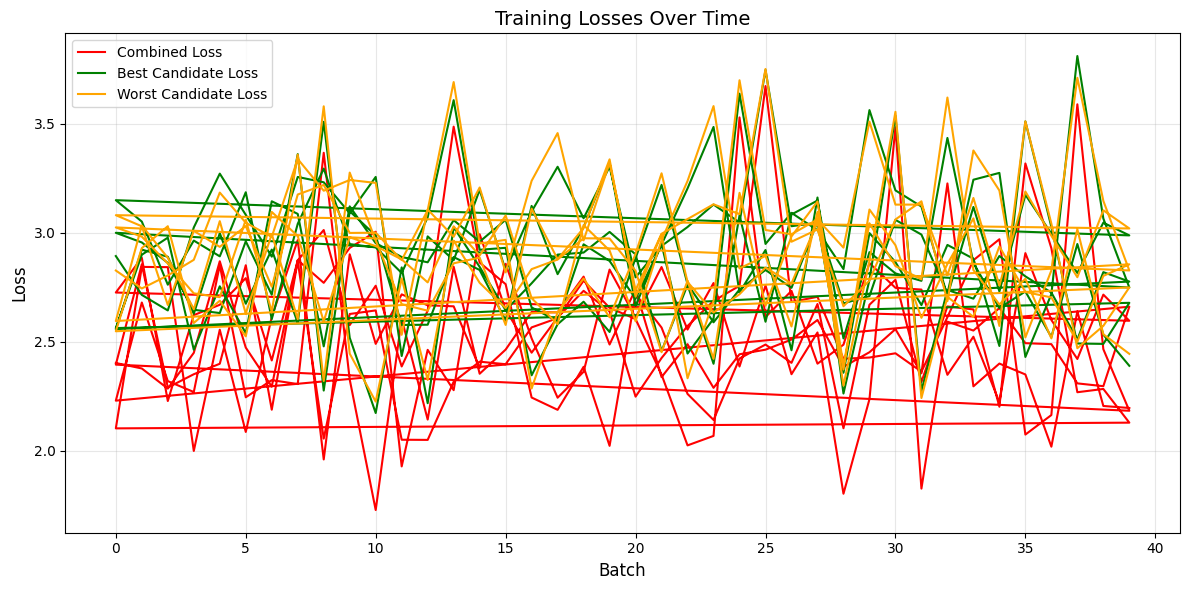

In [1]:
# ════════════════════════════════════════════════════════════════
# Enhanced Reward-Based Training
# ════════════════════════════════════════════════════════════════
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
import random

# Set device - GPU if available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE} for training")

# Create save directory with timestamp
timestamp = time.strftime("%Y%m%d-%H%M%S")
SAVE_DIR = f"reward_model_best_{timestamp}"
os.makedirs(SAVE_DIR, exist_ok=True)

# ────────────────────────────────────────────────────────────────
# 1) UniEval scorer
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator
sum_eval = get_evaluator("summarization", device="cpu")

@torch.inference_mode()
def get_unieval_scores(src, hyp, ref):
    """Get UniEval scores for generated summaries"""
    data = convert_to_json(
        output_list=hyp,
        src_list=src,
        ref_list=ref,
    )
    try:
        raw = sum_eval.evaluate(data)
        scores = [
            [d["coherence"], d["consistency"], d["fluency"], d["relevance"]]
            for d in raw
        ]
        return torch.tensor(scores, dtype=torch.float32)
    except Exception as e:
        print(f"Error in UniEval: {e}")
        # Return default neutral scores in case of errors
        return torch.tensor([[0.5, 0.5, 0.5, 0.5]] * len(src), dtype=torch.float32)

# ────────────────────────────────────────────────────────────────
# 2) Load GPT-2 Model and tokenizer
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from peft import LoraConfig, get_peft_model

BASE_MODEL = "gpt2"
base = GPT2LMHeadModel.from_pretrained(BASE_MODEL)
tokenizer = GPT2Tokenizer.from_pretrained(BASE_MODEL)

# Set padding
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    base.config.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

# Move base model to device
base = base.to(DEVICE)

# Add LoRA with improved parameters for efficient fine-tuning
lora_cfg = LoraConfig(
    task_type="CAUSAL_LM",
    r=16,  # Increased rank for better representation
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn", "c_proj"],
    bias="none",
)
model = get_peft_model(base, lora_cfg)

# ────────────────────────────────────────────────────────────────
# 3) Improved Dataset with enhanced prompts
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue", "note"]]

# Define a list of medical prompt templates for more diversity
MEDICAL_PROMPTS = [
    "Summarize the following conversation:\n\n",
    "Generate a concise medical summary of the conversation:\n\n",
    "Extract key medical information from the following conversation:\n\n",
    "Provide a summary of this medical dialogue:\n\n"
]

class ClinicalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512, prompt_templates=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.prompt_templates = prompt_templates or [MEDICAL_PROMPTS[0]]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        dialogue = str(self.df.iloc[idx]["dialogue"])
        reference = str(self.df.iloc[idx]["note"])
        
        # Randomly choose a prompt template for data augmentation
        prompt_template = random.choice(self.prompt_templates)
        prompt = f"{prompt_template}{dialogue}"
        
        inputs = self.tokenizer(
            prompt, 
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        
        return {
            "input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "prompt": prompt,
            "prompt_template": prompt_template,
            "reference": reference,
            "dialogue": dialogue
        }

# Create a larger dataset with more examples for better learning
sample_size = min(40, len(df))  # Use more examples but not too many to avoid long training times
dataset = ClinicalDataset(df.sample(sample_size, random_state=42), tokenizer, prompt_templates=MEDICAL_PROMPTS)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# ────────────────────────────────────────────────────────────────
# 4) Enhanced reward-weighted training loop with contrastive learning
# ────────────────────────────────────────────────────────────────
NUM_EPOCHS = 5  # Increased for more training
NUM_CANDIDATES = 4  # Generate more candidates for better selection
LEARNING_RATE = 3e-5  # Slightly lower for better stability

# Initialize optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Learning rate scheduler for better convergence
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',  # We want to maximize the score
    factor=0.5, 
    patience=2,
    verbose=True
)

# We'll keep track of performance
all_metrics = []
best_score_so_far = 0
best_model_path = os.path.join(SAVE_DIR, "best_model")

def train_with_rewards():
    print("Starting enhanced reward-based training")
    global best_score_so_far
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n{'='*30}\nEpoch {epoch+1}/{NUM_EPOCHS}\n{'='*30}")
        epoch_metrics = []
        
        for batch_idx, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            try:
                # Each batch contains a single example
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                dialogue = batch["dialogue"][0]  # String
                reference = batch["reference"][0]  # String
                prompt_template = batch["prompt_template"][0]  # String
                
                # 1. Generate multiple candidates
                candidates = []
                candidate_texts = []
                
                # Generate candidates with diverse parameters
                for i in range(NUM_CANDIDATES):
                    # Adjust parameters slightly for each candidate to increase diversity
                    temp = 0.6 + (i * 0.1)  # Temperatures from 0.6 to 0.9
                    p = 0.9 + (i * 0.02)  # Top-p from 0.9 to 0.96
                    
                    # Generate text with diversity
                    with torch.no_grad():
                        generated = model.generate(
                            input_ids=input_ids,
                            attention_mask=attention_mask,
                            do_sample=True,
                            temperature=temp,
                            max_new_tokens=128,  # Increased for more comprehensive summaries
                            top_p=min(p, 0.98),
                            top_k=50,
                            num_return_sequences=1,
                            pad_token_id=tokenizer.eos_token_id,
                            no_repeat_ngram_size=3  # Prevent repetition
                        )
                    
                    # Save generation and decode
                    candidates.append(generated)
                    text = tokenizer.decode(generated[0], skip_special_tokens=True)
                    
                    # Extract only the generated part (not the prompt)
                    prompt = batch["prompt"][0]
                    if prompt in text:
                        text = text[len(prompt):].strip()
                    
                    candidate_texts.append(text)
                    print(f"Candidate {i+1}: {text[:50]}...")
                
                # 2. Score candidates with UniEval
                scores = get_unieval_scores(
                    src=[dialogue] * NUM_CANDIDATES,
                    hyp=candidate_texts,
                    ref=[reference] * NUM_CANDIDATES
                ).numpy()
                
                print(f"UniEval scores: {scores}")
                
                # 3. Identify the best and worst candidates
                total_scores = scores.sum(axis=1)
                best_idx = np.argmax(total_scores)
                best_score = total_scores[best_idx]
                worst_idx = np.argmin(total_scores)
                
                print(f"Best candidate: {best_idx+1} with score {best_score:.4f}")
                print(f"Worst candidate: {worst_idx+1} with score {total_scores[worst_idx]:.4f}")
                
                # 4. Contrastive learning approach
                optimizer.zero_grad()
                
                # Compute language modeling loss for the best candidate (minimize this)
                outputs_best = model(
                    input_ids=candidates[best_idx],
                    labels=candidates[best_idx]
                )
                loss_best = outputs_best.loss
                
                # Compute loss for worst candidate (we want to make it less likely)
                if best_idx != worst_idx:
                    outputs_worst = model(
                        input_ids=candidates[worst_idx],
                        labels=candidates[worst_idx]
                    )
                    # Use a small negative weight to avoid destabilizing training
                    loss_worst = -0.2 * outputs_worst.loss
                else:
                    loss_worst = 0
                
                # Combined loss with scaling based on score quality
                score_range = best_score - total_scores[worst_idx] if best_idx != worst_idx else 1.0
                if best_idx != worst_idx:
                    loss = loss_best + (loss_worst * min(score_range, 1.0))
                else:
                    loss = loss_best
                
                # Backpropagate and update
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                # Log metrics
                metric_entry = {
                    "batch": batch_idx,
                    "epoch": epoch,
                    "best_score": best_score,
                    "worst_score": total_scores[worst_idx] if best_idx != worst_idx else None,
                    "loss": loss.item(),
                    "best_loss": loss_best.item(),
                    "prompt_template": prompt_template
                }
                if best_idx != worst_idx:
                    metric_entry["worst_loss"] = outputs_worst.loss.item()
                
                epoch_metrics.append(metric_entry)
                
                print(f"Loss: {loss.item():.4f}, Best Loss: {loss_best.item():.4f}")
                
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        # Save model after each epoch
        save_path = os.path.join(SAVE_DIR, f"epoch_{epoch+1}")
        os.makedirs(save_path, exist_ok=True)
        model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)
        
        # Calculate epoch metrics
        if epoch_metrics:
            epoch_avg_score = np.mean([m["best_score"] for m in epoch_metrics])
            
            # Update learning rate based on performance
            scheduler.step(epoch_avg_score)
            
            # Save best model if this epoch is better
            if epoch_avg_score > best_score_so_far:
                best_score_so_far = epoch_avg_score
                os.makedirs(best_model_path, exist_ok=True)
                model.save_pretrained(best_model_path)
                tokenizer.save_pretrained(best_model_path)
                print(f"New best model saved with score: {best_score_so_far:.4f}")
        else:
            epoch_avg_score = 0
        
        # Save metrics
        all_metrics.extend(epoch_metrics)
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(os.path.join(SAVE_DIR, "training_metrics.csv"), index=False)
        
        print(f"Epoch {epoch+1} complete. Average score: {epoch_avg_score:.4f}")
    
    print("\n🎉 Enhanced reward-based training complete!")
    return all_metrics

# Run the training
metrics = train_with_rewards()

# ────────────────────────────────────────────────────────────────
# 5) Visualize training progress with enhanced plots
# ────────────────────────────────────────────────────────────────
metrics_df = pd.DataFrame(metrics)

# Plot best scores
plt.figure(figsize=(12, 6))
plt.plot(metrics_df["batch"], metrics_df["best_score"], marker='o', linestyle='-', color='blue')
plt.xlabel('Batch', fontsize=12)
plt.ylabel('Best Candidate Score', fontsize=12)
plt.title('Training Progress: Best Candidate Score Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "training_progress.png"), dpi=300)
plt.close()

# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(metrics_df["batch"], metrics_df["loss"], label='Combined Loss', color='red')
plt.plot(metrics_df["batch"], metrics_df["best_loss"], label='Best Candidate Loss', color='green')
if "worst_loss" in metrics_df.columns:
    plt.plot(metrics_df["batch"], metrics_df["worst_loss"], label='Worst Candidate Loss', color='orange')
plt.xlabel('Batch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Losses Over Time', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "training_losses.png"), dpi=300)

# Create a quick validation test
print("\nRunning quick validation test...")
test_samples = 3
test_df = df.sample(test_samples, random_state=99)  # Different seed from training

for _, row in test_df.iterrows():
    dialogue = str(row["dialogue"])
    reference = str(row["note"])
    
    # Create prompt
    prompt = f"{MEDICAL_PROMPTS[0]}{dialogue}"
    
    # Tokenize
    inputs = tokenizer(
        prompt, 
        return_tensors="pt"
    ).to(DEVICE)
    
    # Generate summary with the best model
    with torch.no_grad():
        generated = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            do_sample=False,  # Use greedy for validation
            max_new_tokens=128,
            num_beams=3
        )
    
    # Decode
    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    
    # Extract only the generated part
    if prompt in generated_text:
        summary = generated_text[len(prompt):].strip()
    else:
        summary = generated_text
    
    print(f"\nDialogue: {dialogue[:100]}...")
    print(f"Reference: {reference[:100]}...")
    print(f"Generated: {summary[:100]}...")

print(f"\nTraining complete! Models saved to {SAVE_DIR}")

In [ ]:
# ════════════════════════════════════════════════════════════════
# Testing Script for Custom Reward-Based Trained Model
# ════════════════════════════════════════════════════════════════
import os
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

# Check if CUDA is available for inference
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = "cuda" if CUDA_AVAILABLE else "cpu"
print(f"Using device: {DEVICE} for inference")

# ────────────────────────────────────────────────────────────────
# 1) Load the trained model weights
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from peft import PeftModel

# Path to the saved model weights
MODEL_PATH = r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\reward_checkpoints_best\epoch_4"

# Use the same prompt format that was used during training
PROMPT_TEMPLATE = "Summarize the following conversation:\n\n"

# Load the tokenizer and model from saved path
print(f"Loading model from {MODEL_PATH}")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_PATH)
model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"  # Important for decoder-only models
model = model.to(DEVICE)
model.eval()  # Set to evaluation mode

# ────────────────────────────────────────────────────────────────
# 2) Prepare test dataset
# ────────────────────────────────────────────────────────────────
# Load test data
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")
test_df = df.sample(20, random_state=42)  # Using 20 samples for testing

# Prepare test dialogues and references
dialogues = test_df["dialogue"].tolist()
references = test_df["note"].tolist()

# ────────────────────────────────────────────────────────────────
# 3) Generate summaries using trained model
# ────────────────────────────────────────────────────────────────
print("Generating summaries...")
batch_size = 4
num_samples = len(dialogues)
num_batches = (num_samples + batch_size - 1) // batch_size
predictions = []

for i in tqdm(range(num_batches)):
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = dialogues[start:end]
    
    # Use the same prompt format as during training
    prompts = [
        f"{PROMPT_TEMPLATE}{c}"
        for c in convs if len(str(c).strip()) > 10
    ]
    
    if not prompts:
        continue
    
    # Tokenize
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Generate with improved parameters matching training
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=128,  # Increased from 120
            do_sample=True,  # Use sampling as in training
            temperature=0.7,
            top_p=0.92,
            top_k=50,
            num_beams=3,
            no_repeat_ngram_size=3
        )
    
    # Decode
    dec = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    
    # Extract only the generated part (not including the prompt)
    cleaned_predictions = []
    for p, original_prompt in zip(dec, prompts):
        # Try to extract just the generated part
        if original_prompt in p:
            generated_part = p[p.find(original_prompt) + len(original_prompt):]
            cleaned_predictions.append(generated_part.strip())
        else:
            # If we can't find the prompt, use the whole generation
            cleaned_predictions.append(p.strip())
    
    predictions.extend(cleaned_predictions)

print(f"✅ Generated {len(predictions)} summaries.")

# ────────────────────────────────────────────────────────────────
# 4) Evaluate with UniEval
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

# Keep UniEval on CPU (more stable)
sum_eval = get_evaluator("summarization", device="cpu")

# Trim predictions and references to the same length
min_len = min(len(predictions), len(references), len(dialogues))
predictions = predictions[:min_len]
references = references[:min_len]
dialogues = dialogues[:min_len]

# Create JSON data for UniEval
print("Creating evaluation data...")
data = convert_to_json(
    src_list=[str(d) for d in dialogues],
    ref_list=[str(r) for r in references],
    output_list=[str(p) for p in predictions]
)

# Run evaluation
print("Running UniEval...")
scores = sum_eval.evaluate(data, print_result=True)

# ────────────────────────────────────────────────────────────────
# 5) Display results
# ────────────────────────────────────────────────────────────────
# Extract scores for each metric
coherence_scores = [item["coherence"] for item in scores]
consistency_scores = [item["consistency"] for item in scores]
fluency_scores = [item["fluency"] for item in scores]
relevance_scores = [item["relevance"] for item in scores]

# Calculate averages
avg_coherence = sum(coherence_scores) / len(coherence_scores)
avg_consistency = sum(consistency_scores) / len(consistency_scores)
avg_fluency = sum(fluency_scores) / len(fluency_scores)
avg_relevance = sum(relevance_scores) / len(relevance_scores)

print("\n=== Summary Evaluation Results ===")
print(f"Average Coherence: {avg_coherence:.4f}")
print(f"Average Consistency: {avg_consistency:.4f}")
print(f"Average Fluency: {avg_fluency:.4f}")
print(f"Average Relevance: {avg_relevance:.4f}")
print(f"Overall Average: {(avg_coherence + avg_consistency + avg_fluency + avg_relevance) / 4:.4f}")

# ────────────────────────────────────────────────────────────────
# 6) Sample output comparison
# ────────────────────────────────────────────────────────────────
print("\n=== Sample Output Comparison ===")
for i in range(min(3, min_len)):  # Show up to 3 examples
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {dialogues[i][:100]}...")
    print(f"Reference: {references[i][:100]}...")
    print(f"Generated: {predictions[i][:100]}...")
    print(f"Scores: Coherence={coherence_scores[i]:.2f}, Consistency={consistency_scores[i]:.2f}, "
          f"Fluency={fluency_scores[i]:.2f}, Relevance={relevance_scores[i]:.2f}")

# ────────────────────────────────────────────────────────────────
# 7) Save results
# ────────────────────────────────────────────────────────────────
# Create a results dataframe
results_df = pd.DataFrame({
    'dialogue': dialogues[:min_len],
    'reference': references[:min_len],
    'prediction': predictions[:min_len],
    'coherence': coherence_scores,
    'consistency': consistency_scores,
    'fluency': fluency_scores,
    'relevance': relevance_scores
})

# Save to CSV with a specific name for the reward-based model
results_file = "reward_training_evaluation_results.csv"
results_df.to_csv(results_file, index=False)
print(f"\nResults saved to {results_file}")

# ────────────────────────────────────────────────────────────────
# 8) Compare with different generation settings
# ────────────────────────────────────────────────────────────────
print("\n=== Testing alternative generation settings ===")

# Test with different temperature
alt_predictions = []

for i in tqdm(range(min(5, num_batches))):  # Test on a subset to save time
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = dialogues[start:end]
    
    prompts = [
        f"{PROMPT_TEMPLATE}{c}"
        for c in convs if len(str(c).strip()) > 10
    ]
    
    if not prompts:
        continue
    
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Use greedy decoding instead of sampling
    with torch.no_grad():
        alt_ids = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=128,
            do_sample=False,  # Use greedy decoding
            num_beams=5,  # More beams for better quality
            no_repeat_ngram_size=3
        )
    
    dec = tokenizer.batch_decode(alt_ids, skip_special_tokens=True)
    
    # Extract only the generated part
    cleaned = []
    for p, original_prompt in zip(dec, prompts):
        if original_prompt in p:
            generated_part = p[p.find(original_prompt) + len(original_prompt):]
            cleaned.append(generated_part.strip())
        else:
            cleaned.append(p.strip())
    
    alt_predictions.extend(cleaned)

# Evaluate alternative settings (if we have any)
if alt_predictions:
    # Trim to match the size of the subset we generated
    max_alt_len = min(len(alt_predictions), min_len)
    alt_dialogues = dialogues[:max_alt_len]
    alt_references = references[:max_alt_len]
    alt_predictions = alt_predictions[:max_alt_len]
    
    alt_data = convert_to_json(
        src_list=[str(d) for d in alt_dialogues],
        ref_list=[str(r) for r in alt_references],
        output_list=[str(p) for p in alt_predictions]
    )
    
    print("Evaluating alternative generation settings...")
    alt_scores = sum_eval.evaluate(alt_data, print_result=True)
    
    # Calculate average scores
    alt_avg_coherence = sum([s["coherence"] for s in alt_scores]) / len(alt_scores)
    alt_avg_consistency = sum([s["consistency"] for s in alt_scores]) / len(alt_scores)
    alt_avg_fluency = sum([s["fluency"] for s in alt_scores]) / len(alt_scores)
    alt_avg_relevance = sum([s["relevance"] for s in alt_scores]) / len(alt_scores)
    
    print("\n=== Alternative Settings Evaluation Results ===")
    print(f"Average Coherence: {alt_avg_coherence:.4f}")
    print(f"Average Consistency: {alt_avg_consistency:.4f}")
    print(f"Average Fluency: {alt_avg_fluency:.4f}")
    print(f"Average Relevance: {alt_avg_relevance:.4f}")
    print(f"Overall Average: {(alt_avg_coherence + alt_avg_consistency + alt_avg_fluency + alt_avg_relevance) / 4:.4f}")

Using device: cuda for inference


C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\reward_checkpoints_best\epoch_4


C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating summaries...


100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.39s/it]


✅ Generated 20 summaries.


C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating evaluation data...
Running UniEval...
Evaluating coherence of 20 samples !!!


100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:44<00:00, 14.87s/it]


Evaluating consistency of 20 samples !!!


100%|████████████████████████████████████████████████████████████████████████| 41/41 [12:27<00:00, 18.24s/it]


Evaluating fluency of 20 samples !!!


100%|████████████████████████████████████████████████████████████████████████| 41/41 [01:43<00:00,  2.54s/it]


Evaluating relevance of 20 samples !!!


100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:44<00:00, 14.71s/it]



Evaluation scores are shown below:
+-------------+----------+
|  Dimensions |  Score   |
+-------------+----------+
|  coherence  | 0.721884 |
| consistency | 0.734711 |
|   fluency   | 0.672253 |
|  relevance  | 0.642737 |
|   overall   | 0.692896 |
+-------------+----------+

=== Summary Evaluation Results ===
Average Coherence: 0.7219
Average Consistency: 0.7347
Average Fluency: 0.6723
Average Relevance: 0.6427
Overall Average: 0.6929

=== Sample Output Comparison ===

Example 1:
Dialogue: [doctor] hi bruce , how are you ?
[patient] hey , good to see you .
[doctor] good to see you as well...
Reference: CHIEF COMPLAINT

Follow up of chronic problems.

HISTORY OF PRESENT ILLNESS

Bruce Howard is a 60-ye...
Generated: Summarize the following conversation:

[doctor] hi bruce, how are you?
[patient] hey, good to see yo...
Scores: Coherence=0.93, Consistency=0.91, Fluency=0.71, Relevance=0.90

Example 2:
Dialogue: [doctor] okay michael so i see in here that you're here because you're exp

100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


Evaluating alternative generation settings...
Evaluating coherence of 20 samples !!!


100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.88s/it]


Evaluating consistency of 20 samples !!!


 49%|███████████████████████████████████                                     | 19/39 [04:35<04:47, 14.38s/it]

In [ ]:
# ════════════════════════════════════════════════════════════════
# Testing Script for PPO-Trained Model
# ════════════════════════════════════════════════════════════════
import os
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

# Check if CUDA is available for inference
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = "cuda" if CUDA_AVAILABLE else "cpu"
print(f"Using device: {DEVICE} for inference")

# ────────────────────────────────────────────────────────────────
# 1) Load the trained model weights
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Path to the saved model weights
# MODEL_PATH = r"D:\kshitij-weights-folder\gpt-2-tuned-ppo"
# MODEL_PATH = r"D:\kshitij-weights-folder\gpt-2-tuned-ppo-new"
# MODEL_PATH = r"D:\kshitij-weights-folder\gpt-2-tuned-ppo-extracted"
MODEL_PATH=r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\reward_checkpoints_best\epoch_4"

MEDICAL_PROMPT = "\nGenerate a concise medical summary focusing on key findings and treatment plans. Include chief complaints, symptoms, medications, and recommendations if mentioned in the conversation:"

# Load the tokenizer and model from saved path
print(f"Loading model from {MODEL_PATH}")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_PATH)
model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"  # Important for decoder-only models

model = model.to(DEVICE)
model.eval()  # Set to evaluation mode

# ────────────────────────────────────────────────────────────────
# 2) Prepare test dataset
# ────────────────────────────────────────────────────────────────
# Load test data
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")
test_df = df.sample(20, random_state=42)  # Using 20 samples for testing

# Prepare test dialogues and references
dialogues = test_df["dialogue"].tolist()
references = test_df["note"].tolist()

# ────────────────────────────────────────────────────────────────
# 3) Generate summaries using trained model
# ────────────────────────────────────────────────────────────────
print("Generating summaries...")
batch_size = 4
num_samples = len(dialogues)
num_batches = (num_samples + batch_size - 1) // batch_size
predictions = []

for i in tqdm(range(num_batches)):
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = dialogues[start:end]
    
    # Use our medical prompt
    prompts = [
        f"{MEDICAL_PROMPT}{c}"
        for c in convs if len(str(c).strip()) > 10
    ]
    
    if not prompts:
        continue
    
    # Tokenize
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Generate
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=120,
            do_sample=False,
            num_beams=3,
            no_repeat_ngram_size=2
        )
    
    # Decode
    dec = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    
    # Extract only the generated part (not including the prompt)
    cleaned_predictions = []
    for p, original_prompt in zip(dec, prompts):
        # Try to extract just the generated part
        if original_prompt in p:
            generated_part = p[p.find(original_prompt) + len(original_prompt):]
            cleaned_predictions.append(generated_part.strip())
        else:
            # If we can't find the prompt, use the whole generation
            cleaned_predictions.append(p.strip())
    
    predictions.extend(cleaned_predictions)

print(f"✅ Generated {len(predictions)} summaries.")

# ────────────────────────────────────────────────────────────────
# 4) Evaluate with UniEval
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

# Keep UniEval on CPU (more stable)
sum_eval = get_evaluator("summarization", device="cpu")

# Trim predictions and references to the same length
min_len = min(len(predictions), len(references), len(dialogues))
predictions = predictions[:min_len]
references = references[:min_len]
dialogues = dialogues[:min_len]

# Create JSON data for UniEval
print("Creating evaluation data...")
data = convert_to_json(
    src_list=[str(d) for d in dialogues],
    ref_list=[str(r) for r in references],
    output_list=[str(p) for p in predictions]
)

# Run evaluation
print("Running UniEval...")
scores = sum_eval.evaluate(data, print_result=True)

# ────────────────────────────────────────────────────────────────
# 5) Display results
# ────────────────────────────────────────────────────────────────
# Extract scores for each metric
coherence_scores = [item["coherence"] for item in scores]
consistency_scores = [item["consistency"] for item in scores]
fluency_scores = [item["fluency"] for item in scores]
relevance_scores = [item["relevance"] for item in scores]

# Calculate averages
avg_coherence = sum(coherence_scores) / len(coherence_scores)
avg_consistency = sum(consistency_scores) / len(consistency_scores)
avg_fluency = sum(fluency_scores) / len(fluency_scores)
avg_relevance = sum(relevance_scores) / len(relevance_scores)

print("\n=== Summary Evaluation Results ===")
print(f"Average Coherence: {avg_coherence:.4f}")
print(f"Average Consistency: {avg_consistency:.4f}")
print(f"Average Fluency: {avg_fluency:.4f}")
print(f"Average Relevance: {avg_relevance:.4f}")
print(f"Overall Average: {(avg_coherence + avg_consistency + avg_fluency + avg_relevance) / 4:.4f}")

# ────────────────────────────────────────────────────────────────
# 6) Sample output comparison
# ────────────────────────────────────────────────────────────────
print("\n=== Sample Output Comparison ===")
for i in range(min(3, min_len)):  # Show up to 3 examples
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {dialogues[i][:100]}...")
    print(f"Reference: {references[i][:100]}...")
    print(f"Generated: {predictions[i][:100]}...")
    print(f"Scores: Coherence={coherence_scores[i]:.2f}, Consistency={consistency_scores[i]:.2f}, "
          f"Fluency={fluency_scores[i]:.2f}, Relevance={relevance_scores[i]:.2f}")

# ────────────────────────────────────────────────────────────────
# 7) Save results
# ────────────────────────────────────────────────────────────────
# Create a results dataframe
results_df = pd.DataFrame({
    'dialogue': dialogues[:min_len],
    'reference': references[:min_len],
    'prediction': predictions[:min_len],
    'coherence': coherence_scores,
    'consistency': consistency_scores,
    'fluency': fluency_scores,
    'relevance': relevance_scores
})

# Save to CSV
results_file = "ppo_evaluation_results.csv"
results_df.to_csv(results_file, index=False)
print(f"\nResults saved to {results_file}")

Using device: cuda for inference
Loading model from C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\reward_checkpoints_best\epoch_4


C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating summaries...


100%|██████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]
C:\Users\BMSCE CSE.DESKTOP-IUB6THA\.conda\envs\kshitij\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✅ Generated 20 summaries.
Creating evaluation data...
Running UniEval...
Evaluating coherence of 20 samples !!!


  0%|                                                                                  | 0/3 [00:00<?, ?it/s]

In [ ]:
# hi

# ════════════════════════════════════════════════════════════════
# Testing Script for Extraction-Enhanced PPO-Trained Model
# ════════════════════════════════════════════════════════════════
import os
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

# Check if CUDA is available for inference
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = "cuda" if CUDA_AVAILABLE else "cpu"
print(f"Using device: {DEVICE} for inference")

# ────────────────────────────────────────────────────────────────
# 1) Load both the summary model and extraction model
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer

# Paths
MODEL_PATH = r"D:\kshitij-weights-folder\gpt-2-tuned-ppo-extracted"
EXTRACTION_MODEL_PATH = "bigscience/bloomz-1b7"  # Extraction model

# Enhanced prompt
MEDICAL_PROMPT = "\nGenerate a concise medical summary focusing on key findings and treatment plans. Include chief complaints, symptoms, medications, and recommendations if mentioned in the conversation:"

# Load the models
print(f"Loading summary model from {MODEL_PATH}")
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_PATH)
model = GPT2LMHeadModel.from_pretrained(MODEL_PATH)

print(f"Loading extraction model from {EXTRACTION_MODEL_PATH}")
extraction_tokenizer = AutoTokenizer.from_pretrained(EXTRACTION_MODEL_PATH)
extraction_model = AutoModelForCausalLM.from_pretrained(
    EXTRACTION_MODEL_PATH,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"
model = model.to(DEVICE)
model.eval()

# ────────────────────────────────────────────────────────────────
# 2) Define the extraction function
# ────────────────────────────────────────────────────────────────
def extract_medical_info(conversation, max_length=300):
    """Extract key medical information using the extraction model"""
    extraction_prompt = (
        "Extract these key medical information points from the conversation below:\n"
        "- Chief complaint\n"
        "- Symptoms and duration\n"
        "- Current medications\n"
        "- Vital signs\n"
        "- Physical exam findings\n"
        "- Recommendations\n\n"
        f"Conversation:\n{conversation}\n\n"
        "Extracted information:"
    )
    
    # Truncate if needed
    if len(extraction_prompt.split()) > 800:
        words = conversation.split()
        truncated = " ".join(words[:700])
        extraction_prompt = extraction_prompt.replace(conversation, truncated)
    
    inputs = extraction_tokenizer(extraction_prompt, return_tensors="pt").to(extraction_model.device)
    
    with torch.no_grad():
        try:
            outputs = extraction_model.generate(
                inputs.input_ids,
                max_length=len(inputs.input_ids[0]) + max_length,
                temperature=0.3,
                top_p=0.95
            )
            
            extracted_text = extraction_tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            # Extract the generated part
            if extraction_prompt in extracted_text:
                extracted_info = extracted_text.replace(extraction_prompt, "").strip()
            else:
                # Try to find the end of the prompt
                prompt_end = "Extracted information:"
                if prompt_end in extracted_text:
                    extracted_info = extracted_text.split(prompt_end)[1].strip()
                else:
                    extracted_info = extracted_text
            
            return extracted_info
            
        except Exception as e:
            print(f"Error in extraction: {e}")
            return "Unable to extract information."

# ────────────────────────────────────────────────────────────────
# 3) Prepare test dataset
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")
test_df = df.sample(20, random_state=42)
dialogues = test_df["dialogue"].tolist()
references = test_df["note"].tolist()

# ────────────────────────────────────────────────────────────────
# 4) Generate summaries using the two-step approach
# ────────────────────────────────────────────────────────────────
print("Generating summaries with extraction enhancement...")
batch_size = 4
num_samples = len(dialogues)
num_batches = (num_samples + batch_size - 1) // batch_size
predictions = []
extracted_infos = []  # Store for analysis

for i in tqdm(range(num_batches)):
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = dialogues[start:end]
    
    batch_prompts = []
    batch_extracted = []
    
    for conv in convs:
        if len(str(conv).strip()) < 10:
            continue
        
        # Step 1: Extract information
        extracted_info = extract_medical_info(conv)
        batch_extracted.append(extracted_info)
        
        # Step 2: Create enhanced prompt with extracted info
        full_prompt = (
            f"{MEDICAL_PROMPT}\n"
            f"KEY INFORMATION:\n{extracted_info}\n\n"
            "Based on the above, generate a concise medical summary:"
        )
        
        batch_prompts.append(full_prompt)
    
    if not batch_prompts:
        continue
    
    # Store extracted information
    extracted_infos.extend(batch_extracted)
    
    # Tokenize for generation
    enc = tokenizer(
        batch_prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Generate summaries
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=120,
            do_sample=False,
            num_beams=3,
            no_repeat_ngram_size=2
        )
    
    # Decode and extract generated part
    dec = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    cleaned_predictions = []
    
    for p, original_prompt in zip(dec, batch_prompts):
        if original_prompt in p:
            # Find where the prompt ends and extract just the generated part
            generated_part = p[p.find(original_prompt) + len(original_prompt):]
            cleaned_predictions.append(generated_part.strip())
        else:
            # If prompt can't be found, use the whole output
            cleaned_predictions.append(p.strip())
    
    predictions.extend(cleaned_predictions)

print(f"✅ Generated {len(predictions)} summaries with extraction enhancement.")

# ────────────────────────────────────────────────────────────────
# 5) Evaluate with UniEval
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

sum_eval = get_evaluator("summarization", device="cpu")

# Ensure all lists have the same length
min_len = min(len(predictions), len(references), len(dialogues), len(extracted_infos))
predictions = predictions[:min_len]
references = references[:min_len]
dialogues = dialogues[:min_len]
extracted_infos = extracted_infos[:min_len]

# Create evaluation data
print("Creating evaluation data...")
data = convert_to_json(
    src_list=[str(d) for d in dialogues],
    ref_list=[str(r) for r in references],
    output_list=[str(p) for p in predictions]
)

# Run evaluation
print("Running UniEval...")
scores = sum_eval.evaluate(data, print_result=True)

# ────────────────────────────────────────────────────────────────
# 6) Display results
# ────────────────────────────────────────────────────────────────
coherence_scores = [item["coherence"] for item in scores]
consistency_scores = [item["consistency"] for item in scores]
fluency_scores = [item["fluency"] for item in scores]
relevance_scores = [item["relevance"] for item in scores]

avg_coherence = sum(coherence_scores) / len(coherence_scores)
avg_consistency = sum(consistency_scores) / len(consistency_scores)
avg_fluency = sum(fluency_scores) / len(fluency_scores)
avg_relevance = sum(relevance_scores) / len(relevance_scores)

print("\n=== Summary Evaluation Results ===")
print(f"Average Coherence: {avg_coherence:.4f}")
print(f"Average Consistency: {avg_consistency:.4f}")
print(f"Average Fluency: {avg_fluency:.4f}")
print(f"Average Relevance: {avg_relevance:.4f}")
print(f"Overall Average: {(avg_coherence + avg_consistency + avg_fluency + avg_relevance) / 4:.4f}")

# ────────────────────────────────────────────────────────────────
# 7) Sample output comparison
# ────────────────────────────────────────────────────────────────
print("\n=== Sample Output Comparison ===")
for i in range(min(3, min_len)):
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {dialogues[i][:100]}...")
    print(f"Extracted Info: {extracted_infos[i][:100]}...")
    print(f"Reference: {references[i][:100]}...")
    print(f"Generated: {predictions[i][:100]}...")
    print(f"Scores: Coherence={coherence_scores[i]:.2f}, Consistency={consistency_scores[i]:.2f}, "
          f"Fluency={fluency_scores[i]:.2f}, Relevance={relevance_scores[i]:.2f}")

# ────────────────────────────────────────────────────────────────
# 8) Save detailed results
# ────────────────────────────────────────────────────────────────
results_df = pd.DataFrame({
    'dialogue': dialogues[:min_len],
    'extracted_info': extracted_infos[:min_len],
    'reference': references[:min_len],
    'prediction': predictions[:min_len],
    'coherence': coherence_scores,
    'consistency': consistency_scores,
    'fluency': fluency_scores,
    'relevance': relevance_scores
})

results_file = "ppo_extraction_enhanced_results.csv"
results_df.to_csv(results_file, index=False)
print(f"\nResults saved to {results_file}")

In [ ]:
# ════════════════════════════════════════════════════════════════
# Baseline GPT-2 Testing Script (For Comparison)
# ════════════════════════════════════════════════════════════════
import os
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np

# Check if CUDA is available for inference
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = "cuda" if CUDA_AVAILABLE else "cpu"
print(f"Using device: {DEVICE} for inference")

# ────────────────────────────────────────────────────────────────
# 1) Load the base GPT-2 model (without LoRA)
# ────────────────────────────────────────────────────────────────
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load base model directly
base_model = "gpt2"
model = GPT2LMHeadModel.from_pretrained(base_model)
tokenizer = GPT2Tokenizer.from_pretrained(base_model)

# Ensure pad token is set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"  # Important for decoder-only models

# Move model to appropriate device
model = model.to(DEVICE)
model.eval()  # Set to evaluation mode

print(f"Loaded baseline GPT-2 model (without LoRA weights)")

# ────────────────────────────────────────────────────────────────
# 2) Prepare the same test dataset as before
# ────────────────────────────────────────────────────────────────
# Load test data - ensure we use the same samples as before
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")
test_df = df.sample(20, random_state=42)  # Using same random seed as LoRA test

# Prepare test dialogues and references
dialogues = test_df["dialogue"].tolist()
references = test_df["note"].tolist()

# ────────────────────────────────────────────────────────────────
# 3) Generate summaries using baseline model
# ────────────────────────────────────────────────────────────────
print("Generating summaries with baseline GPT-2...")
batch_size = 4
num_samples = len(dialogues)
num_batches = (num_samples + batch_size - 1) // batch_size
baseline_predictions = []

for i in tqdm(range(num_batches)):
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = dialogues[start:end]
    prompts = [
        f"Summarize the following conversation:\n\n{c}"
        for c in convs if len(str(c).strip()) > 10
    ]
    if not prompts:
        continue
    
    # Tokenize
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Generate - using same parameters as LoRA model for fair comparison
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=120,
            do_sample=False,
            num_beams=3,
            no_repeat_ngram_size=2
        )
    
    # Decode
    dec = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    baseline_predictions.extend(dec)

print(f"✅ Generated {len(baseline_predictions)} baseline summaries.")

# ────────────────────────────────────────────────────────────────
# 4) Evaluate with UniEval
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

# Keep UniEval on CPU
sum_eval = get_evaluator("summarization", device="cpu")

# Trim predictions and references to the same length
min_len = min(len(baseline_predictions), len(references), len(dialogues))
baseline_predictions = baseline_predictions[:min_len]
references = references[:min_len]
dialogues = dialogues[:min_len]

# Create JSON data for UniEval
print("Creating evaluation data...")
data = convert_to_json(
    src_list=[str(d) for d in dialogues],
    ref_list=[str(r) for r in references],
    output_list=[str(p) for p in baseline_predictions]
)

# Run evaluation
print("Running UniEval on baseline model outputs...")
baseline_scores = sum_eval.evaluate(data, print_result=True)

# ────────────────────────────────────────────────────────────────
# 5) Display baseline results
# ────────────────────────────────────────────────────────────────
# Extract scores for each metric
baseline_coherence = [item["coherence"] for item in baseline_scores]
baseline_consistency = [item["consistency"] for item in baseline_scores]
baseline_fluency = [item["fluency"] for item in baseline_scores]
baseline_relevance = [item["relevance"] for item in baseline_scores]

# Calculate averages
avg_coherence = sum(baseline_coherence) / len(baseline_coherence)
avg_consistency = sum(baseline_consistency) / len(baseline_consistency)
avg_fluency = sum(baseline_fluency) / len(baseline_fluency)
avg_relevance = sum(baseline_relevance) / len(baseline_relevance)

print("\n=== Baseline GPT-2 Summary Evaluation Results ===")
print(f"Average Coherence: {avg_coherence:.4f}")
print(f"Average Consistency: {avg_consistency:.4f}")
print(f"Average Fluency: {avg_fluency:.4f}")
print(f"Average Relevance: {avg_relevance:.4f}")
print(f"Overall Average: {(avg_coherence + avg_consistency + avg_fluency + avg_relevance) / 4:.4f}")

# ────────────────────────────────────────────────────────────────
# 6) Sample output comparison
# ────────────────────────────────────────────────────────────────
print("\n=== Sample Baseline Outputs ===")
for i in range(min(3, min_len)):  # Show up to 3 examples
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {dialogues[i][:100]}...")
    print(f"Reference: {references[i][:100]}...")
    print(f"Generated: {baseline_predictions[i][:100]}...")
    print(f"Scores: Coherence={baseline_coherence[i]:.2f}, Consistency={baseline_consistency[i]:.2f}, "
          f"Fluency={baseline_fluency[i]:.2f}, Relevance={baseline_relevance[i]:.2f}")

# ────────────────────────────────────────────────────────────────
# 7) Save results
# ────────────────────────────────────────────────────────────────
# Create a results dataframe
results_df = pd.DataFrame({
    'dialogue': dialogues[:min_len],
    'reference': references[:min_len],
    'baseline_prediction': baseline_predictions[:min_len],
    'coherence': baseline_coherence,
    'consistency': baseline_consistency,
    'fluency': baseline_fluency,
    'relevance': baseline_relevance
})

# Save to CSV
results_file = "baseline_gpt2_evaluation_results.csv"
results_df.to_csv(results_file, index=False)
print(f"\nBaseline results saved to {results_file}")

# ────────────────────────────────────────────────────────────────
# 8) Try to load LoRA results for comparison (if available)
# ────────────────────────────────────────────────────────────────
try:
    lora_results = pd.read_csv("ppo_evaluation_results.csv")
    
    # Check if we have matching entries
    if len(lora_results) == len(results_df):
        print("\n=== Comparison: Baseline vs. LoRA PPO ===")
        
        # Calculate average score improvements
        lora_coherence_avg = lora_results['coherence'].mean()
        lora_consistency_avg = lora_results['consistency'].mean()
        lora_fluency_avg = lora_results['fluency'].mean()
        lora_relevance_avg = lora_results['relevance'].mean()
        lora_overall = (lora_coherence_avg + lora_consistency_avg + lora_fluency_avg + lora_relevance_avg) / 4
        
        baseline_overall = (avg_coherence + avg_consistency + avg_fluency + avg_relevance) / 4
        
        # Print comparison
        print(f"{'Metric':<12} {'Baseline':<10} {'LoRA PPO':<10} {'Difference':<10}")
        print(f"{'-'*42}")
        print(f"{'Coherence':<12} {avg_coherence:.4f}     {lora_coherence_avg:.4f}     {lora_coherence_avg-avg_coherence:+.4f}")
        print(f"{'Consistency':<12} {avg_consistency:.4f}     {lora_consistency_avg:.4f}     {lora_consistency_avg-avg_consistency:+.4f}")
        print(f"{'Fluency':<12} {avg_fluency:.4f}     {lora_fluency_avg:.4f}     {lora_fluency_avg-avg_fluency:+.4f}")
        print(f"{'Relevance':<12} {avg_relevance:.4f}     {lora_relevance_avg:.4f}     {lora_relevance_avg-avg_relevance:+.4f}")
        print(f"{'-'*42}")
        print(f"{'OVERALL':<12} {baseline_overall:.4f}     {lora_overall:.4f}     {lora_overall-baseline_overall:+.4f}")
        
        # Create a combined CSV for easy comparison
        combined_df = results_df.copy()
        combined_df['lora_prediction'] = lora_results['prediction']
        combined_df['lora_coherence'] = lora_results['coherence']
        combined_df['lora_consistency'] = lora_results['consistency']
        combined_df['lora_fluency'] = lora_results['fluency']
        combined_df['lora_relevance'] = lora_results['relevance']
        
        # Calculate per-example improvement
        combined_df['coherence_diff'] = combined_df['lora_coherence'] - combined_df['coherence']
        combined_df['consistency_diff'] = combined_df['lora_consistency'] - combined_df['consistency']
        combined_df['fluency_diff'] = combined_df['lora_fluency'] - combined_df['fluency']
        combined_df['relevance_diff'] = combined_df['lora_relevance'] - combined_df['relevance']
        
        # Save combined results
        combined_file = "comparison_results.csv"
        combined_df.to_csv(combined_file, index=False)
        print(f"\nComparison results saved to {combined_file}")
        
except FileNotFoundError:
    print("\nNo LoRA results file found for comparison. Run the LoRA testing script first.")
except Exception as e:
    print(f"\nError comparing results: {e}")

In [ ]:
import os
os.environ["HF_HOME"] = r"D:\hf-cache"

In [ ]:
# ────────────────────────────────────────────────────────────────
# 1) UniEval multi‑dim evaluator (CPU only, load once)
# ────────────────────────────────────────────────────────────────
import sys
sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")  # if needed to make sure your Python can import from the UniEval folder
from utils import convert_to_json
from metric.evaluator import get_evaluator
import torch

sum_eval = get_evaluator("summarization", device="cpu")

@torch.inference_mode()
def unieval_4way(src, hyp, ref):
    """
    src, hyp, ref: lists of strings, length B
    returns: Tensor (B,4) with [coherence, consistency, fluency, relevance]
    """
    data = convert_to_json(
        output_list=hyp,
        src_list=src,
        ref_list=ref,
    )
    raw = sum_eval.evaluate(data, print_result=True)
    scores = [
        [d["coherence"], d["consistency"], d["fluency"], d["relevance"]]
        for d in raw
    ]
    return torch.tensor(scores, dtype=torch.float32)  # CPU (B,4)


In [ ]:
# ════════════════════════════════════════════════════════════════
# Requirements:
#   pip install trl==0.7.4 transformers==4.38.2 peft==0.10.0 \
#               accelerate==0.28.0 bitsandbytes datasets evaluate pandas
# ════════════════════════════════════════════════════════════════
import os, gc, torch, pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
# ────────────────────────────────────────────────────────────────
# 2) Load your SFT‑finetuned BART in 4‑bit + LoRA
# ────────────────────────────────────────────────────────────────
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import PPOConfig, PPOTrainer, AutoModelForSeq2SeqLMWithValueHead

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
SFT_DIR = r"D:\kshitij-weights-folder\bart_clinical_ft-20250422T192130Z-001\bart_clinical_ft"

# 2a) Quantize & prepare
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
base = AutoModelForSeq2SeqLM.from_pretrained(
    SFT_DIR,
    quantization_config=bnb,
    device_map="auto"
)
base = prepare_model_for_kbit_training(base)
base.gradient_checkpointing_enable()
base.config.use_cache = False

# 2b) Attach fresh LoRA
lora_cfg = LoraConfig(
    task_type="SEQ_2_SEQ_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)
model = get_peft_model(base, lora_cfg).to(DEVICE)

# 2c) Tokenizer (decoder‑only → left‑pad)
tok = AutoTokenizer.from_pretrained(SFT_DIR, use_fast=False)
tok.pad_token = tok.eos_token
tok.padding_side = "right"
model.config.pad_token_id = tok.eos_token_id
model.resize_token_embeddings(len(tok))

# 2d) Wrap for PPO
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE)
ppo_ref_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
    model, peft_config=lora_cfg
).to(DEVICE).eval()
for p in ppo_ref_model.parameters():
    p.requires_grad = False

# ────────────────────────────────────────────────────────────────
# 3) Prepare your DataLoader (with references)
# ────────────────────────────────────────────────────────────────
df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue", "note"]]

class ClinDS(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.df = df.reset_index(drop=True)
        self.tok = tok
        self.L = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        conv = str(self.df.iloc[i]["dialogue"])
        ref = str(self.df.iloc[i]["note"])
        prompt = f"Summarize the following conversation:\n\n{conv}"
        enc = self.tok(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=self.L,
            return_tensors="pt",
        )
        return {
            "input_ids": enc.input_ids.squeeze(),
            "attention_mask": enc.attention_mask.squeeze(),
            "src_txt": prompt,
            "ref_txt": ref,
        }

loader = DataLoader(
    ClinDS(df.sample(200, random_state=0), tok),
    batch_size=1, shuffle=True, pin_memory=True, drop_last=True
)

# ────────────────────────────────────────────────────────────────
# 4) Build PPOTrainer + optimizer
# ────────────────────────────────────────────────────────────────
ppo_cfg = PPOConfig(
    batch_size=1,
    mini_batch_size=1,
    log_with="tensorboard",
    project_kwargs={"logging_dir": "./logs"},
)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, ppo_model.parameters()),
    lr=2e-5
)

ppo_trainer = PPOTrainer(
    config=ppo_cfg,
    model=ppo_model,
    ref_model=ppo_ref_model,
    tokenizer=tok,
    optimizer=optimizer,
)

# ────────────────────────────────────────────────────────────────
# 5) Training loop with candidate generation and dominance rewards
# ────────────────────────────────────────────────────────────────
gen_kwargs = {
    "max_new_tokens": 64,
    "do_sample": True,
    "pad_token_id": tok.eos_token_id,
    "top_p": 0.9,
    "temperature": 0.7,
}

for epoch in range(1):
    for batch_idx, batch in enumerate(loader):
        # Prepare inputs
        ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        src_txt = batch["src_txt"]  # list[str]
        ref_txt = batch["ref_txt"]  # list[str]

        # Generate multiple candidates per prompt
        NUM_CANDIDATES = 1
        all_outs = []
        for _ in range(NUM_CANDIDATES):
            with torch.no_grad():
                out = ppo_model.generate(
                    input_ids=ids,
                    attention_mask=attn_mask,
                    **gen_kwargs
                )
            all_outs.append(out)

        # Stack outputs (B, K, L)
        outs = torch.stack(all_outs, dim=1)

        # Decode all candidates
        hyps = [
            [tok.decode(outs[b, k], skip_special_tokens=True)
            for k in range(NUM_CANDIDATES)]
            for b in range(outs.size(0))
        ]

        # Compute rewards using UniEval and dominance scoring
        rewards = []
        for b in range(len(src_txt)):
            # Get scores for all candidates (K, 4)
            scores = unieval_4way(
                [src_txt[b]] * NUM_CANDIDATES,
                hyps[b],
                [ref_txt[b]] * NUM_CANDIDATES
            ).numpy()

            # Compute dominance counts
            dom_counts = np.zeros(NUM_CANDIDATES)
            for i in range(NUM_CANDIDATES):
                for j in range(NUM_CANDIDATES):
                    if i == j:
                        continue
                    # Check if i dominates j
                    if np.all(scores[i] >= scores[j]) and np.any(scores[i] > scores[j]):
                        dom_counts[i] += 1

            # Normalize to [-1, 1]
            max_dom = NUM_CANDIDATES - 1
            scalar_rewards = 2 * (dom_counts / max_dom) - 1
            rewards.append(scalar_rewards)

        # Flatten for PPO
        flat_queries = []
        flat_responses = []
        flat_rewards = []

        for b in range(len(src_txt)):
            for k in range(NUM_CANDIDATES):
                flat_queries.append(ids[b])
                flat_responses.append(outs[b, k])
                flat_rewards.append(torch.tensor([rewards[b][k]], device=DEVICE))

        # PPO step
        stats = ppo_trainer.step(
            queries=flat_queries,
            responses=flat_responses,
            scores=flat_rewards
        )

        # Logging
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}")
            print(f"Sample output: {hyps[0][0][:100]}...")
            print(f"Average reward: {np.mean([r.item() for r in flat_rewards]):.4f}")

    print(f"✅ Epoch {epoch+1}/3 complete")

print("🎉 PPO fine-tuning done")

In [ ]:
import os
os.environ["HF_HOME"] = r"D:\hf-cache"

In [ ]:
# # ════════════════════════════════════════════════════════════════
# # 0) Force CPU Execution
# # ════════════════════════════════════════════════════════════════
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # For CPU BLAS
# import torch
# torch.set_default_tensor_type(torch.FloatTensor)
# torch.use_deterministic_algorithms(True)
# import gc, pandas as pd
# import numpy as np
# from torch.utils.data import Dataset, DataLoader

# # ════════════════════════════════════════════════════════════════
# # 1) UniEval Setup (CPU only)
# # ════════════════════════════════════════════════════════════════
# import sys
# sys.path.append(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\UniEval")
# from utils import convert_to_json
# from metric.evaluator import get_evaluator

# sum_eval = get_evaluator("summarization", device="cpu")

# @torch.inference_mode()
# def unieval_4way(src, hyp, ref):
#     data = convert_to_json(output_list=hyp, src_list=src, ref_list=ref)
#     raw = sum_eval.evaluate(data)
#     return torch.tensor([
#         [d["coherence"], d["consistency"], d["fluency"], d["relevance"]]
#         for d in raw
#     ], dtype=torch.float32)

# # ════════════════════════════════════════════════════════════════
# # 2) Causal LM Setup (BART as decoder-only)
# # ════════════════════════════════════════════════════════════════
# from transformers import AutoTokenizer, AutoModelForCausalLM
# from peft import LoraConfig, get_peft_model
# from trl import PPOConfig, PPOTrainer, AutoModelForCausalLMWithValueHead

# DEVICE = "cpu"
# SFT_DIR = r"D:\kshitij-weights-folder\bart_clinical_ft-20250422T192130Z-001\bart_clinical_ft"

# # 2a) Load model without quantization
# base = AutoModelForCausalLM.from_pretrained(
#     SFT_DIR,
#     trust_remote_code=True
# ).float().cpu()

# # 2b) Causal LM LoRA config
# lora_cfg = LoraConfig(
#     task_type="CAUSAL_LM",
#     r=4,  # Reduced for CPU
#     lora_alpha=16,
#     target_modules=["q_proj", "v_proj"],  # Simplified
#     lora_dropout=0.05
# )
# model = get_peft_model(base, lora_cfg).cpu()

# # 2c) Tokenizer config
# tok = AutoTokenizer.from_pretrained(SFT_DIR)
# tok.pad_token = tok.eos_token
# tok.padding_side = "left"  # Causal LM standard

# # 2d) PPO models
# ppo_model = AutoModelForCausalLMWithValueHead(model).cpu()
# ppo_ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(SFT_DIR).cpu().eval()
# for p in ppo_ref_model.parameters():
#     p.requires_grad = False

# # ════════════════════════════════════════════════════════════════
# # 3) Data Loading with Dominance Prep
# # ════════════════════════════════════════════════════════════════
# # class ClinDS(Dataset):
# #     def __init__(self, df, tok, max_len=256):  # Reduced length
# #         self.df = df.reset_index(drop=True)
# #         self.tok = tok
# #         self.L = max_len

# #     def __getitem__(self, i):
# #         conv = str(self.df.iloc[i]["dialogue"])
# #         ref = str(self.df.iloc[i]["note"])
# #         prompt = f"Summarize:\n\n{conv}\n\nSummary:"
# #         enc = self.tok(
# #             prompt,
# #             truncation=True,
# #             padding="max_length",
# #             max_length=self.L,
# #             return_tensors="pt",
# #         )
# #         return {
# #             "input_ids": enc.input_ids.squeeze(),
# #             "attention_mask": enc.attention_mask.squeeze(),
# #             "src_txt": conv,
# #             "ref_txt": ref,
# #         }

# # df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")
# # loader = DataLoader(
# #     ClinDS(df.sample(50, random_state=0), tok),  # Smaller sample
# #     batch_size=1,
# #     shuffle=True,
# #     pin_memory=False
# # )
# df = pd.read_csv(r"C:\Users\BMSCE CSE.DESKTOP-IUB6THA\Downloads\kshitij\combined_clinical_notes.csv")[["dialogue", "note"]]

# class ClinDS(Dataset):
#     def __init__(self, df, tok, max_len=512):
#         self.df = df.reset_index(drop=True)
#         self.tok = tok
#         self.L = max_len

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, i):
#         conv = str(self.df.iloc[i]["dialogue"])
#         ref = str(self.df.iloc[i]["note"])
#         prompt = f"Summarize the following conversation:\n\n{conv}"
#         enc = self.tok(
#             prompt,
#             truncation=True,
#             padding="max_length",
#             max_length=self.L,
#             return_tensors="pt",
#         )
#         return {
#             "input_ids": enc.input_ids.squeeze(),
#             "attention_mask": enc.attention_mask.squeeze(),
#             "src_txt": prompt,
#             "ref_txt": ref,
#         }

# loader = DataLoader(
#     ClinDS(df.sample(200, random_state=0), tok),
#     batch_size=1, shuffle=True, pin_memory=True, drop_last=True
# )
# # ════════════════════════════════════════════════════════════════
# # 4) Training Loop with Dominance Scoring
# # ════════════════════════════════════════════════════════════════
# gen_kwargs = {
#     "max_new_tokens": 48,
#     "do_sample": True,
#     "temperature": 0.7,
#     "top_p": 0.9,
#     "pad_token_id": tok.eos_token_id,
#     # "no_cuda": True
# }

# for epoch in range(1):
#     for batch_idx, batch in enumerate(loader):
#         # Explicit CPU handling
#         ids = batch["input_ids"].clone().detach().cpu()
#         attn_mask = batch["attention_mask"].clone().detach().cpu()
        
#         # Generate candidates
#         NUM_CANDIDATES = 3  # Reduced for CPU
#         all_outs = []
#         for _ in range(NUM_CANDIDATES):
#             with torch.no_grad():
#                 out = ppo_model.generate(
#                     input_ids=ids,
#                     attention_mask=attn_mask,
#                     **gen_kwargs
#                 ).cpu()
#             all_outs.append(out)
        
#         # Process outputs
#         outs = torch.stack(all_outs, dim=1)
#         hyps = [
#             [tok.decode(outs[b, k], skip_special_tokens=True)
#             for k in range(NUM_CANDIDATES)]
#             for b in range(outs.size(0))
#         ]
        
#         # Dominance scoring
#         rewards = []
#         for b in range(len(batch["src_txt"])):
#             scores = unieval_4way(
#                 [batch["src_txt"][b]] * NUM_CANDIDATES,
#                 hyps[b],
#                 [batch["ref_txt"][b]] * NUM_CANDIDATES
#             ).numpy()
            
#             # Pairwise comparison
#             dom_matrix = np.zeros((NUM_CANDIDATES, NUM_CANDIDATES))
#             for i in range(NUM_CANDIDATES):
#                 for j in range(NUM_CANDIDATES):
#                     if i == j: continue
#                     dom_matrix[i,j] = np.all(scores[i] >= scores[j]) and np.any(scores[i] > scores[j])
            
#             # Calculate dominance scores
#             dom_counts = dom_matrix.sum(axis=1)
#             scalar_rewards = 2 * (dom_counts / (NUM_CANDIDATES-1)) - 1
#             rewards.append(scalar_rewards)
        
#         # PPO step
#         stats = ppo_trainer.step(
#             queries=[ids]*NUM_CANDIDATES,
#             responses=outs[0].unbind(),
#             scores=[torch.tensor(r, dtype=torch.float32) for r in rewards]
#         )

#         if batch_idx % 2 == 0:
#             print(f"Batch {batch_idx} | Avg Reward: {np.mean(scalar_rewards):.2f}")
#             print(f"Sample: {hyps[0][0][:60]}...")

# print("✅ Training Complete")

In [ ]:
pip install transformers datasets torch trl pandas tqdm bitsandbytes #better we add these in requirements.txt

In [ ]:
# Colab-friendly two-stage fine-tuning & inference
# ------------------------------------------------
# 1) MedMCQA adaptation on BART-base
# 2) Dialogue→structured-summary adaptation on clinical_notes.csv (column “note”)
# 3) Batch inference with final model
#
# Requirements (install in Colab):
#   !pip install transformers datasets torch bitsandbytes peft pandas tqdm

import os
import torch
import pandas as pd
from datasets import load_dataset, Dataset as HFDataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline
)
from torch.utils.data import Dataset as TorchDataset

# ———————————————————————————————
# Configuration
# ———————————————————————————————
DEVICE       = "cpu"
BASE_MODEL   = "facebook/bart-base"
MED_FT_DIR   = "/content/bart_medmcqa_ft"
FINAL_FT_DIR = "/content/bart_clinical_ft"
CSV_PATH     = "/content/clinical_notes.csv"  # must have columns: dialogue, note

# ———————————————————————————————
# 1) Datasets
# ———————————————————————————————
class MedMCQADataset(TorchDataset):
    def __init__(self, hf_ds, tok, max_src=256, max_tgt=16):
        self.tok, self.max_src, self.max_tgt = tok, max_src, max_tgt
        self.examples = []
        for row in hf_ds:
            q = str(row.get("question",""))
            opts = [str(row.get(k,"")) for k in ("opa","opb","opc","opd")]
            ans = str(row.get("cop",""))
            prompt = f"Question: {q} Options: A){opts[0]} B){opts[1]} C){opts[2]} D){opts[3]}"
            self.examples.append((prompt, ans))
    def __len__(self): return len(self.examples)
    def __getitem__(self,i):
        prompt, ans = self.examples[i]
        src = self.tok(prompt, truncation=True, padding="max_length",
                       max_length=self.max_src, return_tensors="pt")
        tgt = self.tok(ans,    truncation=True, padding="max_length",
                       max_length=self.max_tgt, return_tensors="pt")
        labels = tgt.input_ids.clone()
        labels[labels==self.tok.pad_token_id] = -100
        return {
            "input_ids":      src.input_ids.squeeze(),
            "attention_mask": src.attention_mask.squeeze(),
            "labels":         labels.squeeze(),
        }

class DialogueSummaryDataset(TorchDataset):
    def __init__(self, hf_ds, tok, max_src=512, max_tgt=256):
        self.ds, self.tok = hf_ds, tok
        self.max_src, self.max_tgt = max_src, max_tgt
    def __len__(self): return len(self.ds)
    def __getitem__(self,i):
        row = self.ds[i]
        src_txt = str(row["dialogue"])
        tgt_txt = str(row["note"])  # use "note" column
        src = self.tok(src_txt, truncation=True, padding="max_length",
                       max_length=self.max_src, return_tensors="pt")
        tgt = self.tok(tgt_txt, truncation=True, padding="max_length",
                       max_length=self.max_tgt, return_tensors="pt")
        labels = tgt.input_ids.clone()
        labels[labels==self.tok.pad_token_id] = -100
        return {
            "input_ids":      src.input_ids.squeeze(),
            "attention_mask": src.attention_mask.squeeze(),
            "labels":         labels.squeeze(),
        }

# ———————————————————————————————
# 2) Stage 1: MedMCQA fine-tuning
# ———————————————————————————————
print("=== Stage 1: MedMCQA fine-tuning ===")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model     = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(DEVICE)

med_ds = load_dataset("openlifescienceai/medmcqa")
train_med = med_ds["train"].select(range(5000))
eval_med  = med_ds["validation"].select(range(500))

train_med_ds = MedMCQADataset(train_med, tokenizer)
eval_med_ds  = MedMCQADataset(eval_med,  tokenizer)

args1 = TrainingArguments(
    output_dir=MED_FT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=torch.cuda.is_available(),
)
trainer1 = Trainer(
    model=model,
    args=args1,
    train_dataset=train_med_ds,
    eval_dataset=eval_med_ds,
    tokenizer=tokenizer,
)
trainer1.train()
trainer1.save_model(MED_FT_DIR)
tokenizer.save_pretrained(MED_FT_DIR)

# ———————————————————————————————
# 3) Stage 2: Clinical notes fine-tuning
# ———————————————————————————————
print("=== Stage 2: Clinical notes fine-tuning ===")
# reload on CPU for fixes
model     = AutoModelForSeq2SeqLM.from_pretrained(MED_FT_DIR, device_map="cpu")
tokenizer = AutoTokenizer.from_pretrained(MED_FT_DIR)

# fix pad_token & resize embeddings
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
model.resize_token_embeddings(len(tokenizer))

model = model.to(DEVICE)

df = pd.read_csv(CSV_PATH)  # must have columns 'dialogue','note'
hf_clin = HFDataset.from_pandas(df)

train_clin = hf_clin.shuffle(42).select(range(400))
eval_clin  = hf_clin.shuffle(123).select(range(400,464))

train_ds2 = DialogueSummaryDataset(train_clin, tokenizer)
eval_ds2  = DialogueSummaryDataset(eval_clin,  tokenizer)

args2 = TrainingArguments(
    output_dir=FINAL_FT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=torch.cuda.is_available(),
)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer2 = Trainer(
    model=model,
    args=args2,
    train_dataset=train_ds2,
    eval_dataset=eval_ds2,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer2.train()
trainer2.save_model(FINAL_FT_DIR)
tokenizer.save_pretrained(FINAL_FT_DIR)

# ———————————————————————————————
# 4) Batch inference
# ———————————————————————————————
print("=== Stage 3: Batch inference ===")
summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
)

batch_size  = 4
num_samples = len(eval_ds2)
num_batches = (num_samples + batch_size - 1) // batch_size

predictions, references = [], []
for i in range(num_batches):
    start, end = i*batch_size, min((i+1)*batch_size, num_samples)
    convs = [str(x) for x in eval_clin["dialogue"][start:end]]
    refs  = [str(x) for x in eval_clin["note"][start:end]]
    prompts = [
        f"Summarize the following conversation:\n\n{c}"
        for c in convs if len(c.strip())>10
    ]
    if not prompts:
        continue
    outs = summarizer(prompts, max_new_tokens=120, do_sample=False)
    predictions.extend([o["summary_text"] for o in outs])
    references.extend(refs)

print(f"Generated {len(predictions)} summaries.")


In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd
from datasets import Dataset as HFDataset

# 1) Reload & repair checkpoint
MODEL_DIR = "/content/drive/MyDrive/bart_clinical_ft"
device    = "cuda"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model     = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR, device_map="cuda")

# force pad_token = eos_token and resize to avoid any OOB ID
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id
model.resize_token_embeddings(len(tokenizer))


# 2) Load your eval set
df      = pd.read_csv("/content/clinical_notes.csv")  # columns: dialogue, note
hf_clin = HFDataset.from_pandas(df).shuffle(seed=42)
eval_ds = hf_clin.select(range(400,464))

# 3) Batch‐wise manual generation
batch_size  = 4
num_items   = len(eval_ds)
predictions = []
references  = []

for i in range(0, num_items, batch_size):
    # grab slices of the two columns as plain Python lists
    convs = [str(x) for x in eval_ds["dialogue"][i : i + batch_size]]
    refs  = [str(x) for x in eval_ds["note"][i : i + batch_size]]

    # build prompts and skip short ones
    prompts = [
        f"Summarize the following conversation:\n\n{c}"
        for c in convs if len(c.strip()) > 10
    ]
    if not prompts:
        continue

    # tokenize *with* truncation & max_length
    enc = tokenizer(
        prompts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    # generate on the same device
    with torch.no_grad():
        out_ids = model.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            max_new_tokens=120,
            do_sample=False
        )

    # decode & store
    dec = tokenizer.batch_decode(out_ids, skip_special_tokens=True)
    predictions.extend(dec)
    references.extend(refs)

print(f"✅ Done — generated {len(predictions)} summaries.")


In [ ]:
! CUDA_LAUNCH_BLOCKING=1

In [ ]:
pip install -U "transformers>=4.39" datasets

In [ ]:
import os, torch, pandas as pd
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          Trainer, TrainingArguments)
from torch.utils.data import Dataset as TorchDataset
from datasets import Dataset as HFDataset


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_MODEL = "facebook/bart-base"        # starting checkpoint
MED_FT_DIR  = "./bart_medmcqa_ft"        # after Stage‑1
FINAL_FT_DIR = "./bart_clinical_ft"      # after Stage‑2
CSV_PATH = "/content/clinical_notes.csv"

In [ ]:

# -------------------------------------------------------------
# 1. DATASET HELPERS
# -------------------------------------------------------------
class MedMCQADataset(TorchDataset):
    def __init__(self, hf_ds, tokenizer,
                 max_src=256, max_tgt=16):
        self.tok, self.max_src, self.max_tgt = tokenizer, max_src, max_tgt
        self.examples = []

        # ----------  PATCH START  ----------
        # safe helper that returns a clean string
        def safe_str(val):
            return str(val) if val is not None else ""
        # loop over the HF examples
        for row in hf_ds:
            self.examples.append(
                {
                    "q": safe_str(row["question"]),
                    "options": [safe_str(row["opa"]),
                                safe_str(row["opb"]),
                                safe_str(row["opc"]),
                                safe_str(row["opd"])],
                    "ans": safe_str(row["cop"]),
                }
            )
        # ----------  PATCH END  ----------

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        prompt = f"Question: {ex['q']} Options: " \
                 f"A) {ex['options'][0]} B) {ex['options'][1]} " \
                 f"C) {ex['options'][2]} D) {ex['options'][3]}"
        target = ex['ans']
        src = self.tok(prompt, truncation=True, max_length=self.max_src,
                       padding="max_length", return_tensors="pt")
        tgt = self.tok(target, truncation=True, max_length=self.max_tgt,
                       padding="max_length", return_tensors="pt")
        labels = tgt["input_ids"].clone()
        labels[labels == self.tok.pad_token_id] = -100
        return {"input_ids": src["input_ids"].squeeze(),
                "attention_mask": src["attention_mask"].squeeze(),
                "labels": labels.squeeze()}


In [ ]:
class DialogueSummaryDataset(TorchDataset):
    """
    dialogue  ->  structured summary
    Expects a HF `Dataset` with columns 'dialogue' & 'summary'
    """
    def __init__(self, hf_ds, tokenizer,
                 max_src=512, max_tgt=256):
        self.tok, self.max_src, self.max_tgt = tokenizer, max_src, max_tgt
        self.dialogues = hf_ds["dialogue"]
        self.summaries = hf_ds["note"]

    def __len__(self): return len(self.dialogues)

    def __getitem__(self, idx):
        src_txt = self.dialogues[idx]
        tgt_txt = self.summaries[idx]
        src = self.tok(src_txt, truncation=True, max_length=self.max_src,
                       padding="max_length", return_tensors="pt")
        tgt = self.tok(tgt_txt, truncation=True, max_length=self.max_tgt,
                       padding="max_length", return_tensors="pt")
        labels = tgt["input_ids"].clone()
        labels[labels == self.tok.pad_token_id] = -100
        return {"input_ids": src["input_ids"].squeeze(),
                "attention_mask": src["attention_mask"].squeeze(),
                "labels": labels.squeeze()}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL).to(DEVICE)

In [ ]:
# -------------------------------------------------------------
# 3. STAGE‑1 : MedMCQA FINE‑TUNING
# -------------------------------------------------------------
print("\n=== Stage 1: MedMCQA fine‑tuning ===")
med_ds = load_dataset("openlifescienceai/medmcqa")
train_med = med_ds["train"].select(range(5000))       # small subset
eval_med  = med_ds["validation"].select(range(500))   # small subset

train_med_ds = MedMCQADataset(train_med, tokenizer)
eval_med_ds  = MedMCQADataset(eval_med, tokenizer)

args_med = TrainingArguments(
    output_dir=MED_FT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
)

trainer_med = Trainer(
    model=model,
    args=args_med,
    train_dataset=train_med_ds,
    eval_dataset=eval_med_ds,
    tokenizer=tokenizer,
)

trainer_med.train()

In [ ]:
trainer_med.save_model(MED_FT_DIR)
tokenizer.save_pretrained(MED_FT_DIR)

In [ ]:
# -------------------------------------------------------------
# 4. STAGE‑2 : Dialogue‑>Structured Summary FINE‑TUNING
# -------------------------------------------------------------
print("\n=== Stage 2: Clinical‑notes fine‑tuning ===")

# 1️⃣  Always load on CPU first
model = AutoModelForSeq2SeqLM.from_pretrained(MED_FT_DIR, device_map="cpu")
tokenizer = AutoTokenizer.from_pretrained(MED_FT_DIR)

# 2️⃣  Ensure vocabulary / embedding sizes match
vocab_len = len(tokenizer)
if model.config.vocab_size != vocab_len:
    print(f"‑ Resizing embeddings: {model.config.vocab_size}  →  {vocab_len}")
    model.resize_token_embeddings(vocab_len)

# 3️⃣  OPTIONAL: sanity‑check for NaNs / Infs in the checkpoint
with torch.no_grad():
    for name, p in model.named_parameters():
        if torch.isnan(p).any() or torch.isinf(p).any():
            raise RuntimeError(f"NaNs/Infs found in {name}")

# 4️⃣  Now move to GPU
model = model.to(DEVICE)


# Load your CSV → HF Dataset
df = pd.read_csv(CSV_PATH, sep=",")          # adjust sep if tabs
hf_clinical = Dataset.from_pandas(df)

train_clin = hf_clinical.shuffle(seed=42).select(range(400))
eval_clin  = hf_clinical.shuffle(seed=123).select(range(400,464))

train_clin_ds = DialogueSummaryDataset(train_clin, tokenizer)
eval_clin_ds  = DialogueSummaryDataset(eval_clin, tokenizer)

In [ ]:
args_clin = TrainingArguments(
    output_dir=FINAL_FT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,    # effective 8
    eval_strategy="epoch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
)

trainer_clin = Trainer(
    model=model,
    args=args_clin,
    train_dataset=train_clin_ds,
    eval_dataset=eval_clin_ds,
    tokenizer=tokenizer,
)

trainer_clin.train()

In [ ]:
trainer_clin.save_model(FINAL_FT_DIR)
tokenizer.save_pretrained(FINAL_FT_DIR)

print("\n✅ Two‑stage fine‑tuning complete. Final model saved to:", FINAL_FT_DIR)

In [ ]:
# -------------------------------------------------------------
# 5. QUICK TEST (optional)
# -------------------------------------------------------------
if __name__ == "__main__":
    from transformers import pipeline
    summarizer = pipeline("summarization",
                          model=FINAL_FT_DIR,
                          tokenizer=FINAL_FT_DIR,
                          device=0 if torch.cuda.is_available() else -1)
    test_dialogue = df["dialogue"][0]
    print("\n--- SAMPLE SUMMARY ---")
    print(summarizer(test_dialogue, max_length=200,
                     min_length=80, do_sample=False)[0]["summary_text"])

In [ ]:
# two_stage_bart_ft.py  ─────────────────────────────────────────
#   Two‑stage BART fine‑tune:
#     1. MedMCQA  (QA adaptation)
#     2. clinical_notes.csv  (dialogue ➜ structured summary)
#   Requires: transformers >=4.39  datasets  torch  pandas  tqdm
# ----------------------------------------------------------------
import os, torch, pandas as pd
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          Trainer, TrainingArguments)
from torch.utils.data import Dataset as TorchDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_MODEL   = "facebook/bart-base"
MED_FT_DIR   = "./bart_medmcqa_ft"
FINAL_FT_DIR = "./bart_clinical_ft"
CSV_PATH     = "./clinical_notes.csv"        # 👈 your file (dialogue, summary)

# ----------------------------------------------------------------
#  Dataset helpers
# ----------------------------------------------------------------
class MedMCQADataset(TorchDataset):
    """ Question + 4 options  -->  correct option letter """
    def __init__(self, hf_ds, tokenizer, max_src=256, max_tgt=16):
        self.tok, self.max_src, self.max_tgt = tokenizer, max_src, max_tgt
        self.examples = []

        def s(val):               # safe cast
            return str(val) if val is not None else ""

        for row in hf_ds:
            self.examples.append(
                dict(
                    prompt=f"Question: {s(row['question'])} Options: "
                           f"A) {s(row['opa'])} B) {s(row['opb'])} "
                           f"C) {s(row['opc'])} D) {s(row['opd'])}",
                    answer=s(row['cop']),
                )
            )

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        src = self.tok(ex["prompt"], max_length=self.max_src,
                       truncation=True, padding="max_length",
                       return_tensors="pt")
        tgt = self.tok(ex["answer"], max_length=self.max_tgt,
                       truncation=True, padding="max_length",
                       return_tensors="pt")
        labels = tgt["input_ids"]
        labels[labels == self.tok.pad_token_id] = -100
        return {"input_ids": src["input_ids"].squeeze(),
                "attention_mask": src["attention_mask"].squeeze(),
                "labels": labels.squeeze()}


class DialogueSummaryDataset(TorchDataset):
    """ dialogue  ->  structured summary """
    def __init__(self, hf_ds, tokenizer, max_src=512, max_tgt=256):
        self.tok, self.max_src, self.max_tgt = tokenizer, max_src, max_tgt
        self.dialogues = hf_ds["dialogue"]
        self.summaries = hf_ds["note"]

    def __len__(self): return len(self.dialogues)

    def __getitem__(self, idx):
        src_txt, tgt_txt = self.dialogues[idx], self.summaries[idx]
        src = self.tok(src_txt, max_length=self.max_src,
                       truncation=True, padding="max_length",
                       return_tensors="pt")
        tgt = self.tok(tgt_txt, max_length=self.max_tgt,
                       truncation=True, padding="max_length",
                       return_tensors="pt")
        labels = tgt["input_ids"]
        labels[labels == self.tok.pad_token_id] = -100
        return {"input_ids": src["input_ids"].squeeze(),
                "attention_mask": src["attention_mask"].squeeze(),
                "labels": labels.squeeze()}

# ----------------------------------------------------------------
#  Stage‑1 : MedMCQA fine‑tuning
# ----------------------------------------------------------------
print("\n=== Stage 1 : MedMCQA fine‑tuning ===")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model     = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL)

med_ds = load_dataset("openlifescienceai/medmcqa")
train_med = med_ds["train"].select(range(5000))
eval_med  = med_ds["validation"].select(range(500))

train_med_ds = MedMCQADataset(train_med, tokenizer)
eval_med_ds  = MedMCQADataset(eval_med, tokenizer)

args_med = TrainingArguments(
    output_dir=MED_FT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
)

Trainer(
    model=model,
    args=args_med,
    train_dataset=train_med_ds,
    eval_dataset=eval_med_ds,
    tokenizer=tokenizer,
).train()

model.save_pretrained(MED_FT_DIR)
tokenizer.save_pretrained(MED_FT_DIR)

# ----------------------------------------------------------------
#  Stage‑2 : clinical_notes.csv fine‑tuning
# ----------------------------------------------------------------
print("\n=== Stage 2 : Clinical‑notes fine‑tuning ===")

# 1️⃣ load on CPU first
model = AutoModelForSeq2SeqLM.from_pretrained(MED_FT_DIR, device_map="cpu")
tokenizer = AutoTokenizer.from_pretrained(MED_FT_DIR)

# 2️⃣ ensure pad / eos ids are valid
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# 3️⃣ resize embeddings ↔ tokenizer
model.resize_token_embeddings(len(tokenizer))

# 4️⃣ move to GPU (now safe)
model = model.to(DEVICE)

# build HF dataset from CSV
df = pd.read_csv(CSV_PATH)
hf_clin = Dataset.from_pandas(df)

# small sample for demo
train_clin = hf_clin.shuffle(seed=42).select(range(400))
eval_clin  = hf_clin.shuffle(seed=123).select(range(400, 464))

train_clin_ds = DialogueSummaryDataset(train_clin, tokenizer)
eval_clin_ds  = DialogueSummaryDataset(eval_clin, tokenizer)

args_clin = TrainingArguments(
    output_dir=FINAL_FT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,   # effective 8
    eval_strategy="epoch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
)

Trainer(
    model=model,
    args=args_clin,
    train_dataset=train_clin_ds,
    eval_dataset=eval_clin_ds,
    tokenizer=tokenizer,
).train()

model.save_pretrained(FINAL_FT_DIR)
tokenizer.save_pretrained(FINAL_FT_DIR)

print("\n✅ Finished.  Final model stored at:", FINAL_FT_DIR)

In [ ]:
from transformers import pipeline
summarizer = pipeline("text-generation",
                      model=FINAL_FT_DIR,
                      tokenizer=FINAL_FT_DIR,
                      device=0 if torch.cuda.is_available() else -1)
sample = df["dialogue"][0]
print("\n--- SAMPLE SUMMARY ---")
print(summarizer(sample, max_length=200,
                  min_length=80, do_sample=False)[0]["summary_text"])


OLD CODE BELOW

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments
import torch
from datasets import load_dataset
from torch.utils.data import Dataset

# Custom Dataset class for MedMCQA
class MedMCQADataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_input_length=256, max_output_length=128):
        self.tokenizer = tokenizer

        # Convert dataset to list of dictionaries for easy iteration
        self.data = hf_dataset.to_dict()
        num_examples = len(next(iter(self.data.values())))

        # Build list of examples as dicts
        self.examples = [
            {key: self.data[key][i] for key in self.data}
            for i in range(num_examples)
        ]

        self.inputs = []
        self.targets = []

        # Construct inputs and targets as strings
        for item in self.examples:
            # Ensure all fields exist and are strings; replace missing values if needed
            question = str(item.get('question', ''))
            opa = str(item.get('opa', ''))
            opb = str(item.get('opb', ''))
            opc = str(item.get('opc', ''))
            opd = str(item.get('opd', ''))
            cop = str(item.get('cop', ''))

            self.inputs.append(f"Question: {question} Options: {opa} {opb} {opc} {opd}")
            self.targets.append(cop)

        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        input_encodings = self.tokenizer(
            input_text,
            truncation=True,
            max_length=self.max_input_length,
            padding="max_length",
            return_tensors="pt"
        )

        target_encodings = self.tokenizer(
            target_text,
            truncation=True,
            max_length=self.max_output_length,
            padding="max_length",
            return_tensors="pt"
        )

        # Replace padding token id's of the labels by -100 so it's ignored by the loss
        labels = target_encodings['input_ids']
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encodings['input_ids'].squeeze(),
            "attention_mask": input_encodings['attention_mask'].squeeze(),
            "labels": labels.squeeze()
        }

# Initialize model and tokenizer
base_model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)
model.resize_token_embeddings(len(tokenizer))

# Load the MedMCQA dataset
med_dataset = load_dataset("openlifescienceai/medmcqa")

# Select subsets for training and evaluation
train_med_subset = med_dataset['train'].select(range(5000))
eval_med_subset = med_dataset['validation'].select(range(500))

# Create dataset objects using the custom class
train_med_dataset = MedMCQADataset(train_med_subset, tokenizer)
eval_med_dataset = MedMCQADataset(eval_med_subset, tokenizer)

# Define training arguments for medical fine-tuning
training_args_med = TrainingArguments(
    output_dir="./medical_ft_model",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
)

# Initialize Trainer
trainer_med = Trainer(
    model=model,
    args=training_args_med,
    train_dataset=train_med_dataset,
    eval_dataset=eval_med_dataset,
    tokenizer=tokenizer,
)

# Start medical fine-tuning
trainer_med.train()

# Save model and tokenizer after medical fine-tuning
trainer_med.save_model("./medical_ft_model")
tokenizer.save_pretrained("./medical_ft_model")


In [ ]:
from transformers import (AutoModelForSeq2SeqLM, AutoTokenizer,
                          Trainer, TrainingArguments, DataCollatorForSeq2Seq)
import torch, pandas as pd
from datasets import Dataset as HFDataset
from torch.utils.data import Dataset as TorchDataset

# ──────────────────────────────────────────────────────────────
#  PyTorch Dataset wrapper
# ──────────────────────────────────────────────────────────────
class ConversationSummaryDataset(TorchDataset):
    """
    Expects an HF Dataset with columns: 'dialogue' and 'summary'
    """
    def __init__(self, hf_ds, tokenizer,
                 max_input_len=512, max_output_len=256):
        self.ds, self.tok = hf_ds, tokenizer
        self.max_in, self.max_out = max_input_len, max_output_len

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        src_txt = str(row["dialogue"])
        tgt_txt = str(row["note"])      # <- was 'note'

        src = self.tok(src_txt, max_length=self.max_in,
                       truncation=True, padding="max_length",
                       return_tensors="pt")
        tgt = self.tok(tgt_txt, max_length=self.max_out,
                       truncation=True, padding="max_length",
                       return_tensors="pt")

        labels = tgt["input_ids"].clone()
        labels[labels == self.tok.pad_token_id] = -100
        return {"input_ids":      src["input_ids"].squeeze(),
                "attention_mask": src["attention_mask"].squeeze(),
                "labels":         labels.squeeze()}

# ──────────────────────────────────────────────────────────────
#  Load Stage‑1 checkpoint
# ──────────────────────────────────────────────────────────────
MODEL_DIR = "./medical_ft_model"
model     = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

# make sure pad token is defined
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
model.resize_token_embeddings(len(tokenizer))

# ──────────────────────────────────────────────────────────────
#  Build HF Dataset from CSV
# ──────────────────────────────────────────────────────────────
df = pd.read_csv("/content/clinical_notes.csv")  # columns: dialogue, summary
hf_clin = HFDataset.from_pandas(df)

train_ds = hf_clin.shuffle(seed=42).select(range(400))
eval_ds  = hf_clin.shuffle(seed=123).select(range(400, 464))

train_dataset = ConversationSummaryDataset(train_ds, tokenizer)
eval_dataset  = ConversationSummaryDataset(eval_ds, tokenizer)

# ──────────────────────────────────────────────────────────────
#  Training setup
# ──────────────────────────────────────────────────────────────
training_args = TrainingArguments(
    output_dir="./final_sft_model",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    eval_strategy="epoch",          # <- fixed name
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# ──────────────────────────────────────────────────────────────
#  Fine‑tune and save
# ──────────────────────────────────────────────────────────────
trainer.train()
trainer.save_model("./final_sft_model")
tokenizer.save_pretrained("./final_sft_model")


In [ ]:
!zip -r /content/final_sft_model.zip /content/final_sft_model

In [ ]:
from google.colab import files
files.download("/content/final_sft_model.zip")

In [ ]:
from transformers import pipeline

# Initialize the summarization pipeline with the fine-tuned model
summarizer = pipeline(
    "summarization",
    model="./final_sft_model",
    tokenizer="./final_sft_model",
    device=0 if torch.cuda.is_available() else -1
)

# Define a custom conversation
custom_conversation = """
Doctor: Hi, Mr. X, I'm Dr. Y. How are you feeling today?
Patient: Not too good, doctor. I've been feeling really sick lately.
Doctor: I understand. Can you tell me what symptoms you're experiencing?
Patient: Yes, I've been having a fever, a dry cough, and dyspnea.
Doctor: I see. You were hospitalized due to moderate ARDS from COVID-19, is that correct?
Patient: Yes, that's correct.
Doctor: During your physical therapy, we encountered some difficulties. Can you tell me more about that?
Patient: Yes, I had trouble with position changes and deep breathing. Every time I tried to change my position or take a deep breath, I would start coughing and it would make me really short of breath.
Doctor: I understand. To avoid rapid deterioration and respiratory failure, we instructed you to change positions very slowly and step-by-step, right?
Patient: Yes, that's right.
Doctor: And I see that this approach increased your oxygen saturation, for example, on day 5 with 6 L/min of oxygen from 93% to 97%.
Patient: Yes, that's correct.
Doctor: Good. We also had to adapt your breathing exercises to avoid prolonged coughing and oxygen desaturation. Can you tell me more about that?
Patient: Yes, I was instructed to stop every deep breath before coughing and to hold my breath for better air distribution.
Doctor: I see that you performed the breathing exercises well and managed to increase your oxygen saturation.
Patient: Yes, I did my best.
Doctor: You also had difficulty maintaining sufficient oxygen saturation during physical activity, is that correct?
Patient: Yes, I did. But with close monitoring and frequent breaks, I was able to perform low-level strength and walking exercises without any significant deoxygenation.
Doctor: I see that your exercise progression was low on days 1 to 5, but then increased daily until your hospital discharge to a rehabilitation clinic on day 10.
Patient: Yes, that's correct.
Doctor: Great. I'd like to keep monitoring your progress and see how you're doing. Can you keep me updated on any changes in your symptoms?
Patient: Yes, of course, doctor.
Doctor: Alright, let's keep in touch. If you have any questions or concerns, don't hesitate to reach out to me.
Patient: Thank you, doctor.
"""

# Generate summary
summary = summarizer(custom_conversation, min_length=40, do_sample=False)
print("Generated Summary:")
print(summary[0]['summary_text'])


In [ ]:
!pip install evaluate

In [ ]:
!pip install rouge_score # Install the rouge_score dependency

In [ ]:
import evaluate
from tqdm import tqdm

rouge = evaluate.load("rouge")

In [ ]:
from datasets import load_dataset # import the library
import evaluate
from tqdm import tqdm

rouge = evaluate.load("rouge")

# Load the dataset
notechat = load_dataset("akemiH/NoteChat") # load the dataset and assign it to a variable

eval_df = notechat["train"].select(range(3000, 3500)).to_pandas()

# Check for missing values and clean if necessary
if eval_df.isnull().values.any():
    print("Found missing values in the evaluation set. Dropping them.")
    eval_df = eval_df.dropna()

batch_size = 4
num_samples = len(eval_df)
num_batches = num_samples // batch_size + int(num_samples % batch_size != 0)

predictions = []
references = []

In [ ]:
summarizer = pipeline("summarization", device=0)  # Use device=-1 for CPU if GPU is unavailable

# Iterate through batches and generate summaries
for i in tqdm(range(num_batches), desc="Generating Summaries"):
    # Define the start and end indices for the current batch
    start = i * batch_size
    end = min(start + batch_size, num_samples)

    # Extract batch conversations and references
    batch_conversations = eval_df["conversation"][start:end].tolist()
    batch_refs = eval_df["data"][start:end].tolist()  # Adjust column name if necessary

    # Prepare prompts for summarization
    prompts = [
        f"Summarize the following conversation:\n\n{conv}" for conv in batch_conversations
    ]

    # Generate summaries for the batch
    results = summarizer(
        prompts,
        max_new_tokens=100,  # Adjust token limit based on your model's capabilities
        do_sample=False,
        truncation=True
    )

    # Extract the predicted summaries and add them to the list
    predictions.extend([r["summary_text"] for r in results])

    # Collect the references for the batch
    references.extend(batch_refs)

In [ ]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="/content/drive/MyDrive/bart_clinical_ft",
    tokenizer="/content/drive/MyDrive/final_sft_model",
    device=0 if torch.cuda.is_available() else -1,
)

batch_size = 4
num_samples = len(eval_ds)
num_batches = (num_samples + batch_size - 1) // batch_size

predictions = []
references = []

for i in tqdm(range(num_batches), desc="Generating summaries"):
    start, end = i * batch_size, min((i + 1) * batch_size, num_samples)

    batch_conversations = [str(c) for c in eval_ds["dialogue"][start:end]]
    batch_refs = [str(r) for r in eval_ds["note"][start:end]]

    prompts = []
    for conv in batch_conversations:
        if isinstance(conv, str) and len(conv.strip()) > 5:
            prompts.append(f"Summarize the following conversation:\n\n{conv}")

    if not prompts:
        continue  # skip empty batch

    for prompt in prompts:
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        if input_ids.shape[-1] > 900:    # avoid too long prompts
            print(f"⚠️ Skipping overly long prompt with {input_ids.shape[-1]} tokens")
            continue

        result = summarizer(
            prompt,
            max_new_tokens=120,
            do_sample=False,
        )
        predictions.append(result[0]["summary_text"])

    references.extend(batch_refs)

print(f"Generated {len(predictions)} summaries.")


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import torch, pandas as pd
from datasets import Dataset as HFDataset

# ──────────────────────────────────────────────────────────
# 1) Load & repair (CPU), then move to GPU yourself
# ──────────────────────────────────────────────────────────
MODEL_DIR = "/content/drive/MyDrive/final_sft_model"

# a) load normally (no device_map)
model     = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model.resize_token_embeddings(len(tokenizer))

# b) fix pad/EOS and resize embeddings
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '<pad>'})

# c) move to GPU (or CPU)
device_id = 0 if torch.cuda.is_available() else -1
model = model.to(f"cuda:{device_id}" if device_id >= 0 else "cpu")

# ──────────────────────────────────────────────────────────
# 2) Build the pipeline with the same device
# ──────────────────────────────────────────────────────────
summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=device_id            # <— this makes inputs & model live together
)

# ──────────────────────────────────────────────────────────
# 3) Generate in batches (all on GPU)
# ──────────────────────────────────────────────────────────
df     = pd.read_csv("/content/clinical_notes.csv")  # columns: dialogue, note
hf_clin = HFDataset.from_pandas(df).shuffle(seed=42)
eval_ds = hf_clin.select(range(400, 464))

batch_size  = 4
num_samples = len(eval_ds)
num_batches = (num_samples + batch_size - 1) // batch_size

predictions, references = [], []

for i in range(num_batches):
    start, end = i * batch_size, min((i + 1) * batch_size, num_samples)
    convs = [str(x) for x in eval_ds["dialogue"][start:end]]
    refs  = [str(x) for x in eval_ds["note"][start:end]]

    prompts = [
        f"Summarize the following conversation:\n\n{c}"
        for c in convs if len(c.strip()) > 10
    ]
    if not prompts:
        continue

    # this call now runs entirely on GPU
    outputs = summarizer(prompts, max_new_tokens=100, do_sample=False)

    predictions.extend([o["summary_text"] for o in outputs])
    references.extend(refs)

print(f"Generated {len(predictions)} summaries.")


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
predictions

In [ ]:
!git clone https://github.com/maszhongming/UniEval.git

In [ ]:
import sys
sys.path.append("/content/UniEval")  # if needed to make sure your Python can import from the UniEval folder

from utils import convert_to_json
from metric.evaluator import get_evaluator

In [ ]:
!pip install -r UniEval/requirements.txt

In [ ]:
# Lists for UniEval
src_list = eval_clin["dialogue"]          # already a list
ref_list = eval_clin["note"]           # <- was "note"

In [ ]:
output_list = []
for pred in predictions: # Loop over each conversation string
    output_list.append(pred)

In [ ]:
data = convert_to_json(
    src_list=src_list,
    ref_list=ref_list,
    output_list=output_list
)


In [ ]:
import json

# Assuming you already have `data` from convert_to_json
with open("/content/unieval_data.json", "w") as f:
    json.dump(data, f, indent=2)


In [ ]:
import json
with open("/content/unieval_data.json", "r") as f:
    data = json.load(f)


In [ ]:
import os
os.environ[“CUDA_LAUNCH_BLOCKING”] = 1

In [ ]:
task = "summarization, fact"
evaluator = get_evaluator(task, device="cuda")

In [ ]:
import nltk

# Download the standard 'punkt' tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
eval_scores = evaluator.evaluate(data, print_result=True)

In [ ]:
from transformers import (
    AutoModelForSeq2SeqLM, AutoTokenizer,
    AutoModelForCausalLM, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
from transformers import GenerationConfig


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ──────────────────────────────────────────────────────────────
# 1) LOAD YOUR SFT‐FINE‐TUNED BART MODEL (no need to re‐SFT)
# ──────────────────────────────────────────────────────────────
SFT_DIR = "/content/drive/MyDrive/bart_clinical_ft"
# If you used Seq2SeqLM for summarization, load with that:
gen_cfg = GenerationConfig.from_pretrained(SFT_DIR)
gen_cfg.early_stopping = False

base = AutoModelForSeq2SeqLM.from_pretrained(SFT_DIR, device_map="cpu", generation_config=gen_cfg,)
# Or if you prefer causal‐LM interface, switch to AutoModelForCausalLM.

tok  = AutoTokenizer.from_pretrained(SFT_DIR)
tok.pad_token = tok.eos_token

# ──────────────────────────────────────────────────────────────
# 2) (Optional) QUANTIZE + PREPARE FOR K‐BIT + LoRA ADAPTER
# ──────────────────────────────────────────────────────────────
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
# re‐load base model in 4‑bit directly:
base = AutoModelForCausalLM.from_pretrained(
    SFT_DIR,
    quantization_config=bnb_config,
    device_map="auto",
    generation_config=gen_cfg,
)
# freeze all except LoRA
base = prepare_model_for_kbit_training(base)
base.gradient_checkpointing_enable()

lora_cfg = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
    task_type="CAUSAL_LM",
)
model = get_peft_model(base, lora_cfg).to(DEVICE)

# make sure pad token is set
model.config.pad_token_id = tok.eos_token_id
model.resize_token_embeddings(len(tok))


In [ ]:
from torch.utils.data import Dataset

class ConvSumDS(Dataset):
    def __init__(self, hf_ds, tokenizer, max_in=512, max_out=256):
        self.ds, self.tok = hf_ds, tokenizer
        self.max_in, self.max_out = max_in, max_out
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        row = self.ds[i]
        src, tgt = str(row["dialogue"]), str(row["note"])
        enc_in  = self.tok(src, max_length=self.max_in,
                           truncation=True, padding="max_length",
                           return_tensors="pt")
        enc_out = self.tok(tgt, max_length=self.max_out,
                           truncation=True, padding="max_length",
                           return_tensors="pt")
        labels = enc_out["input_ids"]
        labels[labels == self.tok.pad_token_id] = -100
        return {"input_ids":enc_in["input_ids"].squeeze(),
                "attention_mask":enc_in["attention_mask"].squeeze(),
                "labels":labels.squeeze()}


In [ ]:
# ---- PCGrad (Yu et al. 2020) -------------
class PCGrad:
    def __init__(self, optimizer):
        self._optim = optimizer
    def zero_grad(self): self._optim.zero_grad()
    @torch.no_grad()
    def pc_backward(self, grads: list[torch.Tensor]):
        """grads = list of flat grad tensors (one per objective)"""
        # 1) project conflicting grads
        for i in range(len(grads)):
            for j in range(i+1, len(grads)):
                gij = torch.dot(grads[i], grads[j])
                if gij < 0:    # conflict
                    grads[i] -= (gij / grads[j].norm()**2) * grads[j]
        # 2) average the (now non‑conflicting) grads
        merged = torch.stack(grads, dim=0).mean(0)
        # 3) copy into model params
        idx = 0
        for p in model.parameters():
            if p.requires_grad:
                sz = p.numel()
                p.grad = merged[idx:idx+sz].view_as(p).clone()
                idx += sz
    def step(self): self._optim.step()


In [ ]:
import sys
sys.path.append("/content/UniEval")
from utils import convert_to_json
from metric.evaluator import get_evaluator

# 1) Instantiate two evaluators **on CPU**:
sum_eval  = get_evaluator("summarization", device="cpu")   # coherence, consistency, fluency (+ relevance)
fact_eval = get_evaluator("fact",          device="cpu")   # factual consistency

def batched_unieval(src_list, hyp_list):
    """
    Given a batch of sources and hypotheses (summaries),
    returns a dict of lists with keys
      'coherence', 'consistency', 'fluency', 'factual'
    each list has length == len(src_list).
    """
    # 2) prepare JSON for UniEval
    data = convert_to_json(output_list=hyp_list, src_list=src_list)

    # 3) summarization dims in one call
    #    dims can be any subset of ['coherence','consistency','fluency','relevance']
    sum_scores = sum_eval.evaluate(
        data,
        dims=["coherence","consistency","fluency"],
        individual=True,      # one dict per example
        overall=False
    )
    # sum_scores: numpy array of shape (batch,3)

    # 4) split into python lists
    coherence   = sum_scores[:,0].tolist()
    consistency = sum_scores[:,1].tolist()
    fluency     = sum_scores[:,2].tolist()

    # 5) factual consistency
    fact_dicts  = fact_eval.evaluate(data)    # returns list[{'consistency':…},…]
    factual     = [d["consistency"] for d in fact_dicts]

    return {
        "coherence":   coherence,
        "consistency": consistency,
        "fluency":     fluency,
        "factual":     factual
    }


In [ ]:
# ════════════════════════════════════════════════════════════════
#  pip install -q "trl==0.7.1" "transformers>=4.39" bitsandbytes peft
#  git clone https://github.com/yangkevin2/UniEval.git   # (or pip install)
# ════════════════════════════════════════════════════════════════
import os, sys, gc, torch, pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader

# ────────────────────────────────────────────────────────────────
# 1) UniEval helpers  (CPU only, load once)
# ────────────────────────────────────────────────────────────────
sys.path.append("/content/UniEval")                # path to UniEval
from utils            import convert_to_json
from metric.evaluator import get_evaluator

sum_eval  = get_evaluator("summarization", device="cpu")
fact_eval = get_evaluator("fact",          device="cpu")

@torch.inference_mode()
def unieval_4way(src: list[str], hyp: list[str]) -> torch.Tensor:
    """returns (B,4) tensor: [coh,cons,flu,fact]"""
    data = convert_to_json(output_list=hyp, src_list=src)

    tri = sum_eval.evaluate(data,
                            dims=["coherence","consistency","fluency"],
                            individual=True, overall=False)      # ndarray
    coh, con, flu = tri.T.tolist()
    fact = [d["consistency"] for d in fact_eval.evaluate(data)]
    return torch.tensor([coh, con, flu, fact]).T       # on CPU
# ────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────
# 2) load 4‑bit BART‑SFT  +  LoRA adapter
# ────────────────────────────────────────────────────────────────
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          BitsAndBytesConfig, GenerationConfig)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl  import PPOConfig, PPOTrainer, AutoModelForSeq2SeqLMWithValueHead

DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
CKPT_DIR = "/content/drive/MyDrive/final_sft_model"     # ★ your ckpt

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# 2‑A)  load WITHOUT passing generation_config
base = AutoModelForSeq2SeqLM.from_pretrained(
    CKPT_DIR, quantization_config=bnb_cfg, device_map="auto"
)

# 2‑B) patch the generation config safely
gc_obj = base.generation_config or GenerationConfig()
if gc_obj.early_stopping is None:
    gc_obj.early_stopping = False          # must be bool / "never"
base.generation_config = gc_obj

# 2‑C) make it train‑friendly & add LoRA
base = prepare_model_for_kbit_training(base)
base.gradient_checkpointing_enable(); base.config.use_cache=False

lora_cfg = LoraConfig(
        task_type="SEQ_2_SEQ_LM", r=8, lora_alpha=32, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj"])

model = get_peft_model(base, lora_cfg).to(DEVICE)

tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=False)
tok.pad_token = tok.eos_token
model.resize_token_embeddings(len(tok))

# Value‑head wrappers for trl
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
              model, peft_config=lora_cfg).to(DEVICE)
ppo_ref   = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(
              model, peft_config=lora_cfg).to(DEVICE).eval()
for p in ppo_ref.parameters(): p.requires_grad=False
# ────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────
# 3) tiny sample dataset (200 rows)
# ────────────────────────────────────────────────────────────────
df = pd.read_csv("/content/clinical_notes.csv")[["dialogue","note"]]

class NoteSet(Dataset):
    def __init__(self, frame, tok, L=512):
        self.f   = frame.reset_index(drop=True)
        self.tok = tok; self.L = L
    def __len__(self):  return len(self.f)
    def __getitem__(self, i):
        txt = str(self.f.iloc[i]["dialogue"])
        enc = self.tok(txt, truncation=True, max_length=self.L,
                       return_tensors="pt")
        return {"input_ids":enc["input_ids"].squeeze(),
                "attention_mask":enc["attention_mask"].squeeze(),
                "src_txt":txt}

loader = DataLoader(NoteSet(df.sample(200,random_state=0),tok),
                    batch_size=2, shuffle=True, pin_memory=True)
# ────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────
# 4) PPO trainer (trl‑0.7.1 only needs bs & mb_size)
# ────────────────────────────────────────────────────────────────
ppo_cfg = PPOConfig(batch_size=2, mini_batch_size=2, output_dir='/content/ppologs')

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, ppo_model.parameters()), lr=2e-5)

ppo_trainer = PPOTrainer(ppo_cfg, ppo_model,
                         ref_model = ppo_ref,
                        )
# ────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────
# 5) PC‑Grad utilities
# ────────────────────────────────────────────────────────────────
def pc_merge(flat_grads):
    for i in range(len(flat_grads)):
        for j in range(i+1, len(flat_grads)):
            dot = torch.dot(flat_grads[i], flat_grads[j])
            if dot < 0:
                flat_grads[i] -= (dot / (flat_grads[j].norm()**2 + 1e-12)) * flat_grads[j]
    return torch.stack(flat_grads).mean(0)

def flat_param_grads(model):
    return torch.cat([p.grad.flatten() for p in model.parameters()
                      if p.grad is not None])

def scatter_flat_grads(model, flat):
    idx = 0
    for p in model.parameters():
        if p.grad is None: continue
        n = p.grad.numel()
        p.grad.data = flat[idx:idx+n].view_as(p).clone()
        idx += n
# ────────────────────────────────────────────────────────────────


# ────────────────────────────────────────────────────────────────
# 6)   PPO  ✕  PC‑Grad  ✕  UniEval  training loop
# ────────────────────────────────────────────────────────────────
gen_kwargs = dict(max_new_tokens=64, do_sample=True,
                  pad_token_id=tok.eos_token_id)

for ep in range(3):
    for batch in loader:
        queries = batch["input_ids"].to(DEVICE)
        attn    = batch["attention_mask"].to(DEVICE)
        src_txt = batch["src_txt"]

        # rollout
        with torch.no_grad():
            responses = ppo_model.generate(queries, attention_mask=attn,
                                           **gen_kwargs)

        hyp_txt = tok.batch_decode(responses, skip_special_tokens=True)

        # 4‑way reward (CPU → GPU)
        R = unieval_4way(src_txt, hyp_txt).to(DEVICE)   # (B,4)

        # collect per‑objective grads
        flat_grads = []
        for k in range(4):
            rew_k = R[:, k]
            loss_k, *_ = ppo_trainer._loss(queries, responses, rew_k)
            optimizer.zero_grad()
            loss_k.backward(retain_graph=True)
            flat_grads.append(flat_param_grads(ppo_model))

        # PC‑Grad merge → apply
        merged = pc_merge(flat_grads)
        scatter_flat_grads(ppo_model, merged)
        torch.nn.utils.clip_grad_norm_(ppo_model.parameters(), 1.0)
        optimizer.step(); optimizer.zero_grad()

        torch.cuda.empty_cache(); gc.collect()

    print(f"✓ epoch {ep+1}/3 finished")

print("done ✅")


In [ ]:
!pip install --quiet --no-cache-dir \
    "transformers==4.39.3" \
    "trl==0.7.1" \
    bitsandbytes peft datasets evaluate

In [ ]:
import importlib, pkg_resources, sys, warnings
print("transformers →", pkg_resources.get_distribution("transformers").version)
print("trl           →", pkg_resources.get_distribution("trl").version)

# quick sanity check that failed before
from trl import PPOConfig
warnings.filterwarnings("ignore")   # suppress the cuda‑cache msg
print("✅  PPOConfig imported – versions are compatible")


In [ ]:
pip install -U --no‑cache‑dir "transformers==4.37.0" "trl==0.7.1"

In [ ]:
# 1️⃣  remove the too‑new wheel
!pip uninstall -y transformers



In [ ]:

# 2️⃣  install the last compatible release
!pip install --no-cache-dir "transformers==4.37.0"



In [ ]:
#  (optional) re‑install trl in case pip removed dependencies
!pip install --no-cache-dir "trl==0.7.1"

In [ ]:
import importlib.util, transformers, peft
print("transformers:", transformers.__version__)
print("peft       :", peft.__version__)

from trl import PPOConfig
print("✅  trl and peft now import together!")


In [ ]:
pip install --no-cache-dir peft==0.3.0